<a href="https://colab.research.google.com/github/IITMDeep/da6401_assignment1/blob/main/DL_A1_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Necessary Imports

In [2]:
!pip install wandb

In [41]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import wandb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import math
import pandas as pd
import matplotlib
import seaborn

In [42]:
# wandblogin
!wandb login 6a66920f640c7001ec17ad4aa7a5da8b378aee61

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


## question 1


In [43]:
wandb.init(project='DL-Assignment-1-v3',name='Ques : 1')

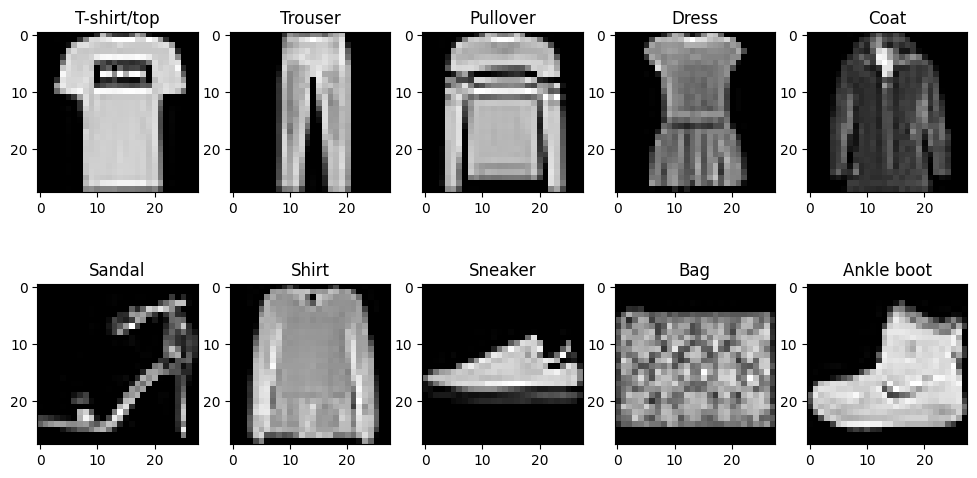

In [6]:

# ## load fashion data set

# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# ## GET TOTAL UNIQUE LABEL

# #print(train_labels.shape)
# #print(np.unique(train_labels))
# Labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# wandb.init(project="DL-Assignment-1-v3", name="Question 1")

# ## PLOT 10 IMAGES WITH LABELS


# figure, axi = plt.subplots(2 , 5, figsize=(12,6));

# for i in range(10):
#   idx = np.argwhere(train_labels == i)[0][0]
#   axi[i // 5][i % 5].imshow(train_images[idx], cmap = 'gray')
#   axi[i // 5][i % 5].set_title(Labels[i])
#   wandb.log({"Question 1": [wandb.Image(train_images[idx], caption = Labels[i]) ]})
# plt.show()
# wandb.finish()


In [5]:
# For seeing examples of images
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

wandb.init(project="DL-Assignment-1-v3")
run_name = "images_generating"
# Set the run name
wandb.run.name = run_name
wandb.run.save()

# this array keeps track for ind of each class
images_ind = []
# classes which are present
class_names = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

for i in range(10):
  for ind in range(X_train.shape[0]):
    if Y_train[ind] == i:
      images_ind.append(ind)
      break

images = []

for i in range(10):
  ind = images_ind[i]
  img = wandb.Image(X_train[ind], caption=[class_names[i]])
  images.append(img)

wandb.log({"Ques : 1": images})
wandb.finish()

plt.tight_layout()
plt.show()  # Display the plot

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


<Figure size 640x480 with 0 Axes>

In [44]:
# Activation functions
class ActivationFunctions:
  def relu(self,k):
    """
    ReLU (Rectified Linear Unit) activation function.
    It returns the input value if it's positive, otherwise, it returns zero.
    This helps in handling vanishing gradient problems in deep networks.
    """
    return k*(k>0)

  def sigmoid(self,k):
    """
    Sigmoid activation function.
    It maps input values to a range between 0 and 1, making it useful for probabilities.
    To avoid overflow/underflow issues, the input is clipped within [-500, 500].
    """
    s=1+np.exp(-k)
    return 1/s

  def tanh(self,k):
    """
    Hyperbolic tangent (tanh) activation function.
    It maps input values to a range between -1 and 1, which helps in training deep networks.
    Clipping prevents numerical instability.
    """
    s = np.tanh(k)
    return s

  def identity(self,x):
    """
    Identity activation function.
    It simply returns the input as it is.
    Used in linear layers where no transformation is required.
    """
    return x

  def grad_sigmoid(self,x):
    """
    Computes the gradient of the sigmoid function.
    Uses clipping to prevent overflow in the exponential function.
    """
    s = np.multiply((1/(1+np.exp(-x))),(1-(1/(1+np.exp(-x)))))
    return s

  def grad_tanh(self,x):
    """
    Computes the gradient of the tanh function.
    """
    return 1 - (np.tanh(x) ** 2)  # Derivative of tanh

  def grad_relu(self,x):
    """
    Computes the gradient of the ReLU function.
    Returns 1 for positive inputs, 0 otherwise.
    """
    relu_derivative=0
    relu_derivative=np.maximum(0,x)
    relu_derivative[relu_derivative>0]=1
    return relu_derivative

  def grad_identity(self,x):
    """
    Computes the gradient of the identity function.
    The derivative of an identity function is always 1.
    """

    return 1  # Return an array of ones

  def softmax(self,k):
    """
    Computes the softmax function.
    Uses normalization by subtracting max(a) to improve numerical stability.
    """
    x=np.copy(k)
    i=0
    while i < k.shape[0]:
        add=0
        largi=np.argmax(k[i])
        j=0
        while j< k.shape[1]:
            add+=np.exp(k[i][j]-k[i][largi])
            j=j+1
        s=k[i]-k[i][largi]
        k[i]=np.exp(s)/add
        x[i]=k[i]
        i=i+1
    return x

  def grad_softmax(self, a):
    """
    Computes the gradient of the softmax function.
    Note: This is an incorrect implementation of the gradient.
    The correct gradient is a Jacobian matrix, not element-wise.
    """
    return self.softmax(a) * (1 - self.softmax(a))  # Incorrect gradient

class LossFunction:
  def crossEntropy(self,y_hat,y1,cac):
    """
    Computes the cross-entropy loss.
    """
    l=0
    i=0
    for i in range (y1.shape[0]):
        l=l-((np.log2(y_hat[i][y1[i]])))
        i=i+1
    s=l+cac
    z=y1.shape[0]
    return s/z

  def meanSquaredError(self,y_hat,y1,cac):
    """
    Computes the mean squared error loss.
    """
    bl=np.zeros((y1.shape[0],y_hat.shape[1]))
    i=0
    while i<y1.shape[0]:
        bl[i][y1[i]]=1
        i=i+1
    s=(np.sum(((y_hat-bl)**2)))+cac
    t=y1.shape[0]
    return s/t



## NeuralNetwork

In [51]:
# import dataset
dataset = 'fashion_mnist'
if dataset == 'fashion_mnist':
  (x1, y1), (x2, y2) = fashion_mnist.load_data()
elif dataset== 'mnist':
  (x1, y1), (x2, y2) = mnist.load_data()

x1=x1.reshape(x1.shape[0],-1) / 255
x2=x2.reshape(x2.shape[0],-1)/ 255

x1, x_val, y1, y_val = train_test_split(x1,y1, test_size=0.1, random_state=0)
A = ActivationFunctions()
L = LossFunction()

# defined Neuarl Network class
class NeuralNetwork:
    def __init__(self):

        self.w,self.b,self.a,self.h,self.wd,self.ad,self.hd,self.bd=[],[],[],[],[],[],[],[]


#Defines various activation functions
    def activations(self,act,k):
        if act=='sigmoid':
            return A.sigmoid(k)
        elif act =='ReLU':
            return A.relu(k)
        elif act =='tanh':
            return A.tanh(k)
        elif act == 'identity':
          return A.identity(k)
        elif act =='softmax':
            return A.softmax(k)

# Defines derivatives of various activation functions.
    def gradActivations(self,act,k):
        if act=='sigmoid':
            return A.grad_sigmoid(k)
        if act=='ReLU':
            return A.grad_relu(k)
        if act=='tanh':
            return A.grad_tanh(k)
        if act == 'identity':
            return A.grad_identity(k)


# Defines loss functions.
    def functionLoss(self,lossFunc,y_hat,y1,Momentum):
        reg_loss=0
        i=0
        for i in range (len(self.w)):
            s=np.sum(self.w[i]**2)
            reg_loss=reg_loss+s
            i+=1
        reg_loss=(Momentum*reg_loss)/2
        ch=1
        if lossFunc=='crossEntropy':
            loss=0
            i=0
            for i in range (y1.shape[0]):
                x = y_hat[i][y1[i]]
                y = (np.log2(x))
                loss -= (y)
                i+=1
            return ((loss+reg_loss)/y1.shape[0])

        elif lossFunc=='meanSquaredError':
            bl=np.zeros((y1.shape[0],y_hat.shape[1]))
            i=0
            for i in range (y1.shape[0]):
                bl[i][y1[i]]=1
                i+=1
            return (((np.sum(((y_hat-bl)**2)))+reg_loss)/(y1.shape[0]))


# Initializes weights and biases for the neural network layers.

    def formLayers(self,hidden_layers,neuron,inpNeurons,start,classes,ques=0,hl=[]):

        self.w = []
        self.b = []

        totalLayer=[]
        if ques == 0:
          np.random.seed(5)
          totalLayer.append(inpNeurons)
          i=0
          for i in range (hidden_layers):
              totalLayer.append(neuron)
              i+=1
          intialization = 0
          totalLayer.append(classes)

        elif ques == 2:
          totalLayer = [inpNeurons] + hl + [classes]
          hidden_layers = len(hl)

        # totalLayer = [784,128,,,,,10]
        if start=='random':
            i=0
            while i<=hidden_layers:
                self.b.append(np.random.uniform(-0.5,0.5,(1,totalLayer[i+1])))
                self.w.append(np.random.uniform(-0.5,0.5,(totalLayer[i],totalLayer[i+1])))
                i+=1
        if start=='Xavier':
            i=0
            while i<=hidden_layers:
                frwd=totalLayer[i+1]
                curr=totalLayer[i]
                x=(np.random.randn(1,frwd))
                y=np.sqrt(6/(1+frwd))
                self.b.append(x*y)
                m=(np.random.randn(curr,frwd))
                n=np.sqrt(6/(curr+frwd))
                self.w.append(m*n)
                i+=1

#Performs forward pass through the neural network layers.
    def forward_pass(self,x,act='sigmoid'):

        self.a,self.h=[],[]
        check=x
        i=0
        while i<len(self.w)-1:
            q1=np.add(np.matmul(check,self.w[i]),self.b[i])
            bool = act=='ReLU' and i==0
            if (bool):
                j=0
                s=q1.shape[0]
                while j < s:
                    maxi=np.argmax(q1[j])
                    q1[j]/=q1[j][maxi]
                    j=j+1
            r1=self.activations(act,q1)
            check=r1
            self.h.append(r1)
            self.a.append(q1)
            i=i+1
        # print(len(self.w)-1,"check")
        z=len(self.w)-1
        q1=np.add(np.matmul(check,self.w[z]),self.b[z])
        r1=self.activations('softmax',q1)
        self.h.append(r1)
        self.a.append(q1)

        return self.h[-1]


# Performs backward pass through the neural network layers to compute gradients.
    def backward_pass(self,y_hat,y1,x1,classes,activation,lossFunc,Momentum):
        self.wd,self.bd,self.ad,self.hd=[],[],[],[]
        bl=0
        bl=np.zeros((y1.shape[0],classes))
        i=0
        while i< y1.shape[0]:
            bl[i][y1[i]]=1
            i=i+1

        b=None
        a=None


        if lossFunc=="crossEntropy":
            y_hat_l=np.zeros((y_hat.shape[0],1))
            i=0
            while i< y_hat.shape[0]:
                y_hat_l[i]=y_hat[i][y1[i]]
                i=i+1

            b=-1*(bl-y_hat)
            a=-1*(bl/y_hat_l)

            self.hd.append(a)
            self.ad.append(b)

        elif lossFunc=="meanSquaredError":
            s=y_hat-bl
            a=2*s
            self.hd.append(a)
            b=[]
            j=0
            while j< y_hat.shape[1]:
                r=y_hat.shape[0]
                s=y_hat.shape[1]
                hot_j=np.zeros((r,s))
                hot_j[:,j]=1
                hat_j=np.ones((r,s))*(y_hat[:,j].reshape(r,1))
                l=y_hat-bl
                x=hot_j-hat_j
                aj=2*(np.sum((l)*(y_hat*(x)),axis=1))
                b.append(aj)
                j=j+1
            self.ad.append(np.array(b).T)



        j = len(self.w)-1
        while j>-1:
            u=self.h[j-1].T
            bool = (j==0)
            if bool:
                u=x1.T
            t=x1.shape[0]
            length=len(self.ad)
            w=np.matmul(u,self.ad[-1])/t
            b=np.sum(self.ad[length-1],axis=0)/t
            if j!=0:
                a=np.matmul(self.ad[length-1],self.w[j].T)
                der=self.gradActivations(activation,self.a[j-1])
                z=np.multiply(a,der)
                self.hd.append(a)
                self.ad.append(z)
            self.bd.append(b)
            self.wd.append(w)
            j=j-1
        i=0

        while i< len(self.w):
            s=len(self.w)-1-i
            self.wd[s]-=Momentum*self.w[i]
            i=i+1
#Compute the accuracy of the neural network on the given dataset.
    def accuracy(self,x2,y2,act):
        self.forward_pass(x2,act)
        ypred=np.argmax(self.h[len(self.w)-1],axis=1)
        n=0
        l=y2.shape[0]
        i=0
        while i<y2.shape[0]:
            if ypred[i]!=y2[i]:
                n+=+1
            i+=1
        return ((x2.shape[0]-n)/y2.shape[0])*100

#Make predictions using the neural network and print the test accuracy.
    def predict(self,x2,y2,act):
        self.forward_pass(x2,act)
        fut=np.argmax(self.h[len(self.w)-1],axis=1)
        n=0
        i=0
        while i < y2.shape[0]:
            if fut[i]!=y2[i]:
                n+=1
            i+=1

        acc=((x2.shape[0]-n)/y2.shape[0])*100
        print("Test Accuracy: "+str(acc))

#Create batches from input data and labels.
    def createBatches(self,x1,y1,size):
        info,res=[],[]
        s=x1.shape[0]
        l=math.ceil(s/size)
        i=0
        while i < l:
            group,group_ans=[],[]
            j=i*size
            s=min((i+1)*size,x1.shape[0])
            while j< s:
                group.append(x1[j])
                group_ans.append(y1[j])
                j+=1
            group_ans=np.array(group_ans)
            group=np.array(group)
            info.append(group)
            res.append(group_ans)
            i+=1
        return info,res

#Perform one pass of forward and backward propagation through the network.
    def onePass(self,x1,y1,classes,lay,rate,act,lossFunc,Momentum):
        self.forward_pass(x1 ,act)
        l=lay-1
        self.backward_pass(self.h[l], y1,x1,10, act,lossFunc,Momentum)

# Train the neural network using SGD.
    def SGD(self,x1,y1,lay,epo,count,size,act,fn_ans,Momentum,c_l,w_l):
        classes=10
        info,res=self.createBatches(x1,y1,size)

        i=0
        while i < epo:
            h=None
            j=0
            s=len(info)
            while j< s:
                self.onePass(info[j],res[j],classes,lay,count,act,fn_ans,Momentum)
                k=0
                while k< lay:
                    q=lay-1-k
                    self.w[k]-=count*(self.wd[q])
                    self.b[k]-=count*self.bd[q]
                    k+=1
                j+=1
            i+=1
            self.forward_pass(x1,act)
            loss_train=1
            loss1=self.functionLoss(fn_ans,self.h[lay-1],y1,Momentum)
            self.forward_pass(x_val,act)
            loss2=self.functionLoss(fn_ans,self.h[lay-1],y_val,Momentum)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)

            if w_l == 1:
              wandb.log(
                      {
                          'Epoch ': i,
                          'Training_Loss' : round(loss1,2),
                          'Training_Accuracy' : round(acc1,2),
                          'Validation_Loss' : round(loss2,2),
                          'Validation_Accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))

# Train the neural network using Momentum
    def Momentum(self,x1,y1,lay,epo,count,size,eta,act,lossFunc,Momentum,c_l,w_l):
        info,res=self.createBatches(x1,y1,size)
        classes=10
        alpha,beta=[],[]
        i=0
        while i< lay:
            a=np.zeros((self.w[i].shape))
            b=np.zeros(self.b[i].shape)
            beta.append(b)
            alpha.append(a)
            i+=1
        i=0
        while i<epo :
            j=0
            while j< len(info):
                self.onePass(info[j],res[j],classes,lay,count,act,lossFunc,Momentum)
                k=0
                while k < lay:
                    s=lay-1-k
                    alpha[k]=(alpha[k]*eta)+self.wd[s]
                    beta[k]=(beta[k]*eta)+self.bd[s]
                    self.w[k]-=count*alpha[k]
                    self.b[k]-=count*beta[k]
                    k+=1
                j+=1
            i+=1

            self.forward_pass(x1,act)
            loss1=self.functionLoss(lossFunc,self.h[lay-1],y1,Momentum)
            self.forward_pass(x_val,act)
            loss2=self.functionLoss(lossFunc,self.h[lay-1],y_val,Momentum)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)

            if w_l == 1:
              wandb.log(
                      {
                          'Epoch ': i,
                          'Training_Loss' : round(loss1,2),
                          'Training_Accuracy' : round(acc1,2),
                          'Validation_Loss' : round(loss2,2),
                          'Validation_Accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))

# Train the neural network using nestrov
    def NAG(self,x1,y1,lay,epo,count,size,eta,act,lossFunc,Momentum,c_l,w_l):
        classes=10
        info,res=self.createBatches(x1,y1,size)

        alpha,beta=[],[]

        i=0
        while i<lay:
            b=np.zeros((self.b[i].shape))
            a=np.zeros((self.w[i].shape))
            beta.append(b)
            alpha.append(a)
            i+=1

        i=0
        while i< epo:
            j=0
            while j< len(info):
                k=0
                while k < lay:
                    self.b[k]-=eta*beta[k]
                    self.w[k]-=eta*alpha[k]
                    k+=1
                self.onePass(info[j],res[j],classes,lay,count,act,lossFunc,Momentum)
                k=0
                while k<lay:
                    s=lay-1-k
                    alpha[k]=(eta*alpha[k])+count*(self.wd[s])
                    beta[k]=(eta*beta[k])+count*self.bd[s]
                    self.b[k]-=beta[k]
                    self.w[k]-=alpha[k]
                    k+=1
                j+=1
            i+=1

            self.forward_pass(x1,act)
            s=lay-1
            loss1=self.functionLoss(lossFunc,self.h[s],y1,Momentum)
            self.forward_pass(x_val,act)
            loss2=self.functionLoss(lossFunc,self.h[s],y_val,Momentum)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)
            if w_l == 1:
              wandb.log(
                      {
                          'Epoch ': i,
                          'Training_Loss' : round(loss1,2),
                          'Training_Accuracy' : round(acc1,2),
                          'Validation_Loss' : round(loss2,2),
                          'Validation_Accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))



# Train the neural network using RMSProp.
    def RMSProp(self,x1,y1,lay,epo,count,size,eta,act,lossFunc,Momentum,e,c_l,w_l):
        info,res=self.createBatches(x1,y1,size)
        classes =10
        alpha,beta=[],[]

        i=0
        while i< lay:
            b=np.zeros((self.b[i].shape))
            a=np.zeros((self.w[i].shape))
            beta.append(b)
            alpha.append(a)
            i+=1

        i=0
        while i < int(epo):
            j=0
            while j < len(info):
                self.onePass(info[j],res[j],classes,lay,count,act,lossFunc,Momentum)
                k=0
                while k < lay:
                    s=lay-1-k
                    q=1-eta
                    alpha[k]=(alpha[k]*eta)+(q)*np.square(self.wd[s])
                    beta[k]=(beta[k]*eta)+(q)*np.square(self.bd[s])
                    self.w[k]-=(count/np.sqrt(np.linalg.norm(alpha[k]+e)))*self.wd[s]
                    self.b[k]-=(count/np.sqrt(np.linalg.norm(beta[k]+e)))*self.bd[s]
                    k+=1
                j+=1
            i+=1

            self.forward_pass(x1,act)
            s=lay-1
            loss1=self.functionLoss(lossFunc,self.h[s],y1,Momentum)
            self.forward_pass(x_val,act)
            loss2=self.functionLoss(lossFunc,self.h[s],y_val,Momentum)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)
            if w_l == 1:
              wandb.log(
                      {
                          'Epoch ': i,
                          'Training_Loss' : round(loss1,2),
                          'Training_Accuracy' : round(acc1,2),
                          'Validation_Loss' : round(loss2,2),
                          'Validation_Accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))

# Train the neural network using ADAM.
    def ADAM(self,x1,y1,lay,epo,count,size,eta1,eta2,act,lossFunc,e,Momentum,c_l,w_l):
        info,res=self.createBatches(x1,y1,size)
        classes=10
        w1,w2,b1,b2=[],[],[],[]

        i=0
        while i< lay:
            b=np.zeros((self.w[i].shape))
            a=np.zeros((self.w[i].shape))
            w2.append(b)
            w1.append(a)
            b=np.zeros((self.b[i].shape))
            a=np.zeros((self.b[i].shape))
            b1.append(a)
            b2.append(b)
            i+=1

        a=0
        i = 0
        while i < int(epo):
            j=0
            while j< len(info):
                a=a+1
                self.onePass(info[j],res[j],classes,lay,count,act,lossFunc,Momentum)
                k=0
                while k< lay:
                    r=1-eta1
                    p=1-eta2
                    u=1-eta1**a
                    v=1-eta2**a
                    s=lay-1-k

                    w1[k]=(w1[k]*eta1)+(r)*self.wd[s]
                    mwhat=w1[k]/(u)

                    w2[k]=(w2[k]*eta2)+(p)*np.square(self.wd[s])
                    vwhat=w2[k]/(v)

                    b1[k]=(b1[k]*eta1)+(r)*self.bd[s]
                    mbhat=b1[k]/(u)

                    b2[k]=(b2[k]*eta2)+(p)*np.square(self.bd[s])
                    vbhat=b2[k]/(v)

                    self.w[k]-=(count/np.sqrt(vwhat+e))*mwhat
                    self.b[k]-=(count/np.sqrt(vbhat+e))*mbhat
                    k+=1
                j+=1
            i=i+1
            self.forward_pass(x1, act)
            s=lay-1
            loss1=self.functionLoss(lossFunc,self.h[s],y1,Momentum)
            self.forward_pass(x_val,act)
            loss2=self.functionLoss(lossFunc,self.h[s],y_val,Momentum)
            acc1=self.accuracy(x1,y1,act)
            acc2=self.accuracy(x_val,y_val,act)
            if w_l == 1:
              wandb.log(
                      {
                          'Epoch ': i,
                          'Training_Loss' : round(loss1,2),
                          'Training_Accuracy' : round(acc1,2),
                          'Validation_Loss' : round(loss2,2),
                          'Validation_Accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))

# Train the neural network using NADAM
    def nADAM(self,x1,y1,lay,epo,count,size,eta1,eta2,act,lossFunc,e,Momentum,c_l,w_l):
        classes=10
        w1,w2,b1,b2=[],[],[],[]
        info,res=self.createBatches(x1,y1,size)

        for i in range(lay):
            b=np.zeros((self.w[i].shape))
            a=np.zeros((self.w[i].shape))
            w2.append(b)
            w1.append(a)
            b=np.zeros((self.b[i].shape))
            a=np.zeros((self.b[i].shape))
            b1.append(a)
            b2.append(b)

        a=0
        i=0
        while i< int(epo):
            j=0
            while j< len(info):
                a=a+1
                self.onePass(info[j],res[j],classes,lay,count,act,lossFunc,Momentum)
                k=0
                while k < lay:
                    r=1-eta1
                    p=1-eta2
                    u=1-eta1**a
                    v=1-eta2**a
                    s=lay-1-k
                    w1[k]=(w1[k]*eta1)+(r)*self.wd[s]
                    mwhat=w1[k]/(u)

                    w2[k]=(w2[k]*eta2)+(p)*np.square(self.wd[s])
                    vwhat=w2[k]/(v)

                    b1[k]=(b1[k]*eta1)+(r)*self.bd[s]
                    mbhat=b1[k]/(u)

                    b2[k]=(b2[k]*eta2)+(p)*np.square(self.bd[s])
                    vbhat=b2[k]/(v)

                    self.w[k]-=(count/np.sqrt(vwhat+e))*(eta1*mwhat+(((r)*self.wd[s])/(u)))
                    self.b[k]-=(count/np.sqrt(vbhat+e))*(eta1*mbhat+(((r)*self.bd[s])/(u)))
                    k=k+1
                j=j+1
            i=i+1
            self.forward_pass(x1,act)
            s=lay-1
            loss1=self.functionLoss(lossFunc ,self.h[s],y1,Momentum)
            self.forward_pass(x_val ,act)
            loss2=self.functionLoss(lossFunc,self.h[s], y_val,Momentum)
            acc1=self.accuracy(x1 ,y1 ,act)
            acc2=self.accuracy(x_val ,y_val,act)
            if w_l == 1:
              wandb.log(
                      {
                          'Epoch ': i,
                          'Training_Loss' : round(loss1,2),
                          'Training_Accuracy' : round(acc1,2),
                          'Validation_Loss' : round(loss2,2),
                          'Validation_Accuracy':round(acc2,2)
                      }
                  )
            if c_l == 1:

              print("Iteration Number: "+str(i), end="")
              print(" Train Loss : "+str(loss1))
              print("Iteration Number: "+str(i), end="")
              print(" Validation Loss : "+str(loss2))
              print("Iteration Number: "+str(i), end="")
              print(" Train Accurcy : "+str(acc1))
              print("Iteration Number: "+str(i), end="")
              print(" Validaion Accuracy: "+str(acc2))


# training the model based one given parameters
    def fit_model(self,x1,y1,x2,y2,hiddenlayers,neuron,input_neuron,batch,initialization,lossFunc,activation,optimizer,n,iter,beta,beta1,beta2,e,alpha,Momentum,c_l=1,w_l=1):
        # self.w,self.b=[],[]
        self.formLayers(hiddenlayers,neuron,input_neuron,initialization,10)
        # print(len(self.w),"arch")
        if optimizer=="SGD":
            self.SGD(x1,y1,len(self.w),iter,n,batch,activation,lossFunc,alpha,c_l,w_l)
        elif optimizer=='Momentum':
            self.Momentum(x1,y1,len(self.w),iter,n,batch,Momentum,activation,lossFunc,alpha,c_l,w_l)
        elif optimizer=='NAG':
            self.NAG(x1,y1,len(self.w),iter,n,batch,beta,activation,lossFunc,alpha,c_l,w_l)
        elif optimizer=='RMSProp':
            self.RMSProp(x1,y1,len(self.w),iter,n,batch,beta,activation,lossFunc,alpha,e,c_l,w_l)
        elif optimizer=='ADAM':
            self.ADAM(x1,y1,len(self.w),iter,n,batch,beta1,beta2,activation,lossFunc,e,alpha,c_l,w_l)
        elif optimizer=='nADAM':
            self.nADAM(x1,y1,len(self.w),iter,n,batch,beta1,beta2,activation,lossFunc,e,alpha,c_l,w_l)




## Ques :2

In [46]:
# Implementing forward pass
# Also making it flexible so that hidden layer size can vert
obj = NeuralNetwork()
hiddenlayer = [16,32,64]
obj.formLayers(4,64,784,'Xavier',10,2,hiddenlayer)
y_preds = obj.forward_pass(x2[1],act='tanh')
print("predicted values ->",y_preds)


predicted values -> [[0.01443834 0.07875069 0.01137712 0.65987786 0.08924478 0.08503693
  0.00376674 0.00591696 0.0200263  0.03156428]]


## Ques : 3

In [47]:
wandb.init(project="DL-Assignment-1-v3")
obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=3,
                 neuron=128,
                 input_neuron=784,
                 batch=32,
                 initialization="Xavier",
                 lossFunc="crossEntropy",
                 activation="tanh",
                 optimizer="RMSProp",
                 n=0.001,
                 iter=3,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-8,
                 alpha=0,
                 Momentum=0.9)
obj.predict(x2,y2,act="tanh")
wandb.finish()

Iteration Number: 1 Train Loss : 0.7012754208174107
Iteration Number: 1 Validation Loss : 0.7167375521812134
Iteration Number: 1 Train Accurcy : 82.53703703703704
Iteration Number: 1 Validaion Accuracy: 82.26666666666667
Iteration Number: 2 Train Loss : 0.6132405642489823
Iteration Number: 2 Validation Loss : 0.6291092219709723
Iteration Number: 2 Train Accurcy : 84.77222222222223
Iteration Number: 2 Validaion Accuracy: 84.21666666666667
Iteration Number: 3 Train Loss : 0.567798257545084
Iteration Number: 3 Validation Loss : 0.5862449159432226
Iteration Number: 3 Train Accurcy : 85.87407407407407
Iteration Number: 3 Validaion Accuracy: 85.51666666666667
Test Accuracy: 84.28


Epoch,▁▅█
Training_Accuracy,▁▆█
Training_Loss,█▃▁
Validation_Accuracy,▁▅█
Validation_Loss,█▃▁
Epoch,3
Training_Accuracy,85.87
Training_Loss,0.57
Validation_Accuracy,85.52
Validation_Loss,0.59


## Ques 4

In [11]:
sweep_config = {
            'name': 'sweep 1 : Bayes',
            'method': 'bayes',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters':
                {
                    # 'dataset' : {'values': ['fashion_mnist']}, # 'fashion_mnist', 'mnist'
                    'iter': {'values': [5,10]},
                    'batch': {'values': [32,64]},
                    'lossFunc': {'values': ['crossEntropy', 'meanSquaredError']}, # 'meanSquaredError', 'crossEntropy'
                    'optimizer': {'values': ['SGD', 'Momentum', 'NAG', 'RMSProp', 'ADAM', 'nADAM']}, # 'SGD', 'Momentum', 'NAG', 'RMSProp', 'ADAM', 'nADAM'
                    'n' : {'values': [1e-3, 1e-4]},
                    'Momentum' : {'values': [0.9,0.5]},
                    'beta' : {'values': [0.9,0.5]},
                    'e' : {'values': [1e-6]},
                    'alpha': {'values': [0,0.0005]},
                    'initialization': {'values': ['random','Xavier']}, # 'random', 'Xavier'
                    'hiddenlayers': {'values': [3, 4, 5]},
                    'neuron': {'values': [32, 64, 128]},
                    'activation': {'values': ['identity', 'sigmoid','tanh', 'ReLU']}, # 'identity', 'sigmoid', 'tanh', 'ReLU'
                    'outAct': {'values': ['softmax']}
                }
            }



def train():
    #init-classinit , config - param_copy
    init = wandb.init(project='DL-Assignment-1-v3')
    config = init.config
    wandb.run.name = (
        'o:' + config.optimizer +
        '_a:' + config.activation +
        '_ep:' + str(config.iter) +
        '_l:' + config.lossFunc +
        '_i:' + config.initialization +
        '_hl:' + str(config.hiddenlayers) +
        '_hls:' + str(config.neuron)
    )
    obj=NeuralNetwork()
    obj.fit_model(x1,
                    y1,
                    x_val,
                    y_val,
                    hiddenlayers=config.hiddenlayers,
                    neuron=config.neuron,
                    input_neuron=784,
                    batch=config.batch,
                    initialization=config.initialization,
                    lossFunc=config.lossFunc,
                    activation=config.activation,
                    optimizer=config.optimizer,
                    n=config.n,
                    iter=config.iter,
                    beta=config.beta,
                    beta1=0.999,
                    beta2=0.999,
                    e=config.e,
                    alpha=config.alpha,
                    Momentum=config.Momentum)

    val_acc = obj.accuracy(x_val,y_val,config.activation)
    wandb.log({'Accuracy': val_acc})




sweep_id = wandb.sweep(sweep_config, project='DL-Assignment-1-v3')
wandb.agent(sweep_id, train, count = 100)
wandb.finish()





Create sweep with ID: x96a87lk
Sweep URL: https://wandb.ai/cs24m019-iitm/DL-Assignment-1-v3/sweeps/x96a87lk


wandb: Agent Starting Run: pfkn40fq with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.3508045415420827
Iteration Number: 1 Validation Loss : 0.3589683456321379
Iteration Number: 1 Train Accurcy : 74.38333333333334
Iteration Number: 1 Validaion Accuracy: 73.65
Iteration Number: 2 Train Loss : 0.31072682562502035
Iteration Number: 2 Validation Loss : 0.31594945419289217
Iteration Number: 2 Train Accurcy : 77.08148148148149
Iteration Number: 2 Validaion Accuracy: 77.11666666666666
Iteration Number: 3 Train Loss : 0.2966641333145325
Iteration Number: 3 Validation Loss : 0.30554818318132093
Iteration Number: 3 Train Accurcy : 78.06851851851852
Iteration Number: 3 Validaion Accuracy: 77.51666666666667
Iteration Number: 4 Train Loss : 0.28751364225949677
Iteration Number: 4 Validation Loss : 0.296341137484059
Iteration Number: 4 Train Accurcy : 78.92407407407407
Iteration Number: 4 Validaion Accuracy: 78.25
Iteration Number: 5 Train Loss : 0.3013695361320975
Iteration Number: 5 Validation Loss : 0.3128477676768189
Iteration Number: 5 Train Ac

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▅▆█▅▆█▇█▇
Training_Loss,█▄▃▂▃▃▁▂▁▂
Validation_Accuracy,▁▆▇█▆▆█▇▇▆
Validation_Loss,█▃▂▁▂▂▁▂▂▃
Accuracy,77.08333
Epoch,10
Training_Accuracy,78.6
Training_Loss,0.29
Validation_Accuracy,77.08


wandb: Agent Starting Run: cryverpr with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.895795567326402
Iteration Number: 1 Validation Loss : 0.9003924925417564
Iteration Number: 1 Train Accurcy : 78.02037037037037
Iteration Number: 1 Validaion Accuracy: 78.13333333333333
Iteration Number: 2 Train Loss : 0.7659279043316268
Iteration Number: 2 Validation Loss : 0.7713419706499782
Iteration Number: 2 Train Accurcy : 81.50185185185185
Iteration Number: 2 Validaion Accuracy: 81.76666666666667
Iteration Number: 3 Train Loss : 0.7168746062600947
Iteration Number: 3 Validation Loss : 0.7234655816931659
Iteration Number: 3 Train Accurcy : 82.89814814814814
Iteration Number: 3 Validaion Accuracy: 83.31666666666668
Iteration Number: 4 Train Loss : 0.6892628577346586
Iteration Number: 4 Validation Loss : 0.6986699278740095
Iteration Number: 4 Train Accurcy : 83.52407407407408
Iteration Number: 4 Validaion Accuracy: 83.98333333333333
Iteration Number: 5 Train Loss : 0.6687890170061551
Iteration Number: 5 Validation Loss : 0.6802337295140685
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▇▇▇███
Training_Loss,█▅▄▃▂▂▂▁▁▁
Validation_Accuracy,▁▅▆▇▇▇████
Validation_Loss,█▅▃▃▂▂▂▁▁▁
Accuracy,85.18333
Epoch,10
Training_Accuracy,85.35
Training_Loss,0.61
Validation_Accuracy,85.18


wandb: Agent Starting Run: vaj8a4ik with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.5
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.001
wandb: 	neuron: 32
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.30260428960254776
Iteration Number: 1 Validation Loss : 0.30662750795623994
Iteration Number: 1 Train Accurcy : 77.69814814814815
Iteration Number: 1 Validaion Accuracy: 77.68333333333334
Iteration Number: 2 Train Loss : 0.2645467212737012
Iteration Number: 2 Validation Loss : 0.2715872181415141
Iteration Number: 2 Train Accurcy : 81.66481481481482
Iteration Number: 2 Validaion Accuracy: 81.03333333333333
Iteration Number: 3 Train Loss : 0.2352074362900644
Iteration Number: 3 Validation Loss : 0.24235837768905155
Iteration Number: 3 Train Accurcy : 83.68703703703704
Iteration Number: 3 Validaion Accuracy: 82.98333333333333
Iteration Number: 4 Train Loss : 0.22797472281421455
Iteration Number: 4 Validation Loss : 0.24226881154725302
Iteration Number: 4 Train Accurcy : 84.24444444444444
Iteration Number: 4 Validaion Accuracy: 83.21666666666667
Iteration Number: 5 Train Loss : 0.2148620211673507
Iteration Number: 5 Validation Loss : 0.2289652104604962
It

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▇▇▇███
Training_Loss,█▅▄▄▂▂▂▂▂▁
Validation_Accuracy,▁▄▆▆▇▇▇███
Validation_Loss,█▅▃▃▂▁▁▁▁▁
Accuracy,85.01667
Epoch,10
Training_Accuracy,86.9
Training_Loss,0.19
Validation_Accuracy,85.02


wandb: Agent Starting Run: jmtt66dx with config:
wandb: 	Momentum: 0.9
wandb: 	activation: identity
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.5
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 5
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: SGD
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.477696661976545
Iteration Number: 1 Validation Loss : 1.46553081192589
Iteration Number: 1 Train Accurcy : 25.6
Iteration Number: 1 Validaion Accuracy: 26.28333333333333
Iteration Number: 2 Train Loss : 1.443439658895843
Iteration Number: 2 Validation Loss : 1.4336615057765612
Iteration Number: 2 Train Accurcy : 27.41851851851852
Iteration Number: 2 Validaion Accuracy: 27.933333333333334
Iteration Number: 3 Train Loss : 1.433913191088354
Iteration Number: 3 Validation Loss : 1.4229251506664837
Iteration Number: 3 Train Accurcy : 27.900000000000002
Iteration Number: 3 Validaion Accuracy: 28.51666666666667
Iteration Number: 4 Train Loss : 1.4149985299889427
Iteration Number: 4 Validation Loss : 1.404751648982838
Iteration Number: 4 Train Accurcy : 28.857407407407408
Iteration Number: 4 Validaion Accuracy: 29.4
Iteration Number: 5 Train Loss : 1.3992273500995345
Iteration Number: 5 Validation Loss : 1.3904395449669886
Iteration Number: 5 Train Accurcy : 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▄▅▇█
Training_Loss,█▅▄▂▁
Validation_Accuracy,▁▄▅▇█
Validation_Loss,█▄▄▂▁
Accuracy,30.08333
Epoch,5
Training_Accuracy,29.65
Training_Loss,1.4
Validation_Accuracy,30.08


wandb: Agent Starting Run: q1vryxny with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: SGD
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5178493749815815
Iteration Number: 1 Validation Loss : 0.5251378859950387
Iteration Number: 1 Train Accurcy : 65.11851851851851
Iteration Number: 1 Validaion Accuracy: 64.3
Iteration Number: 2 Train Loss : 0.3823435799424541
Iteration Number: 2 Validation Loss : 0.38368186798307286
Iteration Number: 2 Train Accurcy : 73.89814814814815
Iteration Number: 2 Validaion Accuracy: 74.18333333333334
Iteration Number: 3 Train Loss : 0.3324664996418409
Iteration Number: 3 Validation Loss : 0.3337694153532348
Iteration Number: 3 Train Accurcy : 77.50555555555556
Iteration Number: 3 Validaion Accuracy: 77.43333333333334
Iteration Number: 4 Train Loss : 0.30755839232256005
Iteration Number: 4 Validation Loss : 0.3087376545370653
Iteration Number: 4 Train Accurcy : 79.47407407407408
Iteration Number: 4 Validaion Accuracy: 79.33333333333333
Iteration Number: 5 Train Loss : 0.2909529687183478
Iteration Number: 5 Validation Loss : 0.2923423227093209
Iteration Number: 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▇▇▇▇███
Training_Loss,█▄▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▅▆▆▇▇▇███
Validation_Loss,█▄▃▃▂▂▂▁▁▁
Accuracy,83.46667
Epoch,10
Training_Accuracy,83.22
Training_Loss,0.25
Validation_Accuracy,83.47


wandb: Agent Starting Run: owf6qi0n with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.0001
wandb: 	neuron: 32
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5752995244751725
Iteration Number: 1 Validation Loss : 0.5858541286296981
Iteration Number: 1 Train Accurcy : 56.39074074074074
Iteration Number: 1 Validaion Accuracy: 55.900000000000006
Iteration Number: 2 Train Loss : 0.4418523772078059
Iteration Number: 2 Validation Loss : 0.4496588224559772
Iteration Number: 2 Train Accurcy : 68.57777777777778
Iteration Number: 2 Validaion Accuracy: 67.53333333333333
Iteration Number: 3 Train Loss : 0.3721597712331213
Iteration Number: 3 Validation Loss : 0.37904580852705266
Iteration Number: 3 Train Accurcy : 73.81296296296296
Iteration Number: 3 Validaion Accuracy: 72.93333333333332
Iteration Number: 4 Train Loss : 0.3293018872745339
Iteration Number: 4 Validation Loss : 0.33358033324342906
Iteration Number: 4 Train Accurcy : 77.32037037037037
Iteration Number: 4 Validaion Accuracy: 76.88333333333334
Iteration Number: 5 Train Loss : 0.3046530321512975
Iteration Number: 5 Validation Loss : 0.30751050407022273
Ite

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▇▇▇▇███
Training_Loss,█▅▄▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▅▇▇▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,82.51667
Epoch,10
Training_Accuracy,82.57
Training_Loss,0.25
Validation_Accuracy,82.52


wandb: Agent Starting Run: d584j8kq with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.808380290438442
Iteration Number: 1 Validation Loss : 0.8231755875602272
Iteration Number: 1 Train Accurcy : 79.06666666666666
Iteration Number: 1 Validaion Accuracy: 78.63333333333333
Iteration Number: 2 Train Loss : 0.6958276657512912
Iteration Number: 2 Validation Loss : 0.6992554168075091
Iteration Number: 2 Train Accurcy : 81.87037037037037
Iteration Number: 2 Validaion Accuracy: 82.28333333333333
Iteration Number: 3 Train Loss : 0.612332984750629
Iteration Number: 3 Validation Loss : 0.6248097780690833
Iteration Number: 3 Train Accurcy : 84.51296296296297
Iteration Number: 3 Validaion Accuracy: 84.46666666666667
Iteration Number: 4 Train Loss : 0.577350496711199
Iteration Number: 4 Validation Loss : 0.5916507092399494
Iteration Number: 4 Train Accurcy : 85.50740740740741
Iteration Number: 4 Validaion Accuracy: 85.38333333333334
Iteration Number: 5 Train Loss : 0.5503011584021191
Iteration Number: 5 Validation Loss : 0.5675443613505817
Iteration 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▇▇▇██
Training_Loss,█▆▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▆▆▇▇████
Validation_Loss,█▅▄▃▃▂▂▁▁▁
Accuracy,87.63333
Epoch,10
Training_Accuracy,88.44
Training_Loss,0.46
Validation_Accuracy,87.63


wandb: Agent Starting Run: stnge2dz with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6228285664946025
Iteration Number: 1 Validation Loss : 0.6420865425639911
Iteration Number: 1 Train Accurcy : 84.72222222222221
Iteration Number: 1 Validaion Accuracy: 84.73333333333333
Iteration Number: 2 Train Loss : 0.550680316217248
Iteration Number: 2 Validation Loss : 0.5763867169754849
Iteration Number: 2 Train Accurcy : 86.36296296296297
Iteration Number: 2 Validaion Accuracy: 86.06666666666666
Iteration Number: 3 Train Loss : 0.5048197686862577
Iteration Number: 3 Validation Loss : 0.5348507495264724
Iteration Number: 3 Train Accurcy : 87.21481481481482
Iteration Number: 3 Validaion Accuracy: 87.0
Iteration Number: 4 Train Loss : 0.4893055946556352
Iteration Number: 4 Validation Loss : 0.5448672205358965
Iteration Number: 4 Train Accurcy : 87.52777777777779
Iteration Number: 4 Validaion Accuracy: 86.85000000000001
Iteration Number: 5 Train Loss : 0.47942571213487967
Iteration Number: 5 Validation Loss : 0.5628363255704705
Iteration Number: 5 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▅▇██▇
Training_Loss,█▅▃▃▃▃▂▁▂▃
Validation_Accuracy,▁▄▇▆▇▅▇█▇▅
Validation_Loss,▃▂▁▁▂▂▂▂▅█
Accuracy,86.51667
Epoch,10
Training_Accuracy,88.45
Training_Loss,0.48
Validation_Accuracy,86.52


wandb: Agent Starting Run: 4jfjyf0n with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6358572488023566
Iteration Number: 1 Validation Loss : 0.6432006667323988
Iteration Number: 1 Train Accurcy : 83.92222222222222
Iteration Number: 1 Validaion Accuracy: 84.13333333333334
Iteration Number: 2 Train Loss : 0.5586719597084355
Iteration Number: 2 Validation Loss : 0.58654944954757
Iteration Number: 2 Train Accurcy : 85.93518518518518
Iteration Number: 2 Validaion Accuracy: 85.83333333333333
Iteration Number: 3 Train Loss : 0.5077070233948703
Iteration Number: 3 Validation Loss : 0.5391153080091289
Iteration Number: 3 Train Accurcy : 87.13518518518518
Iteration Number: 3 Validaion Accuracy: 86.68333333333334
Iteration Number: 4 Train Loss : 0.47476867984303406
Iteration Number: 4 Validation Loss : 0.5128851825874332
Iteration Number: 4 Train Accurcy : 88.02962962962962
Iteration Number: 4 Validaion Accuracy: 87.55
Iteration Number: 5 Train Loss : 0.45534670162588575
Iteration Number: 5 Validation Loss : 0.49534716549362134
Iteration Number: 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▆▅▇██
Training_Loss,█▆▄▃▃▃▃▂▁▁
Validation_Accuracy,▁▄▆▇█▇▅███
Validation_Loss,█▆▄▂▂▂▄▁▁▁
Accuracy,87.85
Epoch,10
Training_Accuracy,89.82
Training_Loss,0.4
Validation_Accuracy,87.85


wandb: Agent Starting Run: gc68tfxg with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6678598917161346
Iteration Number: 1 Validation Loss : 0.6804676576650731
Iteration Number: 1 Train Accurcy : 83.2462962962963
Iteration Number: 1 Validaion Accuracy: 82.66666666666667
Iteration Number: 2 Train Loss : 0.6085879765676533
Iteration Number: 2 Validation Loss : 0.6306254004718381
Iteration Number: 2 Train Accurcy : 84.04444444444444
Iteration Number: 2 Validaion Accuracy: 83.96666666666667
Iteration Number: 3 Train Loss : 0.5468018067861313
Iteration Number: 3 Validation Loss : 0.5695872024579159
Iteration Number: 3 Train Accurcy : 85.88888888888889
Iteration Number: 3 Validaion Accuracy: 85.5
Iteration Number: 4 Train Loss : 0.5221688168514352
Iteration Number: 4 Validation Loss : 0.5608402056932886
Iteration Number: 4 Train Accurcy : 86.63703703703703
Iteration Number: 4 Validaion Accuracy: 86.11666666666666
Iteration Number: 5 Train Loss : 0.4834421866516269
Iteration Number: 5 Validation Loss : 0.5291696642970832
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▂▄▅▆▆▇███
Training_Loss,█▆▅▄▃▃▂▁▂▁
Validation_Accuracy,▁▃▅▅▆▆▇▇██
Validation_Loss,█▆▄▄▃▃▂▂▁▁
Accuracy,88.16667
Epoch,10
Training_Accuracy,89.28
Training_Loss,0.42
Validation_Accuracy,88.17


wandb: Agent Starting Run: aapv2782 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.5
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.28761720746295893
Iteration Number: 1 Validation Loss : 0.28753901699748374
Iteration Number: 1 Train Accurcy : 79.32407407407408
Iteration Number: 1 Validaion Accuracy: 79.31666666666666
Iteration Number: 2 Train Loss : 0.2574382433506806
Iteration Number: 2 Validation Loss : 0.26192755511539445
Iteration Number: 2 Train Accurcy : 81.43518518518519
Iteration Number: 2 Validaion Accuracy: 81.45
Iteration Number: 3 Train Loss : 0.22743435443906548
Iteration Number: 3 Validation Loss : 0.23561314077110604
Iteration Number: 3 Train Accurcy : 83.85740740740741
Iteration Number: 3 Validaion Accuracy: 83.55
Iteration Number: 4 Train Loss : 0.20926485970179082
Iteration Number: 4 Validation Loss : 0.21669390522791127
Iteration Number: 4 Train Accurcy : 85.30925925925926
Iteration Number: 4 Validaion Accuracy: 85.56666666666666
Iteration Number: 5 Train Loss : 0.20293701240189524
Iteration Number: 5 Validation Loss : 0.2133427319954455
Iteration Number: 5 Tra

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▇▇███
Training_Loss,█▆▅▃▃▃▂▂▂▁
Validation_Accuracy,▁▃▅▆▆▇▇███
Validation_Loss,█▆▅▃▂▂▂▁▁▁
Accuracy,87.38333
Epoch,10
Training_Accuracy,88.33
Training_Loss,0.17
Validation_Accuracy,87.38


wandb: Agent Starting Run: ytlmop8a with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 32
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.3086270101322637
Iteration Number: 1 Validation Loss : 1.31224898986429
Iteration Number: 1 Train Accurcy : 69.82037037037037
Iteration Number: 1 Validaion Accuracy: 69.13333333333334
Iteration Number: 2 Train Loss : 0.9793719761417019
Iteration Number: 2 Validation Loss : 0.9844802271019661
Iteration Number: 2 Train Accurcy : 75.4
Iteration Number: 2 Validaion Accuracy: 74.35000000000001
Iteration Number: 3 Train Loss : 0.8686154488448949
Iteration Number: 3 Validation Loss : 0.8766325863827945
Iteration Number: 3 Train Accurcy : 77.53703703703704
Iteration Number: 3 Validaion Accuracy: 76.71666666666667
Iteration Number: 4 Train Loss : 0.8030963026472954
Iteration Number: 4 Validation Loss : 0.8126135432452161
Iteration Number: 4 Train Accurcy : 79.38148148148149
Iteration Number: 4 Validaion Accuracy: 78.85
Iteration Number: 5 Train Loss : 0.7535596266014876
Iteration Number: 5 Validation Loss : 0.7650058123298239
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇███
Training_Loss,█▅▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▃▄▅▆▇▇███
Validation_Loss,█▅▃▃▂▂▁▁▁▁
Accuracy,84.41667
Epoch,10
Training_Accuracy,84.47
Training_Loss,0.63
Validation_Accuracy,84.42


wandb: Agent Starting Run: 4dxgpcau with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6414563700691039
Iteration Number: 1 Validation Loss : 0.6489921109993199
Iteration Number: 1 Train Accurcy : 84.36851851851853
Iteration Number: 1 Validaion Accuracy: 84.55
Iteration Number: 2 Train Loss : 0.5607130252153955
Iteration Number: 2 Validation Loss : 0.5786800145760959
Iteration Number: 2 Train Accurcy : 86.09259259259258
Iteration Number: 2 Validaion Accuracy: 85.88333333333334
Iteration Number: 3 Train Loss : 0.5180055512207977
Iteration Number: 3 Validation Loss : 0.5445708073240737
Iteration Number: 3 Train Accurcy : 86.95925925925926
Iteration Number: 3 Validaion Accuracy: 86.41666666666666
Iteration Number: 4 Train Loss : 0.5001637964204099
Iteration Number: 4 Validation Loss : 0.5407500702384052
Iteration Number: 4 Train Accurcy : 87.46481481481482
Iteration Number: 4 Validaion Accuracy: 86.88333333333334
Iteration Number: 5 Train Loss : 0.5075301994507976
Iteration Number: 5 Validation Loss : 0.561806942876528
Iteration Number: 5 

<ipython-input-7-bc8d0b95e986>:165: RuntimeWarning: divide by zero encountered in divide
  a=-1*(bl/y_hat_l)
<ipython-input-7-bc8d0b95e986>:165: RuntimeWarning: invalid value encountered in divide
  a=-1*(bl/y_hat_l)


Iteration Number: 9 Train Loss : 0.5366180579444392
Iteration Number: 9 Validation Loss : 0.6891972293196356
Iteration Number: 9 Train Accurcy : 87.42037037037036
Iteration Number: 9 Validaion Accuracy: 85.66666666666667


<ipython-input-7-bc8d0b95e986>:62: RuntimeWarning: divide by zero encountered in log2
  y = (np.log2(x))


Iteration Number: 10 Train Loss : inf
Iteration Number: 10 Validation Loss : inf
Iteration Number: 10 Train Accurcy : 88.30555555555556
Iteration Number: 10 Validaion Accuracy: 86.95


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▆▇▇▇▆█
Training_Loss,█▅▃▂▂▁▁▂▄
Validation_Accuracy,▁▄▆▇▆██▅▄▇
Validation_Loss,▆▃▁▁▂▁▂▅█
Accuracy,86.95
Epoch,10
Training_Accuracy,88.31
Training_Loss,inf
Validation_Accuracy,86.95


wandb: Agent Starting Run: ohko5zls with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.495148002518624
Iteration Number: 1 Validation Loss : 1.511943199396569
Iteration Number: 1 Train Accurcy : 68.68703703703703
Iteration Number: 1 Validaion Accuracy: 67.86666666666666
Iteration Number: 2 Train Loss : 1.1477922206204998
Iteration Number: 2 Validation Loss : 1.1595889313748942
Iteration Number: 2 Train Accurcy : 73.30925925925926
Iteration Number: 2 Validaion Accuracy: 72.15
Iteration Number: 3 Train Loss : 1.0169207705632288
Iteration Number: 3 Validation Loss : 1.0248418231023833
Iteration Number: 3 Train Accurcy : 75.5
Iteration Number: 3 Validaion Accuracy: 74.73333333333333
Iteration Number: 4 Train Loss : 0.9435752000138553
Iteration Number: 4 Validation Loss : 0.9495332299978478
Iteration Number: 4 Train Accurcy : 77.26851851851852
Iteration Number: 4 Validaion Accuracy: 76.86666666666667
Iteration Number: 5 Train Loss : 0.8939460538723819
Iteration Number: 5 Validation Loss : 0.8991000618333448
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇███
Training_Loss,█▅▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▃▅▆▆▇▇███
Validation_Loss,█▅▃▃▂▂▂▁▁▁
Accuracy,81.35
Epoch,10
Training_Accuracy,81.36
Training_Loss,0.77
Validation_Accuracy,81.35


wandb: Agent Starting Run: o0jy29kz with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.5
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.6029209157437319
Iteration Number: 1 Validation Loss : 1.5836161170358325
Iteration Number: 1 Train Accurcy : 19.827777777777776
Iteration Number: 1 Validaion Accuracy: 20.783333333333335
Iteration Number: 2 Train Loss : 1.6045106280749002
Iteration Number: 2 Validation Loss : 1.5846807983476225
Iteration Number: 2 Train Accurcy : 19.772222222222222
Iteration Number: 2 Validaion Accuracy: 20.766666666666666
Iteration Number: 3 Train Loss : 1.6089090048369945
Iteration Number: 3 Validation Loss : 1.5889999883965178
Iteration Number: 3 Train Accurcy : 19.553703703703704
Iteration Number: 3 Validaion Accuracy: 20.549999999999997
Iteration Number: 4 Train Loss : 1.6237476110718616
Iteration Number: 4 Validation Loss : 1.6012350393934893
Iteration Number: 4 Train Accurcy : 18.80925925925926
Iteration Number: 4 Validaion Accuracy: 19.933333333333334
Iteration Number: 5 Train Loss : 1.6035310938338785
Iteration Number: 5 Validation Loss : 1.58432947350261
It

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,██▇▄██▆▅█▁
Training_Loss,▁▁▃▅▁▃▃▅▁█
Validation_Accuracy,██▇▅██▆▆█▁
Validation_Loss,▁▁▃▅▁▃▃▅▁█
Accuracy,18.95
Epoch,10
Training_Accuracy,18.05
Training_Loss,1.64
Validation_Accuracy,18.95


wandb: Agent Starting Run: zqmretdp with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6955382694658249
Iteration Number: 1 Validation Loss : 0.7116400803122747
Iteration Number: 1 Train Accurcy : 82.53888888888888
Iteration Number: 1 Validaion Accuracy: 82.58333333333333
Iteration Number: 2 Train Loss : 0.5741920856138775
Iteration Number: 2 Validation Loss : 0.5906183919860277
Iteration Number: 2 Train Accurcy : 85.65
Iteration Number: 2 Validaion Accuracy: 85.53333333333333
Iteration Number: 3 Train Loss : 0.5421839062772867
Iteration Number: 3 Validation Loss : 0.561615413390685
Iteration Number: 3 Train Accurcy : 86.39444444444445
Iteration Number: 3 Validaion Accuracy: 85.83333333333333
Iteration Number: 4 Train Loss : 0.5161841912515952
Iteration Number: 4 Validation Loss : 0.5432193082678711
Iteration Number: 4 Train Accurcy : 86.98518518518519
Iteration Number: 4 Validaion Accuracy: 86.73333333333333
Iteration Number: 5 Train Loss : 0.5195079368987825
Iteration Number: 5 Validation Loss : 0.5607597000659904
Iteration Number: 5 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▅▆▇▇██▇█▆
Training_Loss,█▃▂▂▂▁▁▂▂▃
Validation_Accuracy,▁▅▆▇▇▇█▇█▆
Validation_Loss,█▃▂▁▂▁▃▄▃▇
Accuracy,85.6
Epoch,10
Training_Accuracy,86.54
Training_Loss,0.56
Validation_Accuracy,85.6


wandb: Agent Starting Run: a87mu6ro with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.9307265723240264
Iteration Number: 1 Validation Loss : 0.9386769558220208
Iteration Number: 1 Train Accurcy : 76.65555555555555
Iteration Number: 1 Validaion Accuracy: 76.23333333333333
Iteration Number: 2 Train Loss : 0.7686286345573885
Iteration Number: 2 Validation Loss : 0.7813768905539926
Iteration Number: 2 Train Accurcy : 81.14074074074074
Iteration Number: 2 Validaion Accuracy: 80.48333333333333
Iteration Number: 3 Train Loss : 0.6990922479561646
Iteration Number: 3 Validation Loss : 0.7152365929528287
Iteration Number: 3 Train Accurcy : 82.80185185185185
Iteration Number: 3 Validaion Accuracy: 82.6
Iteration Number: 4 Train Loss : 0.6578141821406789
Iteration Number: 4 Validation Loss : 0.6719952385689979
Iteration Number: 4 Train Accurcy : 83.70185185185186
Iteration Number: 4 Validaion Accuracy: 83.73333333333333
Iteration Number: 5 Train Loss : 0.6254377970541968
Iteration Number: 5 Validation Loss : 0.6389529526465755
Iteration Number: 5 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,86.51667
Epoch,10
Training_Accuracy,86.46
Training_Loss,0.54
Validation_Accuracy,86.52


wandb: Agent Starting Run: ub54nyyk with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 64
wandb: 	optimizer: RMSProp
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.6392955354279917
Iteration Number: 1 Validation Loss : 1.649553351000414
Iteration Number: 1 Train Accurcy : 64.87037037037037
Iteration Number: 1 Validaion Accuracy: 64.35
Iteration Number: 2 Train Loss : 1.1837599540931205
Iteration Number: 2 Validation Loss : 1.1914993109988088
Iteration Number: 2 Train Accurcy : 73.22222222222223
Iteration Number: 2 Validaion Accuracy: 72.96666666666667
Iteration Number: 3 Train Loss : 1.014190334272132
Iteration Number: 3 Validation Loss : 1.0177936323461543
Iteration Number: 3 Train Accurcy : 76.31481481481481
Iteration Number: 3 Validaion Accuracy: 76.6
Iteration Number: 4 Train Loss : 0.9291676249749136
Iteration Number: 4 Validation Loss : 0.931202832022226
Iteration Number: 4 Train Accurcy : 77.84814814814814
Iteration Number: 4 Validaion Accuracy: 77.95
Iteration Number: 5 Train Loss : 0.8756494733007315
Iteration Number: 5 Validation Loss : 0.8771925108583792
Iteration Number: 5 Train Accurcy : 78.96666666

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▇▇▇███
Training_Loss,█▄▃▂▂▂▁▁▁▁
Validation_Accuracy,▁▄▆▆▇▇▇███
Validation_Loss,█▄▃▂▂▂▁▁▁▁
Accuracy,81.73333
Epoch,10
Training_Accuracy,81.76
Training_Loss,0.75
Validation_Accuracy,81.73


wandb: Agent Starting Run: vkwbxuty with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7624881164496691
Iteration Number: 1 Validation Loss : 0.7612902599304591
Iteration Number: 1 Train Accurcy : 80.78148148148148
Iteration Number: 1 Validaion Accuracy: 81.08333333333333
Iteration Number: 2 Train Loss : 0.6719761960541663
Iteration Number: 2 Validation Loss : 0.6737575002249424
Iteration Number: 2 Train Accurcy : 82.74259259259259
Iteration Number: 2 Validaion Accuracy: 82.89999999999999
Iteration Number: 3 Train Loss : 0.6034942621870772
Iteration Number: 3 Validation Loss : 0.6071339005725327
Iteration Number: 3 Train Accurcy : 84.64814814814815
Iteration Number: 3 Validaion Accuracy: 84.78333333333333
Iteration Number: 4 Train Loss : 0.5683792344272344
Iteration Number: 4 Validation Loss : 0.576597090059596
Iteration Number: 4 Train Accurcy : 85.55740740740741
Iteration Number: 4 Validaion Accuracy: 85.68333333333334
Iteration Number: 5 Train Loss : 0.5396380236161162
Iteration Number: 5 Validation Loss : 0.5543103949150071
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▅▆▆▇▇██
Training_Loss,█▆▅▄▃▃▂▂▁▁
Validation_Accuracy,▁▃▅▆▆▇▇▇██
Validation_Loss,█▆▄▃▃▃▂▂▂▁
Accuracy,88.1
Epoch,10
Training_Accuracy,88.99
Training_Loss,0.44
Validation_Accuracy,88.1


wandb: Agent Starting Run: 9n4bix9e with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8866223737281118
Iteration Number: 1 Validation Loss : 0.8974386379185905
Iteration Number: 1 Train Accurcy : 77.1462962962963
Iteration Number: 1 Validaion Accuracy: 76.78333333333333
Iteration Number: 2 Train Loss : 0.7586704091910669
Iteration Number: 2 Validation Loss : 0.7751956460331075
Iteration Number: 2 Train Accurcy : 80.68148148148147
Iteration Number: 2 Validaion Accuracy: 80.01666666666667
Iteration Number: 3 Train Loss : 0.6828674867760666
Iteration Number: 3 Validation Loss : 0.7011686469998927
Iteration Number: 3 Train Accurcy : 82.66111111111111
Iteration Number: 3 Validaion Accuracy: 82.43333333333334
Iteration Number: 4 Train Loss : 0.6389489955533436
Iteration Number: 4 Validation Loss : 0.6595089715028275
Iteration Number: 4 Train Accurcy : 84.13333333333334
Iteration Number: 4 Validaion Accuracy: 84.2
Iteration Number: 5 Train Loss : 0.6041921507564942
Iteration Number: 5 Validation Loss : 0.6254014120681576
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▇▇███
Training_Loss,█▆▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▃▅▆▇▇████
Validation_Loss,█▆▄▃▃▂▂▁▁▁
Accuracy,87.21667
Epoch,10
Training_Accuracy,87.23
Training_Loss,0.51
Validation_Accuracy,87.22


wandb: Agent Starting Run: wyalw7zo with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.808380290438442
Iteration Number: 1 Validation Loss : 0.8231755875602272
Iteration Number: 1 Train Accurcy : 79.06666666666666
Iteration Number: 1 Validaion Accuracy: 78.63333333333333
Iteration Number: 2 Train Loss : 0.6958276657512912
Iteration Number: 2 Validation Loss : 0.6992554168075091
Iteration Number: 2 Train Accurcy : 81.87037037037037
Iteration Number: 2 Validaion Accuracy: 82.28333333333333
Iteration Number: 3 Train Loss : 0.612332984750629
Iteration Number: 3 Validation Loss : 0.6248097780690833
Iteration Number: 3 Train Accurcy : 84.51296296296297
Iteration Number: 3 Validaion Accuracy: 84.46666666666667
Iteration Number: 4 Train Loss : 0.577350496711199
Iteration Number: 4 Validation Loss : 0.5916507092399494
Iteration Number: 4 Train Accurcy : 85.50740740740741
Iteration Number: 4 Validaion Accuracy: 85.38333333333334
Iteration Number: 5 Train Loss : 0.5503011584021191
Iteration Number: 5 Validation Loss : 0.5675443613505817
Iteration 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▄▆▇█
Training_Loss,█▅▃▂▁
Validation_Accuracy,▁▅▇▇█
Validation_Loss,█▅▂▂▁
Accuracy,85.93333
Epoch,5
Training_Accuracy,86.24
Training_Loss,0.55
Validation_Accuracy,85.93


wandb: Agent Starting Run: iwitfp1e with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.5
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: RMSProp
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.8464205227906187
Iteration Number: 1 Validation Loss : 1.8579927061038424
Iteration Number: 1 Train Accurcy : 64.96111111111111
Iteration Number: 1 Validaion Accuracy: 64.16666666666667
Iteration Number: 2 Train Loss : 1.385583985078935
Iteration Number: 2 Validation Loss : 1.3958530344486022
Iteration Number: 2 Train Accurcy : 71.81296296296297
Iteration Number: 2 Validaion Accuracy: 71.08333333333333
Iteration Number: 3 Train Loss : 1.1925260148561911
Iteration Number: 3 Validation Loss : 1.2024183947185927
Iteration Number: 3 Train Accurcy : 74.18148148148148
Iteration Number: 3 Validaion Accuracy: 73.51666666666667
Iteration Number: 4 Train Loss : 1.0843598986672403
Iteration Number: 4 Validation Loss : 1.0944993697390082
Iteration Number: 4 Train Accurcy : 75.66111111111111
Iteration Number: 4 Validaion Accuracy: 75.35
Iteration Number: 5 Train Loss : 1.0143221955040407
Iteration Number: 5 Validation Loss : 1.024710606140297
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▃▃▂▂▁▁▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▃▃▂▂▁▁▁▁
Accuracy,79.23333
Epoch,10
Training_Accuracy,79.76
Training_Loss,0.85
Validation_Accuracy,79.23


wandb: Agent Starting Run: 918jacjy with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6515541237255924
Iteration Number: 1 Validation Loss : 0.6569271260968489
Iteration Number: 1 Train Accurcy : 83.73518518518519
Iteration Number: 1 Validaion Accuracy: 84.06666666666666
Iteration Number: 2 Train Loss : 0.5631916573598688
Iteration Number: 2 Validation Loss : 0.5775158905062205
Iteration Number: 2 Train Accurcy : 85.89444444444445
Iteration Number: 2 Validaion Accuracy: 85.61666666666666
Iteration Number: 3 Train Loss : 0.5147892334681055
Iteration Number: 3 Validation Loss : 0.5375395194197807
Iteration Number: 3 Train Accurcy : 87.07592592592593
Iteration Number: 3 Validaion Accuracy: 86.6
Iteration Number: 4 Train Loss : 0.48297752642179875
Iteration Number: 4 Validation Loss : 0.5129864980374115
Iteration Number: 4 Train Accurcy : 87.93703703703703
Iteration Number: 4 Validaion Accuracy: 87.3
Iteration Number: 5 Train Loss : 0.45579346509863994
Iteration Number: 5 Validation Loss : 0.49265043319982277
Iteration Number: 5 Train Accu

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▅▆▇▇▇██
Training_Loss,█▆▄▄▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▇█████
Validation_Loss,█▅▄▃▂▂▁▁▁▁
Accuracy,88.26667
Epoch,10
Training_Accuracy,90.33
Training_Loss,0.38
Validation_Accuracy,88.27


wandb: Agent Starting Run: mcz4u4r1 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: sigmoid
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: RMSProp
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 3.163451240723016
Iteration Number: 1 Validation Loss : 3.1643675671940574
Iteration Number: 1 Train Accurcy : 37.46111111111111
Iteration Number: 1 Validaion Accuracy: 37.18333333333334
Iteration Number: 2 Train Loss : 2.9291082270082303
Iteration Number: 2 Validation Loss : 2.930216182321039
Iteration Number: 2 Train Accurcy : 43.59074074074074
Iteration Number: 2 Validaion Accuracy: 43.55
Iteration Number: 3 Train Loss : 2.653125319833182
Iteration Number: 3 Validation Loss : 2.654234076144893
Iteration Number: 3 Train Accurcy : 46.52962962962963
Iteration Number: 3 Validaion Accuracy: 46.31666666666667
Iteration Number: 4 Train Loss : 2.392541831986476
Iteration Number: 4 Validation Loss : 2.393619348846258
Iteration Number: 4 Train Accurcy : 55.87592592592593
Iteration Number: 4 Validaion Accuracy: 55.2
Iteration Number: 5 Train Loss : 2.1695152958142128
Iteration Number: 5 Validation Loss : 2.1706535504795963
Iteration Number: 5 Train Accurcy : 60

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▂▃▅▆▇▇▇██
Training_Loss,█▇▆▅▄▃▂▂▁▁
Validation_Accuracy,▁▂▃▅▆▇▇▇██
Validation_Loss,█▇▆▅▄▃▂▂▁▁
Accuracy,68.13333
Epoch,10
Training_Accuracy,67.99
Training_Loss,1.5
Validation_Accuracy,68.13


wandb: Agent Starting Run: faecz1p0 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7624881164496691
Iteration Number: 1 Validation Loss : 0.7612902599304591
Iteration Number: 1 Train Accurcy : 80.78148148148148
Iteration Number: 1 Validaion Accuracy: 81.08333333333333
Iteration Number: 2 Train Loss : 0.6719761960541663
Iteration Number: 2 Validation Loss : 0.6737575002249424
Iteration Number: 2 Train Accurcy : 82.74259259259259
Iteration Number: 2 Validaion Accuracy: 82.89999999999999
Iteration Number: 3 Train Loss : 0.6034942621870772
Iteration Number: 3 Validation Loss : 0.6071339005725327
Iteration Number: 3 Train Accurcy : 84.64814814814815
Iteration Number: 3 Validaion Accuracy: 84.78333333333333
Iteration Number: 4 Train Loss : 0.5683792344272344
Iteration Number: 4 Validation Loss : 0.576597090059596
Iteration Number: 4 Train Accurcy : 85.55740740740741
Iteration Number: 4 Validaion Accuracy: 85.68333333333334
Iteration Number: 5 Train Loss : 0.5396380236161162
Iteration Number: 5 Validation Loss : 0.5543103949150071
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▅▆▆▇▇██
Training_Loss,█▆▅▄▃▃▂▂▁▁
Validation_Accuracy,▁▃▅▆▆▇▇▇██
Validation_Loss,█▆▄▃▃▃▂▂▂▁
Accuracy,88.1
Epoch,10
Training_Accuracy,88.99
Training_Loss,0.44
Validation_Accuracy,88.1


wandb: Agent Starting Run: qjkxmc08 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8979094763275591
Iteration Number: 1 Validation Loss : 0.9154041372812219
Iteration Number: 1 Train Accurcy : 78.20925925925926
Iteration Number: 1 Validaion Accuracy: 77.45
Iteration Number: 2 Train Loss : 0.7375934062667574
Iteration Number: 2 Validation Loss : 0.7479268215053498
Iteration Number: 2 Train Accurcy : 82.04629629629629
Iteration Number: 2 Validaion Accuracy: 82.1
Iteration Number: 3 Train Loss : 0.6615779737741238
Iteration Number: 3 Validation Loss : 0.6762382693485444
Iteration Number: 3 Train Accurcy : 83.66851851851852
Iteration Number: 3 Validaion Accuracy: 83.98333333333333
Iteration Number: 4 Train Loss : 0.6184370923454636
Iteration Number: 4 Validation Loss : 0.6362809772587487
Iteration Number: 4 Train Accurcy : 84.59629629629629
Iteration Number: 4 Validaion Accuracy: 84.76666666666667
Iteration Number: 5 Train Loss : 0.5855051217206668
Iteration Number: 5 Validation Loss : 0.6100027176762429
Iteration Number: 5 Train Accurc

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇▇██
Training_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▆▆▇▇▇▇██
Validation_Loss,█▅▃▃▂▂▂▁▁▁
Accuracy,87.05
Epoch,10
Training_Accuracy,87.59
Training_Loss,0.49
Validation_Accuracy,87.05


wandb: Agent Starting Run: i27ok5sm with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8350379034712221
Iteration Number: 1 Validation Loss : 0.8491092280883289
Iteration Number: 1 Train Accurcy : 77.86481481481482
Iteration Number: 1 Validaion Accuracy: 77.21666666666667
Iteration Number: 2 Train Loss : 0.68979341064257
Iteration Number: 2 Validation Loss : 0.6946867291415997
Iteration Number: 2 Train Accurcy : 82.45555555555556
Iteration Number: 2 Validaion Accuracy: 82.45
Iteration Number: 3 Train Loss : 0.6242935714193251
Iteration Number: 3 Validation Loss : 0.633036352292326
Iteration Number: 3 Train Accurcy : 84.28148148148148
Iteration Number: 3 Validaion Accuracy: 84.53333333333333
Iteration Number: 4 Train Loss : 0.5833664216485465
Iteration Number: 4 Validation Loss : 0.5971820657800615
Iteration Number: 4 Train Accurcy : 85.40925925925926
Iteration Number: 4 Validaion Accuracy: 85.48333333333333
Iteration Number: 5 Train Loss : 0.5501537937054365
Iteration Number: 5 Validation Loss : 0.5689269027857838
Iteration Number: 5 Tr

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▆▆▇▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,87.8
Epoch,10
Training_Accuracy,88.3
Training_Loss,0.46
Validation_Accuracy,87.8


wandb: Agent Starting Run: 3hm6kj1x with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8970301107415724
Iteration Number: 1 Validation Loss : 0.9139635922333035
Iteration Number: 1 Train Accurcy : 78.22592592592592
Iteration Number: 1 Validaion Accuracy: 77.4
Iteration Number: 2 Train Loss : 0.7363102700470695
Iteration Number: 2 Validation Loss : 0.7465305100298855
Iteration Number: 2 Train Accurcy : 82.08333333333333
Iteration Number: 2 Validaion Accuracy: 81.83333333333334
Iteration Number: 3 Train Loss : 0.6605914195071985
Iteration Number: 3 Validation Loss : 0.6741659376557915
Iteration Number: 3 Train Accurcy : 83.69074074074075
Iteration Number: 3 Validaion Accuracy: 83.89999999999999
Iteration Number: 4 Train Loss : 0.6164798939526828
Iteration Number: 4 Validation Loss : 0.6328368801089503
Iteration Number: 4 Train Accurcy : 84.67037037037038
Iteration Number: 4 Validaion Accuracy: 84.96666666666667
Iteration Number: 5 Train Loss : 0.5837500837388395
Iteration Number: 5 Validation Loss : 0.6064596409555805
Iteration Number: 5 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇▇██
Training_Loss,█▅▄▃▂▂▂▂▁▁
Validation_Accuracy,▁▄▆▇▇▇▇███
Validation_Loss,█▅▃▃▂▂▂▁▁▁
Accuracy,86.76667
Epoch,10
Training_Accuracy,87.59
Training_Loss,0.5
Validation_Accuracy,86.77


wandb: Agent Starting Run: gzpkc3y9 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 64
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.9304281025629764
Iteration Number: 1 Validation Loss : 0.92969868014256
Iteration Number: 1 Train Accurcy : 75.9574074074074
Iteration Number: 1 Validaion Accuracy: 75.66666666666667
Iteration Number: 2 Train Loss : 0.7580505120350202
Iteration Number: 2 Validation Loss : 0.7693082890075721
Iteration Number: 2 Train Accurcy : 81.07592592592593
Iteration Number: 2 Validaion Accuracy: 80.53333333333333
Iteration Number: 3 Train Loss : 0.6707424271210379
Iteration Number: 3 Validation Loss : 0.6825742710867142
Iteration Number: 3 Train Accurcy : 83.29444444444445
Iteration Number: 3 Validaion Accuracy: 83.01666666666667
Iteration Number: 4 Train Loss : 0.6319208685546357
Iteration Number: 4 Validation Loss : 0.6496004686454828
Iteration Number: 4 Train Accurcy : 84.21296296296296
Iteration Number: 4 Validaion Accuracy: 83.81666666666666
Iteration Number: 5 Train Loss : 0.6000942320437004
Iteration Number: 5 Validation Loss : 0.6195417342832137
Iteration 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▇▇▇███
Training_Loss,█▅▄▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▆▆▇▇▇███
Validation_Loss,█▅▃▃▂▂▂▁▁▁
Accuracy,86.7
Epoch,10
Training_Accuracy,87.09
Training_Loss,0.52
Validation_Accuracy,86.7


wandb: Agent Starting Run: f9eokxca with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7624881164496691
Iteration Number: 1 Validation Loss : 0.7612902599304591
Iteration Number: 1 Train Accurcy : 80.78148148148148
Iteration Number: 1 Validaion Accuracy: 81.08333333333333
Iteration Number: 2 Train Loss : 0.6719761960541663
Iteration Number: 2 Validation Loss : 0.6737575002249424
Iteration Number: 2 Train Accurcy : 82.74259259259259
Iteration Number: 2 Validaion Accuracy: 82.89999999999999
Iteration Number: 3 Train Loss : 0.6034942621870772
Iteration Number: 3 Validation Loss : 0.6071339005725327
Iteration Number: 3 Train Accurcy : 84.64814814814815
Iteration Number: 3 Validaion Accuracy: 84.78333333333333
Iteration Number: 4 Train Loss : 0.5683792344272344
Iteration Number: 4 Validation Loss : 0.576597090059596
Iteration Number: 4 Train Accurcy : 85.55740740740741
Iteration Number: 4 Validaion Accuracy: 85.68333333333334
Iteration Number: 5 Train Loss : 0.5396380236161162
Iteration Number: 5 Validation Loss : 0.5543103949150071
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▅▆▆▇▇██
Training_Loss,█▆▅▄▃▃▂▂▁▁
Validation_Accuracy,▁▃▅▆▆▇▇▇██
Validation_Loss,█▆▄▃▃▃▂▂▂▁
Accuracy,88.1
Epoch,10
Training_Accuracy,88.99
Training_Loss,0.44
Validation_Accuracy,88.1


wandb: Agent Starting Run: ihep7uer with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6449621420040662
Iteration Number: 1 Validation Loss : 0.6653525650081102
Iteration Number: 1 Train Accurcy : 83.95185185185186
Iteration Number: 1 Validaion Accuracy: 83.93333333333334
Iteration Number: 2 Train Loss : 0.5773462846845283
Iteration Number: 2 Validation Loss : 0.5934304287831393
Iteration Number: 2 Train Accurcy : 85.62592592592593
Iteration Number: 2 Validaion Accuracy: 86.06666666666666
Iteration Number: 3 Train Loss : 0.5183531008029194
Iteration Number: 3 Validation Loss : 0.5496523666445217
Iteration Number: 3 Train Accurcy : 87.04074074074074
Iteration Number: 3 Validaion Accuracy: 86.86666666666667
Iteration Number: 4 Train Loss : 0.4859380148901695
Iteration Number: 4 Validation Loss : 0.5312750976606297
Iteration Number: 4 Train Accurcy : 87.6111111111111
Iteration Number: 4 Validaion Accuracy: 86.81666666666666
Iteration Number: 5 Train Loss : 0.4739484809571603
Iteration Number: 5 Validation Loss : 0.5350250908961605
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▅▆▆▇▇██
Training_Loss,█▆▄▃▃▃▂▂▂▁
Validation_Accuracy,▁▅▆▆▇▆▇▇▇█
Validation_Loss,█▄▂▁▂▂▂▂▃▃
Accuracy,88.03333
Epoch,10
Training_Accuracy,89.65
Training_Loss,0.41
Validation_Accuracy,88.03


wandb: Agent Starting Run: sv4dxibh with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.9077328946768249
Iteration Number: 1 Validation Loss : 0.9154005478349607
Iteration Number: 1 Train Accurcy : 77.42222222222223
Iteration Number: 1 Validaion Accuracy: 76.96666666666667
Iteration Number: 2 Train Loss : 0.7612968120961285
Iteration Number: 2 Validation Loss : 0.77632076603217
Iteration Number: 2 Train Accurcy : 81.24814814814815
Iteration Number: 2 Validaion Accuracy: 80.85
Iteration Number: 3 Train Loss : 0.6942840501274695
Iteration Number: 3 Validation Loss : 0.7097432052877085
Iteration Number: 3 Train Accurcy : 82.8425925925926
Iteration Number: 3 Validaion Accuracy: 82.65
Iteration Number: 4 Train Loss : 0.6518407642637905
Iteration Number: 4 Validation Loss : 0.6660184090272017
Iteration Number: 4 Train Accurcy : 83.91296296296296
Iteration Number: 4 Validaion Accuracy: 83.93333333333334
Iteration Number: 5 Train Loss : 0.6201152225238014
Iteration Number: 5 Validation Loss : 0.6338295014943339
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,86.48333
Epoch,10
Training_Accuracy,86.48
Training_Loss,0.54
Validation_Accuracy,86.48


wandb: Agent Starting Run: h9lg0w43 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6407334717595351
Iteration Number: 1 Validation Loss : 0.6535506352017832
Iteration Number: 1 Train Accurcy : 84.21481481481482
Iteration Number: 1 Validaion Accuracy: 83.95
Iteration Number: 2 Train Loss : 0.570116803235432
Iteration Number: 2 Validation Loss : 0.5888288008538176
Iteration Number: 2 Train Accurcy : 85.52037037037037
Iteration Number: 2 Validaion Accuracy: 85.41666666666666
Iteration Number: 3 Train Loss : 0.5383231746993854
Iteration Number: 3 Validation Loss : 0.5660499953622048
Iteration Number: 3 Train Accurcy : 86.50740740740741
Iteration Number: 3 Validaion Accuracy: 86.15
Iteration Number: 4 Train Loss : 0.49194762544829457
Iteration Number: 4 Validation Loss : 0.5125519099739841
Iteration Number: 4 Train Accurcy : 87.47222222222221
Iteration Number: 4 Validaion Accuracy: 87.03333333333333
Iteration Number: 5 Train Loss : 0.46445710920191785
Iteration Number: 5 Validation Loss : 0.5013197758159558
Iteration Number: 5 Train Accu

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▅▆▇▇███
Training_Loss,█▆▅▃▃▂▃▁▁▁
Validation_Accuracy,▁▃▅▆▇▇▇█▇▇
Validation_Loss,█▆▅▃▂▁▃▁▂▂
Accuracy,87.43333
Epoch,10
Training_Accuracy,89.13
Training_Loss,0.42
Validation_Accuracy,87.43


wandb: Agent Starting Run: bvyfbdef with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7064307160981088
Iteration Number: 1 Validation Loss : 0.7114169664584985
Iteration Number: 1 Train Accurcy : 82.14814814814815
Iteration Number: 1 Validaion Accuracy: 82.56666666666666
Iteration Number: 2 Train Loss : 0.5844293929672397
Iteration Number: 2 Validation Loss : 0.6120157008984631
Iteration Number: 2 Train Accurcy : 85.24444444444444
Iteration Number: 2 Validaion Accuracy: 85.06666666666666
Iteration Number: 3 Train Loss : 0.5239868441050669
Iteration Number: 3 Validation Loss : 0.5678661314802653
Iteration Number: 3 Train Accurcy : 86.53333333333333
Iteration Number: 3 Validaion Accuracy: 86.51666666666667
Iteration Number: 4 Train Loss : 0.5253863341101865
Iteration Number: 4 Validation Loss : 0.5843561915973615
Iteration Number: 4 Train Accurcy : 86.6
Iteration Number: 4 Validaion Accuracy: 86.03333333333333
Iteration Number: 5 Train Loss : 0.5264268567791256
Iteration Number: 5 Validation Loss : 0.6652270043694456
Iteration Number: 5 

<ipython-input-7-bc8d0b95e986>:165: RuntimeWarning: overflow encountered in divide
  a=-1*(bl/y_hat_l)


Iteration Number: 9 Train Loss : inf
Iteration Number: 9 Validation Loss : inf
Iteration Number: 9 Train Accurcy : 85.82777777777778
Iteration Number: 9 Validaion Accuracy: 85.23333333333333
Iteration Number: 10 Train Loss : inf
Iteration Number: 10 Validation Loss : inf
Iteration Number: 10 Train Accurcy : 84.8462962962963
Iteration Number: 10 Validaion Accuracy: 83.95


Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▅▇▇██▆▇▆▄
Training_Loss,█▃▁▁▁ ▄▃
Validation_Accuracy,▁▅▇▆▇█▄▇▅▃
Validation_Loss,▆▂▁▁▅▂█
Accuracy,83.95
Epoch,10
Training_Accuracy,84.85
Training_Loss,inf
Validation_Accuracy,83.95


wandb: Agent Starting Run: mjfndej9 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6438222882110579
Iteration Number: 1 Validation Loss : 0.6578049644308965
Iteration Number: 1 Train Accurcy : 83.46111111111111
Iteration Number: 1 Validaion Accuracy: 83.13333333333334
Iteration Number: 2 Train Loss : 0.5532904245437408
Iteration Number: 2 Validation Loss : 0.5791973565627396
Iteration Number: 2 Train Accurcy : 86.06851851851852
Iteration Number: 2 Validaion Accuracy: 85.5
Iteration Number: 3 Train Loss : 0.5022727796630173
Iteration Number: 3 Validation Loss : 0.5449970664198732
Iteration Number: 3 Train Accurcy : 87.1888888888889
Iteration Number: 3 Validaion Accuracy: 86.43333333333332
Iteration Number: 4 Train Loss : 0.48073744898389387
Iteration Number: 4 Validation Loss : 0.537829159918717
Iteration Number: 4 Train Accurcy : 87.96111111111111
Iteration Number: 4 Validaion Accuracy: 86.98333333333333
Iteration Number: 5 Train Loss : inf
Iteration Number: 5 Validation Loss : 0.6376979260972843
Iteration Number: 5 Train Accurcy : 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▂▅▇██▇▇▇▄▁
Training_Loss,█▄▂▁ ▅
Validation_Accuracy,▂▆▇██▇▇▇▅▁
Validation_Loss,▃▂▁▁▂▂▂ █
Accuracy,82.16667
Epoch,10
Training_Accuracy,83.05
Training_Loss,inf
Validation_Accuracy,82.17


wandb: Agent Starting Run: pt27gcpv with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.0452710337006355
Iteration Number: 1 Validation Loss : 1.0604380558272917
Iteration Number: 1 Train Accurcy : 73.35925925925926
Iteration Number: 1 Validaion Accuracy: 72.65
Iteration Number: 2 Train Loss : 0.8380970431003861
Iteration Number: 2 Validation Loss : 0.8525287172370409
Iteration Number: 2 Train Accurcy : 79.27777777777779
Iteration Number: 2 Validaion Accuracy: 78.9
Iteration Number: 3 Train Loss : 0.7516826328263004
Iteration Number: 3 Validation Loss : 0.7678230171734318
Iteration Number: 3 Train Accurcy : 81.40925925925926
Iteration Number: 3 Validaion Accuracy: 81.51666666666667
Iteration Number: 4 Train Loss : 0.7000408043828367
Iteration Number: 4 Validation Loss : 0.7176786616968249
Iteration Number: 4 Train Accurcy : 82.47037037037038
Iteration Number: 4 Validaion Accuracy: 82.58333333333333
Iteration Number: 5 Train Loss : 0.6662257499669877
Iteration Number: 5 Validation Loss : 0.6834340062262951
Iteration Number: 5 Train Accurc

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▇▇▇███
Training_Loss,█▅▄▃▂▂▂▁▁▁
Validation_Accuracy,▁▅▆▇▇▇████
Validation_Loss,█▅▃▃▂▂▁▁▁▁
Accuracy,85.1
Epoch,10
Training_Accuracy,85.42
Training_Loss,0.58
Validation_Accuracy,85.1


wandb: Agent Starting Run: gkvh2rds with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8979094763275591
Iteration Number: 1 Validation Loss : 0.9154041372812219
Iteration Number: 1 Train Accurcy : 78.20925925925926
Iteration Number: 1 Validaion Accuracy: 77.45
Iteration Number: 2 Train Loss : 0.7375934062667574
Iteration Number: 2 Validation Loss : 0.7479268215053498
Iteration Number: 2 Train Accurcy : 82.04629629629629
Iteration Number: 2 Validaion Accuracy: 82.1
Iteration Number: 3 Train Loss : 0.6615779737741238
Iteration Number: 3 Validation Loss : 0.6762382693485444
Iteration Number: 3 Train Accurcy : 83.66851851851852
Iteration Number: 3 Validaion Accuracy: 83.98333333333333
Iteration Number: 4 Train Loss : 0.6184370923454636
Iteration Number: 4 Validation Loss : 0.6362809772587487
Iteration Number: 4 Train Accurcy : 84.59629629629629
Iteration Number: 4 Validaion Accuracy: 84.76666666666667
Iteration Number: 5 Train Loss : 0.5855051217206668
Iteration Number: 5 Validation Loss : 0.6100027176762429
Iteration Number: 5 Train Accurc

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇▇██
Training_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▆▆▇▇▇▇██
Validation_Loss,█▅▃▃▂▂▂▁▁▁
Accuracy,87.05
Epoch,10
Training_Accuracy,87.59
Training_Loss,0.49
Validation_Accuracy,87.05


wandb: Agent Starting Run: 29myx5xl with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: RMSProp
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7006274927687994
Iteration Number: 1 Validation Loss : 0.7163363477026528
Iteration Number: 1 Train Accurcy : 82.53148148148148
Iteration Number: 1 Validaion Accuracy: 82.19999999999999
Iteration Number: 2 Train Loss : 0.6117948688000638
Iteration Number: 2 Validation Loss : 0.6282232994830518
Iteration Number: 2 Train Accurcy : 84.80185185185185
Iteration Number: 2 Validaion Accuracy: 84.31666666666666
Iteration Number: 3 Train Loss : 0.5655900293759009
Iteration Number: 3 Validation Loss : 0.5850192715090974
Iteration Number: 3 Train Accurcy : 85.91851851851851
Iteration Number: 3 Validaion Accuracy: 85.53333333333333
Iteration Number: 4 Train Loss : 0.5336967870179894
Iteration Number: 4 Validation Loss : 0.5568954997658426
Iteration Number: 4 Train Accurcy : 86.75
Iteration Number: 4 Validaion Accuracy: 86.23333333333333
Iteration Number: 5 Train Loss : 0.5089514823011544
Iteration Number: 5 Validation Loss : 0.5362836907641557
Iteration Number: 5

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▅▆▆▇▇██
Training_Loss,█▆▅▄▃▃▂▂▁▁
Validation_Accuracy,▁▃▅▆▆▇▇▇██
Validation_Loss,█▅▄▃▃▂▂▂▁▁
Accuracy,88.38333
Epoch,10
Training_Accuracy,89.21
Training_Loss,0.43
Validation_Accuracy,88.38


wandb: Agent Starting Run: ldddm7i8 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 32
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.007247298341241
Iteration Number: 1 Validation Loss : 1.0147231559530305
Iteration Number: 1 Train Accurcy : 72.6962962962963
Iteration Number: 1 Validaion Accuracy: 71.81666666666666
Iteration Number: 2 Train Loss : 0.8607752700128414
Iteration Number: 2 Validation Loss : 0.8831207024958827
Iteration Number: 2 Train Accurcy : 77.32777777777777
Iteration Number: 2 Validaion Accuracy: 76.83333333333333
Iteration Number: 3 Train Loss : 0.7636492049295526
Iteration Number: 3 Validation Loss : 0.7817275698248007
Iteration Number: 3 Train Accurcy : 80.25925925925927
Iteration Number: 3 Validaion Accuracy: 80.41666666666667
Iteration Number: 4 Train Loss : 0.7088512902149467
Iteration Number: 4 Validation Loss : 0.7222331157453669
Iteration Number: 4 Train Accurcy : 82.41111111111111
Iteration Number: 4 Validaion Accuracy: 83.01666666666667
Iteration Number: 5 Train Loss : 0.6719166675902822
Iteration Number: 5 Validation Loss : 0.6877695504796252
Iteration

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▇▇▇███
Training_Loss,█▆▄▃▃▂▂▁▁▁
Validation_Accuracy,▁▃▅▇▇▇▇███
Validation_Loss,█▆▄▃▃▂▂▂▁▁
Accuracy,85.86667
Epoch,10
Training_Accuracy,86.09
Training_Loss,0.57
Validation_Accuracy,85.87


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tsxtqz47 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6480961661165757
Iteration Number: 1 Validation Loss : 0.6584868538476324
Iteration Number: 1 Train Accurcy : 84.16296296296296
Iteration Number: 1 Validaion Accuracy: 84.08333333333333
Iteration Number: 2 Train Loss : 0.5673866593115676
Iteration Number: 2 Validation Loss : 0.5827181306317075
Iteration Number: 2 Train Accurcy : 85.82407407407408
Iteration Number: 2 Validaion Accuracy: 85.81666666666666
Iteration Number: 3 Train Loss : 0.5245867456748663
Iteration Number: 3 Validation Loss : 0.5431498035377419
Iteration Number: 3 Train Accurcy : 86.95
Iteration Number: 3 Validaion Accuracy: 86.83333333333333
Iteration Number: 4 Train Loss : 0.5079830669210605
Iteration Number: 4 Validation Loss : 0.5318009958741943
Iteration Number: 4 Train Accurcy : 87.06851851851852
Iteration Number: 4 Validaion Accuracy: 86.73333333333333
Iteration Number: 5 Train Loss : 0.4879125587019521
Iteration Number: 5 Validation Loss : 0.5190533545660141
Iteration Number: 5

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▅▆▆▇▇▇█
Training_Loss,█▆▄▄▃▃▂▂▂▁
Validation_Accuracy,▁▄▆▆▆▇▇▇▇█
Validation_Loss,█▅▃▃▂▂▂▂▂▁
Accuracy,88.16667
Epoch,10
Training_Accuracy,89.32
Training_Loss,0.42
Validation_Accuracy,88.17


wandb: Agent Starting Run: ecz4h85n with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.9857720302423767
Iteration Number: 1 Validation Loss : 0.9950578993826478
Iteration Number: 1 Train Accurcy : 77.36851851851851
Iteration Number: 1 Validaion Accuracy: 77.03333333333333
Iteration Number: 2 Train Loss : 0.8497122100344957
Iteration Number: 2 Validation Loss : 0.8580525722776052
Iteration Number: 2 Train Accurcy : 80.13703703703705
Iteration Number: 2 Validaion Accuracy: 80.23333333333333
Iteration Number: 3 Train Loss : 0.8171647474625604
Iteration Number: 3 Validation Loss : 0.8271515488685641
Iteration Number: 3 Train Accurcy : 81.16666666666667
Iteration Number: 3 Validaion Accuracy: 80.98333333333333
Iteration Number: 4 Train Loss : 0.804935553169398
Iteration Number: 4 Validation Loss : 0.8154197158663211
Iteration Number: 4 Train Accurcy : 81.61111111111111
Iteration Number: 4 Validaion Accuracy: 81.43333333333334
Iteration Number: 5 Train Loss : 0.79481923565178
Iteration Number: 5 Validation Loss : 0.805551212065146
Iteration N

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▆▇▇▇██
Training_Loss,█▄▄▃▃▃▂▂▂▁
Validation_Accuracy,▁▅▆▆▇▇▇▇██
Validation_Loss,█▄▄▃▃▃▂▂▂▁
Accuracy,83.05
Epoch,10
Training_Accuracy,83.19
Training_Loss,0.72
Validation_Accuracy,83.05


wandb: Agent Starting Run: daa40hs9 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7004015252410729
Iteration Number: 1 Validation Loss : 0.7112140922574449
Iteration Number: 1 Train Accurcy : 82.52777777777777
Iteration Number: 1 Validaion Accuracy: 82.56666666666666
Iteration Number: 2 Train Loss : 0.6093366317685958
Iteration Number: 2 Validation Loss : 0.6187914554982334
Iteration Number: 2 Train Accurcy : 84.6888888888889
Iteration Number: 2 Validaion Accuracy: 84.36666666666667
Iteration Number: 3 Train Loss : 0.5586429249939642
Iteration Number: 3 Validation Loss : 0.5750516317068041
Iteration Number: 3 Train Accurcy : 85.96666666666667
Iteration Number: 3 Validaion Accuracy: 85.78333333333333
Iteration Number: 4 Train Loss : 0.5250735168194673
Iteration Number: 4 Validation Loss : 0.544388729237406
Iteration Number: 4 Train Accurcy : 86.8111111111111
Iteration Number: 4 Validaion Accuracy: 86.3
Iteration Number: 5 Train Loss : 0.49905808210275665
Iteration Number: 5 Validation Loss : 0.5225189816536971
Iteration Number: 5 Tr

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▅▆▇▇▇██
Training_Loss,█▆▄▄▃▂▂▂▁▁
Validation_Accuracy,▁▃▅▆▆▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,88.08333
Epoch,10
Training_Accuracy,89.22
Training_Loss,0.43
Validation_Accuracy,88.08


wandb: Agent Starting Run: gnohc6ks with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6423024948157274
Iteration Number: 1 Validation Loss : 0.6571843330103215
Iteration Number: 1 Train Accurcy : 83.81851851851852
Iteration Number: 1 Validaion Accuracy: 83.85000000000001
Iteration Number: 2 Train Loss : 0.577475775025452
Iteration Number: 2 Validation Loss : 0.5945535742791387
Iteration Number: 2 Train Accurcy : 85.30740740740741
Iteration Number: 2 Validaion Accuracy: 85.8
Iteration Number: 3 Train Loss : 0.5253770921329982
Iteration Number: 3 Validation Loss : 0.5458177593862578
Iteration Number: 3 Train Accurcy : 87.0111111111111
Iteration Number: 3 Validaion Accuracy: 87.03333333333333
Iteration Number: 4 Train Loss : 0.5001410022844454
Iteration Number: 4 Validation Loss : 0.5399508488005783
Iteration Number: 4 Train Accurcy : 87.71111111111111
Iteration Number: 4 Validaion Accuracy: 87.28333333333333
Iteration Number: 5 Train Loss : 0.4753467636193546
Iteration Number: 5 Validation Loss : 0.5157800220368238
Iteration Number: 5 Tr

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▇████
Training_Loss,█▆▅▄▃▃▂▂▁▂
Validation_Accuracy,▁▄▆▇▇▇█▇██
Validation_Loss,█▅▃▂▁▁▁▂▃▄
Accuracy,87.78333
Epoch,10
Training_Accuracy,89.46
Training_Loss,0.43
Validation_Accuracy,87.78


wandb: Agent Starting Run: 4hygs0wz with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8975543567414026
Iteration Number: 1 Validation Loss : 0.9128862648620126
Iteration Number: 1 Train Accurcy : 77.30925925925925
Iteration Number: 1 Validaion Accuracy: 76.7
Iteration Number: 2 Train Loss : 0.7412337645642098
Iteration Number: 2 Validation Loss : 0.7582085223358157
Iteration Number: 2 Train Accurcy : 81.52407407407406
Iteration Number: 2 Validaion Accuracy: 81.51666666666667
Iteration Number: 3 Train Loss : 0.6694891771982076
Iteration Number: 3 Validation Loss : 0.6900770817145419
Iteration Number: 3 Train Accurcy : 83.17962962962963
Iteration Number: 3 Validaion Accuracy: 83.38333333333333
Iteration Number: 4 Train Loss : 0.6305843665828583
Iteration Number: 4 Validation Loss : 0.6557782428651654
Iteration Number: 4 Train Accurcy : 84.29629629629629
Iteration Number: 4 Validaion Accuracy: 84.33333333333334
Iteration Number: 5 Train Loss : 0.6010029975857917
Iteration Number: 5 Validation Loss : 0.6270417781907149
Iteration Number: 5 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▆▇█
Training_Loss,█▄▃▂▁
Validation_Accuracy,▁▅▇██
Validation_Loss,█▄▂▂▁
Accuracy,84.88333
Epoch,5
Training_Accuracy,84.96
Training_Loss,0.6
Validation_Accuracy,84.88


wandb: Agent Starting Run: 8sm6zvws with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7325417007955403
Iteration Number: 1 Validation Loss : 0.7537336816355017
Iteration Number: 1 Train Accurcy : 81.65925925925926
Iteration Number: 1 Validaion Accuracy: 81.03333333333333
Iteration Number: 2 Train Loss : 0.6229048070531843
Iteration Number: 2 Validation Loss : 0.6469191986716161
Iteration Number: 2 Train Accurcy : 84.2462962962963
Iteration Number: 2 Validaion Accuracy: 83.53333333333333
Iteration Number: 3 Train Loss : 0.5704738881348597
Iteration Number: 3 Validation Loss : 0.5992249723189752
Iteration Number: 3 Train Accurcy : 85.60925925925926
Iteration Number: 3 Validaion Accuracy: 84.88333333333333
Iteration Number: 4 Train Loss : 0.5363292119535277
Iteration Number: 4 Validation Loss : 0.5792307011919677
Iteration Number: 4 Train Accurcy : 86.23333333333333
Iteration Number: 4 Validaion Accuracy: 85.41666666666666
Iteration Number: 5 Train Loss : 0.5143192887433192
Iteration Number: 5 Validation Loss : 0.5640004130507623
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▅▆▇▇▇██
Training_Loss,█▆▄▄▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▆▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,87.3
Epoch,10
Training_Accuracy,89.03
Training_Loss,0.42
Validation_Accuracy,87.3


wandb: Agent Starting Run: 3xi2gzm6 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6898567617004411
Iteration Number: 1 Validation Loss : 0.7025408729475391
Iteration Number: 1 Train Accurcy : 82.9462962962963
Iteration Number: 1 Validaion Accuracy: 83.0
Iteration Number: 2 Train Loss : 0.6091655669828955
Iteration Number: 2 Validation Loss : 0.6241084887889692
Iteration Number: 2 Train Accurcy : 84.75185185185185
Iteration Number: 2 Validaion Accuracy: 84.93333333333334
Iteration Number: 3 Train Loss : 0.5708657902200587
Iteration Number: 3 Validation Loss : 0.5955622342612108
Iteration Number: 3 Train Accurcy : 85.74444444444444
Iteration Number: 3 Validaion Accuracy: 85.68333333333334
Iteration Number: 4 Train Loss : 0.5431397106055091
Iteration Number: 4 Validation Loss : 0.5697522779126649
Iteration Number: 4 Train Accurcy : 86.55185185185185
Iteration Number: 4 Validaion Accuracy: 86.46666666666667
Iteration Number: 5 Train Loss : 0.5145298775881291
Iteration Number: 5 Validation Loss : 0.5450310432636152
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▆▇▇▇█
Training_Loss,█▆▄▃▃▃▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▄▃▂▂▁▁▁▁
Accuracy,87.5
Epoch,10
Training_Accuracy,88.44
Training_Loss,0.46
Validation_Accuracy,87.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8bl9wub9 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 64
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.2736608295215381
Iteration Number: 1 Validation Loss : 1.2960438009133932
Iteration Number: 1 Train Accurcy : 70.91481481481482
Iteration Number: 1 Validaion Accuracy: 69.6
Iteration Number: 2 Train Loss : 0.9606995950875642
Iteration Number: 2 Validation Loss : 0.9747540052453684
Iteration Number: 2 Train Accurcy : 76.49814814814815
Iteration Number: 2 Validaion Accuracy: 75.85
Iteration Number: 3 Train Loss : 0.8532082161159705
Iteration Number: 3 Validation Loss : 0.8634164854510695
Iteration Number: 3 Train Accurcy : 79.38333333333333
Iteration Number: 3 Validaion Accuracy: 79.08333333333334
Iteration Number: 4 Train Loss : 0.7905428076771347
Iteration Number: 4 Validation Loss : 0.8016236549282004
Iteration Number: 4 Train Accurcy : 80.65
Iteration Number: 4 Validaion Accuracy: 80.46666666666667
Iteration Number: 5 Train Loss : 0.742920857268117
Iteration Number: 5 Validation Loss : 0.7542468859419524
Iteration Number: 5 Train Accurcy : 81.861111

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▅▆▇▇████
Validation_Loss,█▄▃▃▂▂▁▁▁▁
Accuracy,84.46667
Epoch,10
Training_Accuracy,84.47
Training_Loss,0.63
Validation_Accuracy,84.47


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xiujbbog with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8077288393907217
Iteration Number: 1 Validation Loss : 0.8185395703052324
Iteration Number: 1 Train Accurcy : 79.07037037037037
Iteration Number: 1 Validaion Accuracy: 78.41666666666667
Iteration Number: 2 Train Loss : 0.6832148724153434
Iteration Number: 2 Validation Loss : 0.6923749830295031
Iteration Number: 2 Train Accurcy : 83.09444444444445
Iteration Number: 2 Validaion Accuracy: 83.25
Iteration Number: 3 Train Loss : 0.6298200801518279
Iteration Number: 3 Validation Loss : 0.6420927618206791
Iteration Number: 3 Train Accurcy : 84.4074074074074
Iteration Number: 3 Validaion Accuracy: 84.53333333333333
Iteration Number: 4 Train Loss : 0.5977570434381019
Iteration Number: 4 Validation Loss : 0.6152396826338016
Iteration Number: 4 Train Accurcy : 85.23703703703703
Iteration Number: 4 Validaion Accuracy: 85.11666666666666
Iteration Number: 5 Train Loss : 0.5703720620037601
Iteration Number: 5 Validation Loss : 0.5900873880234581
Iteration Number: 5 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇▇██
Training_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▅▆▆▇▇▇▇██
Validation_Loss,█▅▄▃▃▂▂▂▁▁
Accuracy,87.58333
Epoch,10
Training_Accuracy,87.86
Training_Loss,0.49
Validation_Accuracy,87.58


wandb: Agent Starting Run: vlf9yyph with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6709709360796687
Iteration Number: 1 Validation Loss : 0.6746863267498856
Iteration Number: 1 Train Accurcy : 83.65370370370371
Iteration Number: 1 Validaion Accuracy: 83.71666666666667
Iteration Number: 2 Train Loss : 0.5897870310509091
Iteration Number: 2 Validation Loss : 0.6015635567776532
Iteration Number: 2 Train Accurcy : 85.31296296296297
Iteration Number: 2 Validaion Accuracy: 85.08333333333333
Iteration Number: 3 Train Loss : 0.541138915080733
Iteration Number: 3 Validation Loss : 0.5777970674721431
Iteration Number: 3 Train Accurcy : 86.46296296296296
Iteration Number: 3 Validaion Accuracy: 86.05000000000001
Iteration Number: 4 Train Loss : 0.506395281105095
Iteration Number: 4 Validation Loss : 0.571361981735562
Iteration Number: 4 Train Accurcy : 87.48703703703704
Iteration Number: 4 Validaion Accuracy: 87.05000000000001
Iteration Number: 5 Train Loss : 0.4785729488145621
Iteration Number: 5 Validation Loss : 0.5474611636997517
Iteration 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▄▆▇█
Training_Loss,█▅▃▂▁
Validation_Accuracy,▁▄▆██
Validation_Loss,█▄▃▂▁
Accuracy,87.26667
Epoch,5
Training_Accuracy,87.99
Training_Loss,0.48
Validation_Accuracy,87.27


wandb: Agent Starting Run: 9v0xzy19 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6025053207383143
Iteration Number: 1 Validation Loss : 0.6141394463891648
Iteration Number: 1 Train Accurcy : 84.88333333333333
Iteration Number: 1 Validaion Accuracy: 85.1
Iteration Number: 2 Train Loss : 0.528273794990102
Iteration Number: 2 Validation Loss : 0.5514854247070392
Iteration Number: 2 Train Accurcy : 86.83703703703704
Iteration Number: 2 Validaion Accuracy: 86.85000000000001
Iteration Number: 3 Train Loss : 0.48765965444574605
Iteration Number: 3 Validation Loss : 0.5379418747702929
Iteration Number: 3 Train Accurcy : 87.79259259259258
Iteration Number: 3 Validaion Accuracy: 86.98333333333333
Iteration Number: 4 Train Loss : 0.49616186772434756
Iteration Number: 4 Validation Loss : 0.5605723233066118
Iteration Number: 4 Train Accurcy : 87.63148148148147
Iteration Number: 4 Validaion Accuracy: 86.86666666666667
Iteration Number: 5 Train Loss : 0.49056453471687095
Iteration Number: 5 Validation Loss : 0.575549114798233
Iteration Number: 5

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▅▇▇▇█▇█▇█
Training_Loss,█▄▂▃▂▁▄▃▄▄
Validation_Accuracy,▁▆▇▆▅█▄▆▆▄
Validation_Loss,▂▁▁▁▂▂▄▄▅█
Accuracy,86.18333
Epoch,10
Training_Accuracy,88.11
Training_Loss,0.52
Validation_Accuracy,86.18


wandb: Agent Starting Run: n01ga3pg with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5894141714995532
Iteration Number: 1 Validation Loss : 0.6136927277683373
Iteration Number: 1 Train Accurcy : 85.2574074074074
Iteration Number: 1 Validaion Accuracy: 84.66666666666667
Iteration Number: 2 Train Loss : 0.5156002211875477
Iteration Number: 2 Validation Loss : 0.5595224565776178
Iteration Number: 2 Train Accurcy : 87.12222222222222
Iteration Number: 2 Validaion Accuracy: 85.9
Iteration Number: 3 Train Loss : 0.49880151876968515
Iteration Number: 3 Validation Loss : 0.5454924707891472
Iteration Number: 3 Train Accurcy : 87.3537037037037
Iteration Number: 3 Validaion Accuracy: 86.65
Iteration Number: 4 Train Loss : 0.48337996261442895
Iteration Number: 4 Validation Loss : 0.5501739192482578
Iteration Number: 4 Train Accurcy : 87.67222222222222
Iteration Number: 4 Validaion Accuracy: 87.01666666666667
Iteration Number: 5 Train Loss : 0.4789972376646111
Iteration Number: 5 Validation Loss : 0.5535375654341035
Iteration Number: 5 Train Accurc

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▆▆▇█▇▇▇██
Training_Loss,█▄▂▁▁▂▂▂▁▂
Validation_Accuracy,▁▅▇██▅▄▅▅▅
Validation_Loss,▅▂▁▁▁▂▅▅▆█
Accuracy,86
Epoch,10
Training_Accuracy,87.85
Training_Loss,0.49
Validation_Accuracy,86


wandb: Agent Starting Run: 8kif8jhs with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.707014849156906
Iteration Number: 1 Validation Loss : 0.7225487358971812
Iteration Number: 1 Train Accurcy : 82.75740740740741
Iteration Number: 1 Validaion Accuracy: 82.83333333333334
Iteration Number: 2 Train Loss : 0.6326555034202254
Iteration Number: 2 Validation Loss : 0.645437945924749
Iteration Number: 2 Train Accurcy : 84.1962962962963
Iteration Number: 2 Validaion Accuracy: 84.45
Iteration Number: 3 Train Loss : 0.6077517877375752
Iteration Number: 3 Validation Loss : 0.628078692323604
Iteration Number: 3 Train Accurcy : 85.18703703703704
Iteration Number: 3 Validaion Accuracy: 84.8
Iteration Number: 4 Train Loss : 0.5522669767757611
Iteration Number: 4 Validation Loss : 0.5790389407979633
Iteration Number: 4 Train Accurcy : 86.08518518518518
Iteration Number: 4 Validaion Accuracy: 85.53333333333333
Iteration Number: 5 Train Loss : 0.5290115189497421
Iteration Number: 5 Validation Loss : 0.5579955913132901
Iteration Number: 5 Train Accurcy : 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▅▆▇▇▆██
Training_Loss,█▆▅▄▃▂▂▂▁▁
Validation_Accuracy,▁▃▄▅▅▇▇▆██
Validation_Loss,█▆▅▃▂▁▂▃▁▁
Accuracy,87.65
Epoch,10
Training_Accuracy,88.77
Training_Loss,0.45
Validation_Accuracy,87.65


wandb: Agent Starting Run: zigk6xcc with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.808380290438442
Iteration Number: 1 Validation Loss : 0.8231755875602272
Iteration Number: 1 Train Accurcy : 79.06666666666666
Iteration Number: 1 Validaion Accuracy: 78.63333333333333
Iteration Number: 2 Train Loss : 0.6958276657512912
Iteration Number: 2 Validation Loss : 0.6992554168075091
Iteration Number: 2 Train Accurcy : 81.87037037037037
Iteration Number: 2 Validaion Accuracy: 82.28333333333333
Iteration Number: 3 Train Loss : 0.612332984750629
Iteration Number: 3 Validation Loss : 0.6248097780690833
Iteration Number: 3 Train Accurcy : 84.51296296296297
Iteration Number: 3 Validaion Accuracy: 84.46666666666667
Iteration Number: 4 Train Loss : 0.577350496711199
Iteration Number: 4 Validation Loss : 0.5916507092399494
Iteration Number: 4 Train Accurcy : 85.50740740740741
Iteration Number: 4 Validaion Accuracy: 85.38333333333334
Iteration Number: 5 Train Loss : 0.5503011584021191
Iteration Number: 5 Validation Loss : 0.5675443613505817
Iteration 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▄▆▇█
Training_Loss,█▅▃▂▁
Validation_Accuracy,▁▅▇▇█
Validation_Loss,█▅▂▂▁
Accuracy,85.93333
Epoch,5
Training_Accuracy,86.24
Training_Loss,0.55
Validation_Accuracy,85.93


wandb: Agent Starting Run: afb41l8x with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6475422937428655
Iteration Number: 1 Validation Loss : 0.668704669723068
Iteration Number: 1 Train Accurcy : 84.02407407407408
Iteration Number: 1 Validaion Accuracy: 84.11666666666666
Iteration Number: 2 Train Loss : 0.5670654400235547
Iteration Number: 2 Validation Loss : 0.5865438167485281
Iteration Number: 2 Train Accurcy : 85.91111111111111
Iteration Number: 2 Validaion Accuracy: 85.88333333333334
Iteration Number: 3 Train Loss : 0.5282560471235488
Iteration Number: 3 Validation Loss : 0.5513188340020404
Iteration Number: 3 Train Accurcy : 86.76481481481481
Iteration Number: 3 Validaion Accuracy: 87.05000000000001
Iteration Number: 4 Train Loss : 0.5034570728682504
Iteration Number: 4 Validation Loss : 0.5341063405137009
Iteration Number: 4 Train Accurcy : 87.5537037037037
Iteration Number: 4 Validaion Accuracy: 87.13333333333333
Iteration Number: 5 Train Loss : 0.4769882180954791
Iteration Number: 5 Validation Loss : 0.5099887384445241
Iteration

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▅▆▆▇▇▇█
Training_Loss,█▆▅▄▃▃▂▂▂▁
Validation_Accuracy,▁▄▅▅▆▆▇▇▇█
Validation_Loss,█▅▄▃▃▂▂▂▂▁
Accuracy,89.01667
Epoch,10
Training_Accuracy,89.98
Training_Loss,0.39
Validation_Accuracy,89.02


wandb: Agent Starting Run: nmogjepn with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6475422937428655
Iteration Number: 1 Validation Loss : 0.668704669723068
Iteration Number: 1 Train Accurcy : 84.02407407407408
Iteration Number: 1 Validaion Accuracy: 84.11666666666666
Iteration Number: 2 Train Loss : 0.5670654400235547
Iteration Number: 2 Validation Loss : 0.5865438167485281
Iteration Number: 2 Train Accurcy : 85.91111111111111
Iteration Number: 2 Validaion Accuracy: 85.88333333333334
Iteration Number: 3 Train Loss : 0.5282560471235488
Iteration Number: 3 Validation Loss : 0.5513188340020404
Iteration Number: 3 Train Accurcy : 86.76481481481481
Iteration Number: 3 Validaion Accuracy: 87.05000000000001
Iteration Number: 4 Train Loss : 0.5034570728682504
Iteration Number: 4 Validation Loss : 0.5341063405137009
Iteration Number: 4 Train Accurcy : 87.5537037037037
Iteration Number: 4 Validaion Accuracy: 87.13333333333333
Iteration Number: 5 Train Loss : 0.4769882180954791
Iteration Number: 5 Validation Loss : 0.5099887384445241
Iteration

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▄▆▇█
Training_Loss,█▅▃▂▁
Validation_Accuracy,▁▅▇▇█
Validation_Loss,█▄▃▂▁
Accuracy,87.43333
Epoch,5
Training_Accuracy,87.93
Training_Loss,0.48
Validation_Accuracy,87.43


wandb: Agent Starting Run: ya90678i with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5619572288182344
Iteration Number: 1 Validation Loss : 0.577630820263955
Iteration Number: 1 Train Accurcy : 85.81851851851852
Iteration Number: 1 Validaion Accuracy: 85.3
Iteration Number: 2 Train Loss : 0.5040100986269374
Iteration Number: 2 Validation Loss : 0.533408588824906
Iteration Number: 2 Train Accurcy : 87.25185185185185
Iteration Number: 2 Validaion Accuracy: 86.5
Iteration Number: 3 Train Loss : 0.467508047981052
Iteration Number: 3 Validation Loss : 0.5073965522148418
Iteration Number: 3 Train Accurcy : 88.13888888888889
Iteration Number: 3 Validaion Accuracy: 87.23333333333333
Iteration Number: 4 Train Loss : 0.43552113620205896
Iteration Number: 4 Validation Loss : 0.4892724202457958
Iteration Number: 4 Train Accurcy : 88.84074074074074
Iteration Number: 4 Validaion Accuracy: 87.3
Iteration Number: 5 Train Loss : 0.4186388730186336
Iteration Number: 5 Validation Loss : 0.4786625329830296
Iteration Number: 5 Train Accurcy : 89.125925925

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▇█▇▇█
Training_Loss,█▆▄▃▂▁▁▁▂▁
Validation_Accuracy,▁▄▆▆▇▇▇▇▇█
Validation_Loss,█▄▃▂▁▁▁▂▂▁
Accuracy,88.26667
Epoch,10
Training_Accuracy,89.92
Training_Loss,0.39
Validation_Accuracy,88.27


wandb: Agent Starting Run: vqfsn23k with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7064307160981088
Iteration Number: 1 Validation Loss : 0.7114169664584985
Iteration Number: 1 Train Accurcy : 82.14814814814815
Iteration Number: 1 Validaion Accuracy: 82.56666666666666
Iteration Number: 2 Train Loss : 0.5844293929672397
Iteration Number: 2 Validation Loss : 0.6120157008984631
Iteration Number: 2 Train Accurcy : 85.24444444444444
Iteration Number: 2 Validaion Accuracy: 85.06666666666666
Iteration Number: 3 Train Loss : 0.5239868441050669
Iteration Number: 3 Validation Loss : 0.5678661314802653
Iteration Number: 3 Train Accurcy : 86.53333333333333
Iteration Number: 3 Validaion Accuracy: 86.51666666666667
Iteration Number: 4 Train Loss : 0.5253863341101865
Iteration Number: 4 Validation Loss : 0.5843561915973615
Iteration Number: 4 Train Accurcy : 86.6
Iteration Number: 4 Validaion Accuracy: 86.03333333333333
Iteration Number: 5 Train Loss : 0.5264268567791256
Iteration Number: 5 Validation Loss : 0.6652270043694456
Iteration Number: 5 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▅▇▇██▆▇▆▄
Training_Loss,█▃▁▁▁ ▄▃
Validation_Accuracy,▁▅▇▆▇█▄▇▅▃
Validation_Loss,▆▂▁▁▅▂█
Accuracy,83.95
Epoch,10
Training_Accuracy,84.85
Training_Loss,inf
Validation_Accuracy,83.95


wandb: Agent Starting Run: 6zbb4hi5 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.9077328946768249
Iteration Number: 1 Validation Loss : 0.9154005478349607
Iteration Number: 1 Train Accurcy : 77.42222222222223
Iteration Number: 1 Validaion Accuracy: 76.96666666666667
Iteration Number: 2 Train Loss : 0.7612968120961285
Iteration Number: 2 Validation Loss : 0.77632076603217
Iteration Number: 2 Train Accurcy : 81.24814814814815
Iteration Number: 2 Validaion Accuracy: 80.85
Iteration Number: 3 Train Loss : 0.6942840501274695
Iteration Number: 3 Validation Loss : 0.7097432052877085
Iteration Number: 3 Train Accurcy : 82.8425925925926
Iteration Number: 3 Validaion Accuracy: 82.65
Iteration Number: 4 Train Loss : 0.6518407642637905
Iteration Number: 4 Validation Loss : 0.6660184090272017
Iteration Number: 4 Train Accurcy : 83.91296296296296
Iteration Number: 4 Validaion Accuracy: 83.93333333333334
Iteration Number: 5 Train Loss : 0.6201152225238014
Iteration Number: 5 Validation Loss : 0.6338295014943339
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,86.48333
Epoch,10
Training_Accuracy,86.48
Training_Loss,0.54
Validation_Accuracy,86.48


wandb: Agent Starting Run: zgjbhd7f with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7140274969918093
Iteration Number: 1 Validation Loss : 0.731270534265469
Iteration Number: 1 Train Accurcy : 82.17407407407407
Iteration Number: 1 Validaion Accuracy: 82.08333333333333
Iteration Number: 2 Train Loss : 0.6221079193048017
Iteration Number: 2 Validation Loss : 0.6513363105777323
Iteration Number: 2 Train Accurcy : 84.3
Iteration Number: 2 Validaion Accuracy: 83.61666666666666
Iteration Number: 3 Train Loss : 0.5847479882734178
Iteration Number: 3 Validation Loss : 0.6261883665179349
Iteration Number: 3 Train Accurcy : 85.0611111111111
Iteration Number: 3 Validaion Accuracy: 84.23333333333333
Iteration Number: 4 Train Loss : 0.5547432612248968
Iteration Number: 4 Validation Loss : 0.6060267092010686
Iteration Number: 4 Train Accurcy : 85.6962962962963
Iteration Number: 4 Validaion Accuracy: 84.96666666666667
Iteration Number: 5 Train Loss : 0.5317388766859817
Iteration Number: 5 Validation Loss : 0.5991015802105434
Iteration Number: 5 Tra

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▄▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▅▇▇▇██▇▇
Validation_Loss,█▄▃▂▁▁▂▃▃▄
Accuracy,85.26667
Epoch,10
Training_Accuracy,87.37
Training_Loss,0.5
Validation_Accuracy,85.27


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yz00twxw with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.1530271040201292
Iteration Number: 1 Validation Loss : 1.1847053234619631
Iteration Number: 1 Train Accurcy : 74.3851851851852
Iteration Number: 1 Validaion Accuracy: 73.95
Iteration Number: 2 Train Loss : 0.8248274717869606
Iteration Number: 2 Validation Loss : 0.8527533617222934
Iteration Number: 2 Train Accurcy : 79.81666666666666
Iteration Number: 2 Validaion Accuracy: 79.91666666666667
Iteration Number: 3 Train Loss : 0.7119416784801245
Iteration Number: 3 Validation Loss : 0.7440155761498904
Iteration Number: 3 Train Accurcy : 82.29444444444445
Iteration Number: 3 Validaion Accuracy: 82.45
Iteration Number: 4 Train Loss : 0.648372442497436
Iteration Number: 4 Validation Loss : 0.6858798827559638
Iteration Number: 4 Train Accurcy : 83.6888888888889
Iteration Number: 4 Validaion Accuracy: 83.43333333333334
Iteration Number: 5 Train Loss : 0.6011903966816269
Iteration Number: 5 Validation Loss : 0.6482319514834748
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▄▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▆▆▇▇████
Validation_Loss,█▄▃▂▂▁▁▁▁▁
Accuracy,86.1
Epoch,10
Training_Accuracy,87.59
Training_Loss,0.49
Validation_Accuracy,86.1


wandb: Agent Starting Run: v35zlsiy with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7794771206187179
Iteration Number: 1 Validation Loss : 0.7959448990046248
Iteration Number: 1 Train Accurcy : 80.6574074074074
Iteration Number: 1 Validaion Accuracy: 80.73333333333333
Iteration Number: 2 Train Loss : 0.6707226737963112
Iteration Number: 2 Validation Loss : 0.6898767747515746
Iteration Number: 2 Train Accurcy : 83.38148148148147
Iteration Number: 2 Validaion Accuracy: 83.65
Iteration Number: 3 Train Loss : 0.6061128444899386
Iteration Number: 3 Validation Loss : 0.6276202748883616
Iteration Number: 3 Train Accurcy : 84.89074074074074
Iteration Number: 3 Validaion Accuracy: 84.66666666666667
Iteration Number: 4 Train Loss : 0.5618649881928117
Iteration Number: 4 Validation Loss : 0.5837081052382475
Iteration Number: 4 Train Accurcy : 85.89259259259259
Iteration Number: 4 Validaion Accuracy: 85.85000000000001
Iteration Number: 5 Train Loss : 0.5315211574807233
Iteration Number: 5 Validation Loss : 0.5597958435198558
Iteration Number: 5 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▇▇▇██
Training_Loss,█▆▅▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▆▄▃▃▂▂▁▁▁
Accuracy,87.83333
Epoch,10
Training_Accuracy,88.64
Training_Loss,0.44
Validation_Accuracy,87.83


wandb: Agent Starting Run: 7112hia6 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7640591543459433
Iteration Number: 1 Validation Loss : 0.7757220167656884
Iteration Number: 1 Train Accurcy : 81.38888888888889
Iteration Number: 1 Validaion Accuracy: 81.53333333333333
Iteration Number: 2 Train Loss : 0.6130633167932241
Iteration Number: 2 Validation Loss : 0.6288364889265772
Iteration Number: 2 Train Accurcy : 84.66296296296296
Iteration Number: 2 Validaion Accuracy: 84.75
Iteration Number: 3 Train Loss : 0.570854964123049
Iteration Number: 3 Validation Loss : 0.5997038989374471
Iteration Number: 3 Train Accurcy : 85.66851851851852
Iteration Number: 3 Validaion Accuracy: 85.36666666666667
Iteration Number: 4 Train Loss : 0.5216043996416659
Iteration Number: 4 Validation Loss : 0.5525708047557848
Iteration Number: 4 Train Accurcy : 86.7537037037037
Iteration Number: 4 Validaion Accuracy: 86.41666666666666
Iteration Number: 5 Train Loss : 0.5227878552521723
Iteration Number: 5 Validation Loss : 0.5591580356062746
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▇██
Training_Loss,█▄▂▁▁
Validation_Accuracy,▁▆▆██
Validation_Loss,█▃▃▁▁
Accuracy,86.13333
Epoch,5
Training_Accuracy,86.66
Training_Loss,0.52
Validation_Accuracy,86.13


wandb: Agent Starting Run: fdv3vwa1 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.4462970851955312
Iteration Number: 1 Validation Loss : 1.4247695437289234
Iteration Number: 1 Train Accurcy : 69.79074074074074
Iteration Number: 1 Validaion Accuracy: 69.69999999999999
Iteration Number: 2 Train Loss : 1.0324395971009572
Iteration Number: 2 Validation Loss : 1.064603242383649
Iteration Number: 2 Train Accurcy : 76.23703703703704
Iteration Number: 2 Validaion Accuracy: 76.36666666666667
Iteration Number: 3 Train Loss : 0.8428394541816733
Iteration Number: 3 Validation Loss : 0.8904945012323864
Iteration Number: 3 Train Accurcy : 79.38148148148149
Iteration Number: 3 Validaion Accuracy: 79.35
Iteration Number: 4 Train Loss : 0.7504474871612934
Iteration Number: 4 Validation Loss : 0.7920631647896007
Iteration Number: 4 Train Accurcy : 81.48703703703704
Iteration Number: 4 Validaion Accuracy: 80.86666666666666
Iteration Number: 5 Train Loss : 0.6902941365596212
Iteration Number: 5 Validation Loss : 0.7340278376871787
Iteration Number: 5 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▃▃▂▂▁▁▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▃▃▂▂▂▁▁▁
Accuracy,85.11667
Epoch,10
Training_Accuracy,86.25
Training_Loss,0.55
Validation_Accuracy,85.12


wandb: Agent Starting Run: t3s4x79x with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.5044480243078788
Iteration Number: 1 Validation Loss : 1.4867842945407423
Iteration Number: 1 Train Accurcy : 69.02962962962962
Iteration Number: 1 Validaion Accuracy: 68.8
Iteration Number: 2 Train Loss : 1.035538777302063
Iteration Number: 2 Validation Loss : 1.073289076442861
Iteration Number: 2 Train Accurcy : 75.94259259259259
Iteration Number: 2 Validaion Accuracy: 75.53333333333333
Iteration Number: 3 Train Loss : 0.8691113837585122
Iteration Number: 3 Validation Loss : 0.9158976449985113
Iteration Number: 3 Train Accurcy : 78.56481481481481
Iteration Number: 3 Validaion Accuracy: 78.16666666666666
Iteration Number: 4 Train Loss : 0.772637037277908
Iteration Number: 4 Validation Loss : 0.8062787951554418
Iteration Number: 4 Train Accurcy : 81.0925925925926
Iteration Number: 4 Validaion Accuracy: 80.68333333333332
Iteration Number: 5 Train Loss : 0.7102579775346728
Iteration Number: 5 Validation Loss : 0.7484332712257306
Iteration Number: 5 Trai

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▅▆▇▇▇▇██
Validation_Loss,█▅▃▃▂▂▁▁▁▁
Accuracy,85.08333
Epoch,10
Training_Accuracy,86.14
Training_Loss,0.56
Validation_Accuracy,85.08


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 21f3li8s with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7215425957911682
Iteration Number: 1 Validation Loss : 0.7303601788718428
Iteration Number: 1 Train Accurcy : 82.0611111111111
Iteration Number: 1 Validaion Accuracy: 82.8
Iteration Number: 2 Train Loss : 0.6470260038344424
Iteration Number: 2 Validation Loss : 0.6701815204542088
Iteration Number: 2 Train Accurcy : 83.84074074074074
Iteration Number: 2 Validaion Accuracy: 83.73333333333333
Iteration Number: 3 Train Loss : 0.5930547247891726
Iteration Number: 3 Validation Loss : 0.6093936483097468
Iteration Number: 3 Train Accurcy : 85.14259259259259
Iteration Number: 3 Validaion Accuracy: 85.45
Iteration Number: 4 Train Loss : 0.559473186225781
Iteration Number: 4 Validation Loss : 0.5872287600358648
Iteration Number: 4 Train Accurcy : 85.89259259259259
Iteration Number: 4 Validaion Accuracy: 86.06666666666666
Iteration Number: 5 Train Loss : 0.5262102132703808
Iteration Number: 5 Validation Loss : 0.5583189816939239
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▅▆▆▇▇██
Training_Loss,█▆▅▄▃▃▂▂▁▁
Validation_Accuracy,▁▂▅▆▇▇▇███
Validation_Loss,█▆▄▄▃▃▂▁▁▁
Accuracy,87.56667
Epoch,10
Training_Accuracy,88.77
Training_Loss,0.45
Validation_Accuracy,87.57


wandb: Agent Starting Run: uudxbqea with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6508144054671541
Iteration Number: 1 Validation Loss : 0.6653621805748468
Iteration Number: 1 Train Accurcy : 83.46481481481482
Iteration Number: 1 Validaion Accuracy: 83.5
Iteration Number: 2 Train Loss : 0.5498183265376156
Iteration Number: 2 Validation Loss : 0.5691709500229655
Iteration Number: 2 Train Accurcy : 86.26666666666667
Iteration Number: 2 Validaion Accuracy: 86.31666666666666
Iteration Number: 3 Train Loss : 0.49999524245425114
Iteration Number: 3 Validation Loss : 0.5332900989096075
Iteration Number: 3 Train Accurcy : 87.27407407407406
Iteration Number: 3 Validaion Accuracy: 86.95
Iteration Number: 4 Train Loss : 0.4697584853345735
Iteration Number: 4 Validation Loss : 0.5064364576570717
Iteration Number: 4 Train Accurcy : 87.9462962962963
Iteration Number: 4 Validaion Accuracy: 87.16666666666667
Iteration Number: 5 Train Loss : 0.4648983278917004
Iteration Number: 5 Validation Loss : 0.5154122648363832
Iteration Number: 5 Train Accurc

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▇██
Training_Loss,█▄▂▁▁
Validation_Accuracy,▁▆▇██
Validation_Loss,█▄▂▁▁
Accuracy,87.31667
Epoch,5
Training_Accuracy,87.95
Training_Loss,0.46
Validation_Accuracy,87.32


wandb: Agent Starting Run: vc05vnxy with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.616903940883048
Iteration Number: 1 Validation Loss : 0.6222854238833111
Iteration Number: 1 Train Accurcy : 84.52962962962964
Iteration Number: 1 Validaion Accuracy: 84.89999999999999
Iteration Number: 2 Train Loss : 0.5574691155555659
Iteration Number: 2 Validation Loss : 0.5765815973214476
Iteration Number: 2 Train Accurcy : 86.00185185185185
Iteration Number: 2 Validaion Accuracy: 85.53333333333333
Iteration Number: 3 Train Loss : 0.494044077609822
Iteration Number: 3 Validation Loss : 0.5211626629854991
Iteration Number: 3 Train Accurcy : 87.56481481481482
Iteration Number: 3 Validaion Accuracy: 86.95
Iteration Number: 4 Train Loss : 0.46135925268322614
Iteration Number: 4 Validation Loss : 0.5046293884950735
Iteration Number: 4 Train Accurcy : 88.43703703703703
Iteration Number: 4 Validaion Accuracy: 87.33333333333333
Iteration Number: 5 Train Loss : 0.43836238249884363
Iteration Number: 5 Validation Loss : 0.4847947340379117
Iteration Number: 5

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▅▆▇██
Training_Loss,█▆▅▄▃▄▃▂▂▁
Validation_Accuracy,▁▂▅▅▆▆▆█▇█
Validation_Loss,█▆▄▃▃▄▃▂▂▁
Accuracy,88.78333
Epoch,10
Training_Accuracy,90.58
Training_Loss,0.36
Validation_Accuracy,88.78


wandb: Agent Starting Run: 6dm4fqdo with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 32
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.0935227692169327
Iteration Number: 1 Validation Loss : 1.1008460360102508
Iteration Number: 1 Train Accurcy : 70.86851851851851
Iteration Number: 1 Validaion Accuracy: 70.18333333333334
Iteration Number: 2 Train Loss : 0.9606605280968058
Iteration Number: 2 Validation Loss : 0.9809557363661702
Iteration Number: 2 Train Accurcy : 75.43333333333334
Iteration Number: 2 Validaion Accuracy: 74.78333333333333
Iteration Number: 3 Train Loss : 0.8706799830337805
Iteration Number: 3 Validation Loss : 0.8863950814656077
Iteration Number: 3 Train Accurcy : 77.89444444444445
Iteration Number: 3 Validaion Accuracy: 77.46666666666667
Iteration Number: 4 Train Loss : 0.804038362484665
Iteration Number: 4 Validation Loss : 0.8165348033333739
Iteration Number: 4 Train Accurcy : 79.93703703703704
Iteration Number: 4 Validaion Accuracy: 79.36666666666666
Iteration Number: 5 Train Loss : 0.7443449922240596
Iteration Number: 5 Validation Loss : 0.757607475050578
Iteration

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▇▇▇███
Training_Loss,█▆▅▄▃▂▂▁▂▁
Validation_Accuracy,▁▃▅▆▇▇▇█▇█
Validation_Loss,█▆▅▄▃▂▂▁▂▁
Accuracy,83.85
Epoch,10
Training_Accuracy,84.43
Training_Loss,0.63
Validation_Accuracy,83.85


wandb: Agent Starting Run: 0r0xi4fo with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 32
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8049926902289396
Iteration Number: 1 Validation Loss : 0.820447180877517
Iteration Number: 1 Train Accurcy : 79.41851851851852
Iteration Number: 1 Validaion Accuracy: 79.2
Iteration Number: 2 Train Loss : 0.6920555267899279
Iteration Number: 2 Validation Loss : 0.7149389300614325
Iteration Number: 2 Train Accurcy : 82.97962962962963
Iteration Number: 2 Validaion Accuracy: 83.01666666666667
Iteration Number: 3 Train Loss : 0.6338846025977571
Iteration Number: 3 Validation Loss : 0.6659349966594148
Iteration Number: 3 Train Accurcy : 84.57962962962962
Iteration Number: 3 Validaion Accuracy: 84.43333333333334
Iteration Number: 4 Train Loss : 0.6114679876396231
Iteration Number: 4 Validation Loss : 0.6439146718170407
Iteration Number: 4 Train Accurcy : 85.25185185185185
Iteration Number: 4 Validaion Accuracy: 85.18333333333334
Iteration Number: 5 Train Loss : 0.5788065252105299
Iteration Number: 5 Validation Loss : 0.6082966502232887
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▇▇▇▇██
Training_Loss,█▅▄▃▃▂▂▁▁▁
Validation_Accuracy,▁▄▆▆▇▇▇▇██
Validation_Loss,█▅▄▃▃▂▂▂▁▁
Accuracy,87.11667
Epoch,10
Training_Accuracy,87.38
Training_Loss,0.51
Validation_Accuracy,87.12


wandb: Agent Starting Run: 37u2ine4 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.904948858803507
Iteration Number: 1 Validation Loss : 0.9126302458101665
Iteration Number: 1 Train Accurcy : 77.54074074074074
Iteration Number: 1 Validaion Accuracy: 76.98333333333333
Iteration Number: 2 Train Loss : 0.7583760907851868
Iteration Number: 2 Validation Loss : 0.7731555146304369
Iteration Number: 2 Train Accurcy : 81.32037037037037
Iteration Number: 2 Validaion Accuracy: 80.85
Iteration Number: 3 Train Loss : 0.6905256973011616
Iteration Number: 3 Validation Loss : 0.7057540638375487
Iteration Number: 3 Train Accurcy : 82.96666666666667
Iteration Number: 3 Validaion Accuracy: 82.81666666666668
Iteration Number: 4 Train Loss : 0.6482283002383176
Iteration Number: 4 Validation Loss : 0.6626738092757503
Iteration Number: 4 Train Accurcy : 83.96296296296296
Iteration Number: 4 Validaion Accuracy: 84.1
Iteration Number: 5 Train Loss : 0.615455429395944
Iteration Number: 5 Validation Loss : 0.6297842903439816
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▆▇█
Training_Loss,█▅▃▂▁
Validation_Accuracy,▁▄▆▇█
Validation_Loss,█▄▃▂▁
Accuracy,84.88333
Epoch,5
Training_Accuracy,84.83
Training_Loss,0.62
Validation_Accuracy,84.88


wandb: Agent Starting Run: 0klc5391 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5668315651985775
Iteration Number: 1 Validation Loss : 0.5849503230149141
Iteration Number: 1 Train Accurcy : 85.57037037037037
Iteration Number: 1 Validaion Accuracy: 85.39999999999999
Iteration Number: 2 Train Loss : 0.5124612402867044
Iteration Number: 2 Validation Loss : 0.5513789712146482
Iteration Number: 2 Train Accurcy : 87.04074074074074
Iteration Number: 2 Validaion Accuracy: 86.01666666666667
Iteration Number: 3 Train Loss : 0.48314289124742693
Iteration Number: 3 Validation Loss : 0.5430710017298577
Iteration Number: 3 Train Accurcy : 87.93888888888888
Iteration Number: 3 Validaion Accuracy: 86.56666666666666
Iteration Number: 4 Train Loss : 0.4743556812729311
Iteration Number: 4 Validation Loss : 0.5511457410702881
Iteration Number: 4 Train Accurcy : 87.71111111111111
Iteration Number: 4 Validaion Accuracy: 86.33333333333333
Iteration Number: 5 Train Loss : 0.49244322984599664
Iteration Number: 5 Validation Loss : 0.5716129335493321
Itera

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅█▇▇
Training_Loss,█▄▂▁▂
Validation_Accuracy,▁▄▇▅█
Validation_Loss,█▃▁▃▆
Accuracy,86.86667
Epoch,5
Training_Accuracy,87.53
Training_Loss,0.49
Validation_Accuracy,86.87


wandb: Agent Starting Run: kfbptn84 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5798762014510759
Iteration Number: 1 Validation Loss : 0.5998338440882122
Iteration Number: 1 Train Accurcy : 85.46666666666667
Iteration Number: 1 Validaion Accuracy: 84.98333333333333
Iteration Number: 2 Train Loss : 0.538161873471791
Iteration Number: 2 Validation Loss : 0.5759459627585198
Iteration Number: 2 Train Accurcy : 86.47962962962963
Iteration Number: 2 Validaion Accuracy: 85.75
Iteration Number: 3 Train Loss : 0.4979056652492312
Iteration Number: 3 Validation Loss : 0.5458803017398229
Iteration Number: 3 Train Accurcy : 87.58888888888889
Iteration Number: 3 Validaion Accuracy: 86.51666666666667
Iteration Number: 4 Train Loss : 0.483122532808261
Iteration Number: 4 Validation Loss : 0.5420892134586909
Iteration Number: 4 Train Accurcy : 87.89814814814815
Iteration Number: 4 Validaion Accuracy: 86.6
Iteration Number: 5 Train Loss : 0.4729440341851711
Iteration Number: 5 Validation Loss : 0.5500943078149836
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▇██▇█▆▆▅
Training_Loss,█▅▃▂▁▂▂▃▄▄
Validation_Accuracy,▁▄▇▇█▄▅▃▃▁
Validation_Loss,▄▃▁▁▁▃▃▅▇█
Accuracy,85.01667
Epoch,10
Training_Accuracy,86.94
Training_Loss,0.52
Validation_Accuracy,85.02


wandb: Agent Starting Run: ujsmshi9 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6202838649196389
Iteration Number: 1 Validation Loss : 0.6210765136904374
Iteration Number: 1 Train Accurcy : 84.26851851851852
Iteration Number: 1 Validaion Accuracy: 84.61666666666666
Iteration Number: 2 Train Loss : 0.542183806402515
Iteration Number: 2 Validation Loss : 0.5596191551720482
Iteration Number: 2 Train Accurcy : 86.30555555555556
Iteration Number: 2 Validaion Accuracy: 86.06666666666666
Iteration Number: 3 Train Loss : 0.49149608936708555
Iteration Number: 3 Validation Loss : 0.5217264464048947
Iteration Number: 3 Train Accurcy : 87.55740740740741
Iteration Number: 3 Validaion Accuracy: 86.75
Iteration Number: 4 Train Loss : 0.4606194285235852
Iteration Number: 4 Validation Loss : 0.5034812582960916
Iteration Number: 4 Train Accurcy : 88.33703703703704
Iteration Number: 4 Validaion Accuracy: 87.51666666666667
Iteration Number: 5 Train Loss : 0.4337245161101153
Iteration Number: 5 Validation Loss : 0.48386070939587233
Iteration Number: 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▄▆▇█
Training_Loss,█▅▃▂▁
Validation_Accuracy,▁▄▆▇█
Validation_Loss,█▅▃▂▁
Accuracy,87.91667
Epoch,5
Training_Accuracy,88.97
Training_Loss,0.43
Validation_Accuracy,87.92


wandb: Agent Starting Run: 2xbirlxz with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6709709360796687
Iteration Number: 1 Validation Loss : 0.6746863267498856
Iteration Number: 1 Train Accurcy : 83.65370370370371
Iteration Number: 1 Validaion Accuracy: 83.71666666666667
Iteration Number: 2 Train Loss : 0.5897870310509091
Iteration Number: 2 Validation Loss : 0.6015635567776532
Iteration Number: 2 Train Accurcy : 85.31296296296297
Iteration Number: 2 Validaion Accuracy: 85.08333333333333
Iteration Number: 3 Train Loss : 0.541138915080733
Iteration Number: 3 Validation Loss : 0.5777970674721431
Iteration Number: 3 Train Accurcy : 86.46296296296296
Iteration Number: 3 Validaion Accuracy: 86.05000000000001
Iteration Number: 4 Train Loss : 0.506395281105095
Iteration Number: 4 Validation Loss : 0.571361981735562
Iteration Number: 4 Train Accurcy : 87.48703703703704
Iteration Number: 4 Validaion Accuracy: 87.05000000000001
Iteration Number: 5 Train Loss : 0.4785729488145621
Iteration Number: 5 Validation Loss : 0.5474611636997517
Iteration 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▇██▇▇▇▆
Training_Loss,█▅▃▂▁▂▄ ▄
Validation_Accuracy,▁▄▆██▇▆▆▇▆
Validation_Loss,▄▂▂▁▁▂▃▄▅█
Accuracy,86.21667
Epoch,10
Training_Accuracy,86.55
Training_Loss,inf
Validation_Accuracy,86.22


wandb: Agent Starting Run: 877sqxit with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7046905767353681
Iteration Number: 1 Validation Loss : 0.7126274484295844
Iteration Number: 1 Train Accurcy : 82.65555555555557
Iteration Number: 1 Validaion Accuracy: 82.55
Iteration Number: 2 Train Loss : 0.5989574359141844
Iteration Number: 2 Validation Loss : 0.616222589589844
Iteration Number: 2 Train Accurcy : 85.05555555555556
Iteration Number: 2 Validaion Accuracy: 85.16666666666667
Iteration Number: 3 Train Loss : 0.5367215853592889
Iteration Number: 3 Validation Loss : 0.5527794310867593
Iteration Number: 3 Train Accurcy : 86.40555555555555
Iteration Number: 3 Validaion Accuracy: 86.85000000000001
Iteration Number: 4 Train Loss : 0.5252683248763163
Iteration Number: 4 Validation Loss : 0.5574729436578446
Iteration Number: 4 Train Accurcy : 86.31666666666666
Iteration Number: 4 Validaion Accuracy: 86.0
Iteration Number: 5 Train Loss : 0.4779668731737918
Iteration Number: 5 Validation Loss : 0.5185194610254303
Iteration Number: 5 Train Accurcy

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▄▆▆█
Training_Loss,█▅▃▃▁
Validation_Accuracy,▁▅█▆█
Validation_Loss,█▅▂▂▁
Accuracy,87.11667
Epoch,5
Training_Accuracy,87.95
Training_Loss,0.48
Validation_Accuracy,87.12


wandb: Agent Starting Run: tfezeb03 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7157390664113099
Iteration Number: 1 Validation Loss : 0.7257104648100132
Iteration Number: 1 Train Accurcy : 82.28148148148148
Iteration Number: 1 Validaion Accuracy: 82.78333333333333
Iteration Number: 2 Train Loss : 0.6163046039704965
Iteration Number: 2 Validation Loss : 0.6255280805392215
Iteration Number: 2 Train Accurcy : 84.63148148148149
Iteration Number: 2 Validaion Accuracy: 84.86666666666667
Iteration Number: 3 Train Loss : 0.586527000647003
Iteration Number: 3 Validation Loss : 0.6005633440219689
Iteration Number: 3 Train Accurcy : 85.58888888888889
Iteration Number: 3 Validaion Accuracy: 85.78333333333333
Iteration Number: 4 Train Loss : 0.5539281770335012
Iteration Number: 4 Validation Loss : 0.5692746647813726
Iteration Number: 4 Train Accurcy : 86.42962962962963
Iteration Number: 4 Validaion Accuracy: 85.96666666666667
Iteration Number: 5 Train Loss : 0.5621340675898037
Iteration Number: 5 Validation Loss : 0.5815467574740888
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▅▇▇▇▇█
Training_Loss,█▅▄▃▄▃▂▂▂▁
Validation_Accuracy,▁▄▅▅▅▆▇▇▇█
Validation_Loss,█▅▄▃▄▂▂▂▂▁
Accuracy,87.9
Epoch,10
Training_Accuracy,88.4
Training_Loss,0.46
Validation_Accuracy,87.9


wandb: Agent Starting Run: mb3li1z3 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6116567302379511
Iteration Number: 1 Validation Loss : 0.6218652320460278
Iteration Number: 1 Train Accurcy : 84.19074074074075
Iteration Number: 1 Validaion Accuracy: 84.03333333333333
Iteration Number: 2 Train Loss : 0.5387300584558923
Iteration Number: 2 Validation Loss : 0.5649913158640184
Iteration Number: 2 Train Accurcy : 86.39259259259259
Iteration Number: 2 Validaion Accuracy: 85.96666666666667
Iteration Number: 3 Train Loss : 0.515075962021297
Iteration Number: 3 Validation Loss : 0.5492284217160772
Iteration Number: 3 Train Accurcy : 86.80555555555556
Iteration Number: 3 Validaion Accuracy: 86.13333333333333
Iteration Number: 4 Train Loss : 0.5006984733686336
Iteration Number: 4 Validation Loss : 0.5496202561218003
Iteration Number: 4 Train Accurcy : 87.55555555555556
Iteration Number: 4 Validaion Accuracy: 86.71666666666667
Iteration Number: 5 Train Loss : 0.49119572297396
Iteration Number: 5 Validation Loss : 0.5946159328001148
Iteration 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▅▆▇▇███▇▄
Training_Loss,█▄▃▂▁ ▃
Validation_Accuracy,▁▅▅▆▅▆▅█▆▃
Validation_Loss,▃▁▁▁▂▂▅▄ █
Accuracy,85.1
Epoch,10
Training_Accuracy,85.96
Training_Loss,inf
Validation_Accuracy,85.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 22w6bajc with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6690504276248659
Iteration Number: 1 Validation Loss : 0.6720350638441803
Iteration Number: 1 Train Accurcy : 83.30555555555556
Iteration Number: 1 Validaion Accuracy: 83.28333333333333
Iteration Number: 2 Train Loss : 0.5870434758867966
Iteration Number: 2 Validation Loss : 0.5952751352547156
Iteration Number: 2 Train Accurcy : 84.95
Iteration Number: 2 Validaion Accuracy: 84.93333333333334
Iteration Number: 3 Train Loss : 0.5201102790016878
Iteration Number: 3 Validation Loss : 0.5393999374127572
Iteration Number: 3 Train Accurcy : 86.8962962962963
Iteration Number: 3 Validaion Accuracy: 86.4
Iteration Number: 4 Train Loss : 0.4827284785279488
Iteration Number: 4 Validation Loss : 0.5099304624966812
Iteration Number: 4 Train Accurcy : 87.91296296296296
Iteration Number: 4 Validaion Accuracy: 87.31666666666666
Iteration Number: 5 Train Loss : 0.45606680993386417
Iteration Number: 5 Validation Loss : 0.49165094726783004
Iteration Number: 5 Train Accur

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▃▆▇█
Training_Loss,█▅▃▂▁
Validation_Accuracy,▁▄▆▇█
Validation_Loss,█▅▃▂▁
Accuracy,87.85
Epoch,5
Training_Accuracy,88.57
Training_Loss,0.46
Validation_Accuracy,87.85


wandb: Agent Starting Run: y8f1h645 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.904948858803507
Iteration Number: 1 Validation Loss : 0.9126302458101665
Iteration Number: 1 Train Accurcy : 77.54074074074074
Iteration Number: 1 Validaion Accuracy: 76.98333333333333
Iteration Number: 2 Train Loss : 0.7583760907851868
Iteration Number: 2 Validation Loss : 0.7731555146304369
Iteration Number: 2 Train Accurcy : 81.32037037037037
Iteration Number: 2 Validaion Accuracy: 80.85
Iteration Number: 3 Train Loss : 0.6905256973011616
Iteration Number: 3 Validation Loss : 0.7057540638375487
Iteration Number: 3 Train Accurcy : 82.96666666666667
Iteration Number: 3 Validaion Accuracy: 82.81666666666668
Iteration Number: 4 Train Loss : 0.6482283002383176
Iteration Number: 4 Validation Loss : 0.6626738092757503
Iteration Number: 4 Train Accurcy : 83.96296296296296
Iteration Number: 4 Validaion Accuracy: 84.1
Iteration Number: 5 Train Loss : 0.615455429395944
Iteration Number: 5 Validation Loss : 0.6297842903439816
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▆▇█
Training_Loss,█▅▃▂▁
Validation_Accuracy,▁▄▆▇█
Validation_Loss,█▄▃▂▁
Accuracy,84.88333
Epoch,5
Training_Accuracy,84.83
Training_Loss,0.62
Validation_Accuracy,84.88


wandb: Agent Starting Run: zxbk7ekg with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: RMSProp
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8209440918485285
Iteration Number: 1 Validation Loss : 0.8272009381336666
Iteration Number: 1 Train Accurcy : 79.6574074074074
Iteration Number: 1 Validaion Accuracy: 79.81666666666666
Iteration Number: 2 Train Loss : 0.7264683152238083
Iteration Number: 2 Validation Loss : 0.7365546811509538
Iteration Number: 2 Train Accurcy : 81.98148148148148
Iteration Number: 2 Validaion Accuracy: 82.28333333333333
Iteration Number: 3 Train Loss : 0.6786856123203353
Iteration Number: 3 Validation Loss : 0.6898751490490002
Iteration Number: 3 Train Accurcy : 83.27037037037037
Iteration Number: 3 Validaion Accuracy: 83.5
Iteration Number: 4 Train Loss : 0.6476713475270424
Iteration Number: 4 Validation Loss : 0.6593524149607685
Iteration Number: 4 Train Accurcy : 83.96111111111111
Iteration Number: 4 Validaion Accuracy: 84.2
Iteration Number: 5 Train Loss : 0.625271792420536
Iteration Number: 5 Validation Loss : 0.6389533160730387
Iteration Number: 5 Train Accurcy :

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▇▇▇██
Training_Loss,█▆▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇████
Validation_Loss,█▅▄▃▃▂▂▂▁▁
Accuracy,85.98333
Epoch,10
Training_Accuracy,86.22
Training_Loss,0.56
Validation_Accuracy,85.98


wandb: Agent Starting Run: 8ttz6bxt with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8979094763275591
Iteration Number: 1 Validation Loss : 0.9154041372812219
Iteration Number: 1 Train Accurcy : 78.20925925925926
Iteration Number: 1 Validaion Accuracy: 77.45
Iteration Number: 2 Train Loss : 0.7375934062667574
Iteration Number: 2 Validation Loss : 0.7479268215053498
Iteration Number: 2 Train Accurcy : 82.04629629629629
Iteration Number: 2 Validaion Accuracy: 82.1
Iteration Number: 3 Train Loss : 0.6615779737741238
Iteration Number: 3 Validation Loss : 0.6762382693485444
Iteration Number: 3 Train Accurcy : 83.66851851851852
Iteration Number: 3 Validaion Accuracy: 83.98333333333333
Iteration Number: 4 Train Loss : 0.6184370923454636
Iteration Number: 4 Validation Loss : 0.6362809772587487
Iteration Number: 4 Train Accurcy : 84.59629629629629
Iteration Number: 4 Validaion Accuracy: 84.76666666666667
Iteration Number: 5 Train Loss : 0.5855051217206668
Iteration Number: 5 Validation Loss : 0.6100027176762429
Iteration Number: 5 Train Accurc

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▆▇█
Training_Loss,█▄▃▂▁
Validation_Accuracy,▁▅▇▇█
Validation_Loss,█▄▃▂▁
Accuracy,85.55
Epoch,5
Training_Accuracy,85.36
Training_Loss,0.59
Validation_Accuracy,85.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o6qsjp38 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6199430749272737
Iteration Number: 1 Validation Loss : 0.6206310805519245
Iteration Number: 1 Train Accurcy : 84.27592592592592
Iteration Number: 1 Validaion Accuracy: 84.65
Iteration Number: 2 Train Loss : 0.5404352812727633
Iteration Number: 2 Validation Loss : 0.5578019758585391
Iteration Number: 2 Train Accurcy : 86.39259259259259
Iteration Number: 2 Validaion Accuracy: 86.21666666666667
Iteration Number: 3 Train Loss : 0.49363319210643936
Iteration Number: 3 Validation Loss : 0.521879183310932
Iteration Number: 3 Train Accurcy : 87.5
Iteration Number: 3 Validaion Accuracy: 86.85000000000001
Iteration Number: 4 Train Loss : 0.46476772145343415
Iteration Number: 4 Validation Loss : 0.5052118900332285
Iteration Number: 4 Train Accurcy : 88.24814814814815
Iteration Number: 4 Validaion Accuracy: 87.46666666666667
Iteration Number: 5 Train Loss : 0.43530840393367726
Iteration Number: 5 Validation Loss : 0.4825046963094565
Iteration Number: 5 Train Accu

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▅▆▇▇▇██
Training_Loss,█▆▅▄▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▆▄▄▃▂▂▁▁▁
Accuracy,88.75
Epoch,10
Training_Accuracy,90.87
Training_Loss,0.36
Validation_Accuracy,88.75


wandb: Agent Starting Run: et25i6dw with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 32
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.9111764474622515
Iteration Number: 1 Validation Loss : 0.9368385454905879
Iteration Number: 1 Train Accurcy : 76.17037037037036
Iteration Number: 1 Validaion Accuracy: 75.25
Iteration Number: 2 Train Loss : 0.788382196058062
Iteration Number: 2 Validation Loss : 0.8080194397089427
Iteration Number: 2 Train Accurcy : 79.74259259259259
Iteration Number: 2 Validaion Accuracy: 79.41666666666667
Iteration Number: 3 Train Loss : 0.7199886260051244
Iteration Number: 3 Validation Loss : 0.7379323875695074
Iteration Number: 3 Train Accurcy : 81.82407407407408
Iteration Number: 3 Validaion Accuracy: 81.73333333333333
Iteration Number: 4 Train Loss : 0.6828841024127671
Iteration Number: 4 Validation Loss : 0.7094487036190222
Iteration Number: 4 Train Accurcy : 82.92777777777778
Iteration Number: 4 Validaion Accuracy: 82.38333333333333
Iteration Number: 5 Train Loss : 0.6645354576882474
Iteration Number: 5 Validation Loss : 0.698034176439725
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇▇██
Training_Loss,█▆▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▆▆▇▇████
Validation_Loss,█▅▄▃▃▂▂▂▁▁
Accuracy,84.98333
Epoch,10
Training_Accuracy,86.02
Training_Loss,0.57
Validation_Accuracy,84.98


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6bgssyh6 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5628800685702257
Iteration Number: 1 Validation Loss : 0.5767072511083287
Iteration Number: 1 Train Accurcy : 85.82962962962964
Iteration Number: 1 Validaion Accuracy: 85.6
Iteration Number: 2 Train Loss : 0.5033372710191022
Iteration Number: 2 Validation Loss : 0.5306147616917896
Iteration Number: 2 Train Accurcy : 87.23148148148148
Iteration Number: 2 Validaion Accuracy: 86.65
Iteration Number: 3 Train Loss : 0.5024805221798734
Iteration Number: 3 Validation Loss : 0.5450560811845937
Iteration Number: 3 Train Accurcy : 86.90555555555555
Iteration Number: 3 Validaion Accuracy: 85.81666666666666
Iteration Number: 4 Train Loss : 0.4575209898528498
Iteration Number: 4 Validation Loss : 0.5023482609072281
Iteration Number: 4 Train Accurcy : 88.36481481481482
Iteration Number: 4 Validaion Accuracy: 87.35000000000001
Iteration Number: 5 Train Loss : 0.45639880205868555
Iteration Number: 5 Validation Loss : 0.5138137194418013
Iteration Number: 5 Train Accur

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▄██
Training_Loss,█▄▄▁▁
Validation_Accuracy,▁▅▂██
Validation_Loss,█▄▅▁▂
Accuracy,87.33333
Epoch,5
Training_Accuracy,88.42
Training_Loss,0.46
Validation_Accuracy,87.33


wandb: Agent Starting Run: pj0gz692 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.1530271040201292
Iteration Number: 1 Validation Loss : 1.1847053234619631
Iteration Number: 1 Train Accurcy : 74.3851851851852
Iteration Number: 1 Validaion Accuracy: 73.95
Iteration Number: 2 Train Loss : 0.8248274717869606
Iteration Number: 2 Validation Loss : 0.8527533617222934
Iteration Number: 2 Train Accurcy : 79.81666666666666
Iteration Number: 2 Validaion Accuracy: 79.91666666666667
Iteration Number: 3 Train Loss : 0.7119416784801245
Iteration Number: 3 Validation Loss : 0.7440155761498904
Iteration Number: 3 Train Accurcy : 82.29444444444445
Iteration Number: 3 Validaion Accuracy: 82.45
Iteration Number: 4 Train Loss : 0.648372442497436
Iteration Number: 4 Validation Loss : 0.6858798827559638
Iteration Number: 4 Train Accurcy : 83.6888888888889
Iteration Number: 4 Validaion Accuracy: 83.43333333333334
Iteration Number: 5 Train Loss : 0.6011903966816269
Iteration Number: 5 Validation Loss : 0.6482319514834748
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▄▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▆▆▇▇████
Validation_Loss,█▄▃▂▂▁▁▁▁▁
Accuracy,86.1
Epoch,10
Training_Accuracy,87.59
Training_Loss,0.49
Validation_Accuracy,86.1


wandb: Agent Starting Run: k0ol9zig with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 32
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8183574105337745
Iteration Number: 1 Validation Loss : 0.833164183404926
Iteration Number: 1 Train Accurcy : 79.43333333333334
Iteration Number: 1 Validaion Accuracy: 79.25
Iteration Number: 2 Train Loss : 0.7183565295355604
Iteration Number: 2 Validation Loss : 0.7411435180490252
Iteration Number: 2 Train Accurcy : 82.02407407407406
Iteration Number: 2 Validaion Accuracy: 81.10000000000001
Iteration Number: 3 Train Loss : 0.6468980789969666
Iteration Number: 3 Validation Loss : 0.6625224099964213
Iteration Number: 3 Train Accurcy : 83.87222222222222
Iteration Number: 3 Validaion Accuracy: 83.58333333333333
Iteration Number: 4 Train Loss : 0.610874765271414
Iteration Number: 4 Validation Loss : 0.6355914993446898
Iteration Number: 4 Train Accurcy : 84.71666666666667
Iteration Number: 4 Validaion Accuracy: 84.13333333333334
Iteration Number: 5 Train Loss : 0.588206814112887
Iteration Number: 5 Validation Loss : 0.614078133434736
Iteration Number: 5 Tra

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▇▇▇██
Training_Loss,█▆▄▃▃▂▂▁▁▁
Validation_Accuracy,▁▃▆▆▆▇▇▇██
Validation_Loss,█▆▃▃▂▂▂▁▁▁
Accuracy,85.9
Epoch,10
Training_Accuracy,87.04
Training_Loss,0.51
Validation_Accuracy,85.9


wandb: Agent Starting Run: z5douk9x with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.9963884788600811
Iteration Number: 1 Validation Loss : 1.0032779605775104
Iteration Number: 1 Train Accurcy : 75.93148148148148
Iteration Number: 1 Validaion Accuracy: 75.26666666666667
Iteration Number: 2 Train Loss : 0.8345234764024343
Iteration Number: 2 Validation Loss : 0.8454413427142314
Iteration Number: 2 Train Accurcy : 79.53703703703704
Iteration Number: 2 Validaion Accuracy: 79.05
Iteration Number: 3 Train Loss : 0.7699038317609836
Iteration Number: 3 Validation Loss : 0.7821516001834455
Iteration Number: 3 Train Accurcy : 81.33703703703704
Iteration Number: 3 Validaion Accuracy: 81.03333333333333
Iteration Number: 4 Train Loss : 0.7205155426387415
Iteration Number: 4 Validation Loss : 0.7331393621982708
Iteration Number: 4 Train Accurcy : 82.52962962962962
Iteration Number: 4 Validaion Accuracy: 82.5
Iteration Number: 5 Train Loss : 0.6837793295602378
Iteration Number: 5 Validation Loss : 0.6975607084736363
Iteration Number: 5 Train Accurc

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇███
Training_Loss,█▅▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▆▇▇███
Validation_Loss,█▅▄▃▃▂▂▁▁▁
Accuracy,85.58333
Epoch,10
Training_Accuracy,85.43
Training_Loss,0.59
Validation_Accuracy,85.58


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 38go9lqj with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8648137429345557
Iteration Number: 1 Validation Loss : 0.8660705239489096
Iteration Number: 1 Train Accurcy : 76.86111111111111
Iteration Number: 1 Validaion Accuracy: 77.01666666666667
Iteration Number: 2 Train Loss : 0.7304780601020139
Iteration Number: 2 Validation Loss : 0.7351505273526449
Iteration Number: 2 Train Accurcy : 81.08148148148148
Iteration Number: 2 Validaion Accuracy: 81.3
Iteration Number: 3 Train Loss : 0.6549714987762948
Iteration Number: 3 Validation Loss : 0.6623079889987844
Iteration Number: 3 Train Accurcy : 83.6462962962963
Iteration Number: 3 Validaion Accuracy: 84.03333333333333
Iteration Number: 4 Train Loss : 0.6124341529579899
Iteration Number: 4 Validation Loss : 0.6230711951323756
Iteration Number: 4 Train Accurcy : 84.6
Iteration Number: 4 Validaion Accuracy: 84.78333333333333
Iteration Number: 5 Train Loss : 0.5772236837998248
Iteration Number: 5 Validation Loss : 0.59159158375634
Iteration Number: 5 Train Accurcy : 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇▇██
Training_Loss,█▆▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▆▆▇▇▇███
Validation_Loss,█▅▄▃▂▂▂▂▁▁
Accuracy,87.48333
Epoch,10
Training_Accuracy,87.73
Training_Loss,0.49
Validation_Accuracy,87.48


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7kucn3dc with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: RMSProp
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.75897466705735
Iteration Number: 1 Validation Loss : 1.8083283492480848
Iteration Number: 1 Train Accurcy : 70.67222222222223
Iteration Number: 1 Validaion Accuracy: 69.53333333333333
Iteration Number: 2 Train Loss : 1.1772564038511746
Iteration Number: 2 Validation Loss : 1.2215465131438845
Iteration Number: 2 Train Accurcy : 75.98518518518519
Iteration Number: 2 Validaion Accuracy: 75.05
Iteration Number: 3 Train Loss : 0.9869190329600492
Iteration Number: 3 Validation Loss : 1.028093127644304
Iteration Number: 3 Train Accurcy : 78.23703703703704
Iteration Number: 3 Validaion Accuracy: 77.85
Iteration Number: 4 Train Loss : 0.8926132214932544
Iteration Number: 4 Validation Loss : 0.9375942865347751
Iteration Number: 4 Train Accurcy : 79.5425925925926
Iteration Number: 4 Validaion Accuracy: 78.96666666666667
Iteration Number: 5 Train Loss : 0.821896263858754
Iteration Number: 5 Validation Loss : 0.8729840226597573
Iteration Number: 5 Train Accurcy : 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▄▃▂▂▂▁▁▁▁
Validation_Accuracy,▁▄▆▆▇▇▇███
Validation_Loss,█▄▃▂▂▂▁▁▁▁
Accuracy,82.16667
Epoch,10
Training_Accuracy,83.46
Training_Loss,0.67
Validation_Accuracy,82.17


wandb: Agent Starting Run: jh0puq9j with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: random
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.3609783456748012
Iteration Number: 1 Validation Loss : 1.3924334648658798
Iteration Number: 1 Train Accurcy : 66.46851851851852
Iteration Number: 1 Validaion Accuracy: 64.58333333333334
Iteration Number: 2 Train Loss : 0.9885254241056751
Iteration Number: 2 Validation Loss : 0.9968339437341975
Iteration Number: 2 Train Accurcy : 74.99074074074073
Iteration Number: 2 Validaion Accuracy: 74.91666666666667
Iteration Number: 3 Train Loss : 0.8625118847770273
Iteration Number: 3 Validation Loss : 0.8676549364249716
Iteration Number: 3 Train Accurcy : 78.02592592592592
Iteration Number: 3 Validaion Accuracy: 78.28333333333333
Iteration Number: 4 Train Loss : 0.7896775823857756
Iteration Number: 4 Validation Loss : 0.8002182999575427
Iteration Number: 4 Train Accurcy : 80.09814814814816
Iteration Number: 4 Validaion Accuracy: 80.41666666666667
Iteration Number: 5 Train Loss : 0.7400164610482622
Iteration Number: 5 Validation Loss : 0.7526836129786156
Iterati

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▆▇█
Training_Loss,█▄▂▂▁
Validation_Accuracy,▁▅▇▇█
Validation_Loss,█▄▂▂▁
Accuracy,81.7
Epoch,5
Training_Accuracy,81.51
Training_Loss,0.74
Validation_Accuracy,81.7


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f3u2bmds with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6898567617004411
Iteration Number: 1 Validation Loss : 0.7025408729475391
Iteration Number: 1 Train Accurcy : 82.9462962962963
Iteration Number: 1 Validaion Accuracy: 83.0
Iteration Number: 2 Train Loss : 0.6091655669828955
Iteration Number: 2 Validation Loss : 0.6241084887889692
Iteration Number: 2 Train Accurcy : 84.75185185185185
Iteration Number: 2 Validaion Accuracy: 84.93333333333334
Iteration Number: 3 Train Loss : 0.5708657902200587
Iteration Number: 3 Validation Loss : 0.5955622342612108
Iteration Number: 3 Train Accurcy : 85.74444444444444
Iteration Number: 3 Validaion Accuracy: 85.68333333333334
Iteration Number: 4 Train Loss : 0.5431397106055091
Iteration Number: 4 Validation Loss : 0.5697522779126649
Iteration Number: 4 Train Accurcy : 86.55185185185185
Iteration Number: 4 Validaion Accuracy: 86.46666666666667
Iteration Number: 5 Train Loss : 0.5145298775881291
Iteration Number: 5 Validation Loss : 0.5450310432636152
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▆▆▇▇▇█
Training_Loss,█▆▄▃▃▃▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▄▃▂▂▁▁▁▁
Accuracy,87.5
Epoch,10
Training_Accuracy,88.44
Training_Loss,0.46
Validation_Accuracy,87.5


wandb: Agent Starting Run: ix0vir6g with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6709709360796687
Iteration Number: 1 Validation Loss : 0.6746863267498856
Iteration Number: 1 Train Accurcy : 83.65370370370371
Iteration Number: 1 Validaion Accuracy: 83.71666666666667
Iteration Number: 2 Train Loss : 0.5897870310509091
Iteration Number: 2 Validation Loss : 0.6015635567776532
Iteration Number: 2 Train Accurcy : 85.31296296296297
Iteration Number: 2 Validaion Accuracy: 85.08333333333333
Iteration Number: 3 Train Loss : 0.541138915080733
Iteration Number: 3 Validation Loss : 0.5777970674721431
Iteration Number: 3 Train Accurcy : 86.46296296296296
Iteration Number: 3 Validaion Accuracy: 86.05000000000001
Iteration Number: 4 Train Loss : 0.506395281105095
Iteration Number: 4 Validation Loss : 0.571361981735562
Iteration Number: 4 Train Accurcy : 87.48703703703704
Iteration Number: 4 Validaion Accuracy: 87.05000000000001
Iteration Number: 5 Train Loss : 0.4785729488145621
Iteration Number: 5 Validation Loss : 0.5474611636997517
Iteration 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▇██▇▇▇▆
Training_Loss,█▅▃▂▁▂▄ ▄
Validation_Accuracy,▁▄▆██▇▆▆▇▆
Validation_Loss,▄▂▂▁▁▂▃▄▅█
Accuracy,86.21667
Epoch,10
Training_Accuracy,86.55
Training_Loss,inf
Validation_Accuracy,86.22


wandb: Agent Starting Run: qqlpf86i with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.8230747078493297
Iteration Number: 1 Validation Loss : 0.8328148770301437
Iteration Number: 1 Train Accurcy : 78.71481481481482
Iteration Number: 1 Validaion Accuracy: 78.48333333333333
Iteration Number: 2 Train Loss : 0.6906286093167137
Iteration Number: 2 Validation Loss : 0.6989529165096249
Iteration Number: 2 Train Accurcy : 83.05555555555556
Iteration Number: 2 Validaion Accuracy: 83.13333333333334
Iteration Number: 3 Train Loss : 0.6406660342231811
Iteration Number: 3 Validation Loss : 0.6513565320524201
Iteration Number: 3 Train Accurcy : 84.16666666666667
Iteration Number: 3 Validaion Accuracy: 84.33333333333334
Iteration Number: 4 Train Loss : 0.6035275618109487
Iteration Number: 4 Validation Loss : 0.6178275092884006
Iteration Number: 4 Train Accurcy : 85.05
Iteration Number: 4 Validaion Accuracy: 84.96666666666667
Iteration Number: 5 Train Loss : 0.5801455151385595
Iteration Number: 5 Validation Loss : 0.5967917871417302
Iteration Number: 5

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▅▇▇█
Training_Loss,█▄▃▂▁
Validation_Accuracy,▁▆▇▇█
Validation_Loss,█▄▃▂▁
Accuracy,85.6
Epoch,5
Training_Accuracy,85.64
Training_Loss,0.58
Validation_Accuracy,85.6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ph0fokle with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 32
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.9676987898272618
Iteration Number: 1 Validation Loss : 0.9834394227945013
Iteration Number: 1 Train Accurcy : 74.2611111111111
Iteration Number: 1 Validaion Accuracy: 74.03333333333333
Iteration Number: 2 Train Loss : 0.8523975718468619
Iteration Number: 2 Validation Loss : 0.8732744758566403
Iteration Number: 2 Train Accurcy : 77.91481481481482
Iteration Number: 2 Validaion Accuracy: 78.03333333333333
Iteration Number: 3 Train Loss : 0.76186993509925
Iteration Number: 3 Validation Loss : 0.774992366965315
Iteration Number: 3 Train Accurcy : 81.15
Iteration Number: 3 Validaion Accuracy: 81.11666666666667
Iteration Number: 4 Train Loss : 0.7044248223808631
Iteration Number: 4 Validation Loss : 0.7236294406676361
Iteration Number: 4 Train Accurcy : 82.78148148148148
Iteration Number: 4 Validaion Accuracy: 82.55
Iteration Number: 5 Train Loss : 0.6658934585907856
Iteration Number: 5 Validation Loss : 0.6869179932220145
Iteration Number: 5 Train Accurcy :

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▆▇▇▇███
Training_Loss,█▆▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▃▅▆▇▇▇███
Validation_Loss,█▆▄▃▃▂▂▁▁▁
Accuracy,85.63333
Epoch,10
Training_Accuracy,86.17
Training_Loss,0.57
Validation_Accuracy,85.63


wandb: Agent Starting Run: itwoewpi with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0.0005
wandb: 	batch: 32
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: random
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: ADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.1530271040201292
Iteration Number: 1 Validation Loss : 1.1847053234619631
Iteration Number: 1 Train Accurcy : 74.3851851851852
Iteration Number: 1 Validaion Accuracy: 73.95
Iteration Number: 2 Train Loss : 0.8248274717869606
Iteration Number: 2 Validation Loss : 0.8527533617222934
Iteration Number: 2 Train Accurcy : 79.81666666666666
Iteration Number: 2 Validaion Accuracy: 79.91666666666667
Iteration Number: 3 Train Loss : 0.7119416784801245
Iteration Number: 3 Validation Loss : 0.7440155761498904
Iteration Number: 3 Train Accurcy : 82.29444444444445
Iteration Number: 3 Validaion Accuracy: 82.45
Iteration Number: 4 Train Loss : 0.648372442497436
Iteration Number: 4 Validation Loss : 0.6858798827559638
Iteration Number: 4 Train Accurcy : 83.6888888888889
Iteration Number: 4 Validaion Accuracy: 83.43333333333334
Iteration Number: 5 Train Loss : 0.6011903966816269
Iteration Number: 5 Validation Loss : 0.6482319514834748
Iteration Number: 5 Train Accurcy 

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▄▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▆▆▇▇████
Validation_Loss,█▄▃▂▂▁▁▁▁▁
Accuracy,86.1
Epoch,10
Training_Accuracy,87.59
Training_Loss,0.49
Validation_Accuracy,86.1


wandb: Agent Starting Run: 4oxcc1lk with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5814646377192377
Iteration Number: 1 Validation Loss : 0.5982812636770054
Iteration Number: 1 Train Accurcy : 85.4925925925926
Iteration Number: 1 Validaion Accuracy: 84.89999999999999
Iteration Number: 2 Train Loss : 0.524248736049538
Iteration Number: 2 Validation Loss : 0.5653575453887657
Iteration Number: 2 Train Accurcy : 86.52592592592593
Iteration Number: 2 Validaion Accuracy: 85.96666666666667
Iteration Number: 3 Train Loss : 0.4954266609228826
Iteration Number: 3 Validation Loss : 0.5321496610272571
Iteration Number: 3 Train Accurcy : 87.14444444444445
Iteration Number: 3 Validaion Accuracy: 87.01666666666667
Iteration Number: 4 Train Loss : 0.4589803331483929
Iteration Number: 4 Validation Loss : 0.5177180653516833
Iteration Number: 4 Train Accurcy : 88.3462962962963
Iteration Number: 4 Validaion Accuracy: 87.36666666666667
Iteration Number: 5 Train Loss : 0.42790641325763534
Iteration Number: 5 Validation Loss : 0.49717113928861656
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▆▇▇▆█▇▇
Training_Loss,█▆▅▃▂▂▂▁▁▂
Validation_Accuracy,▁▃▆▇▇▅▅██▇
Validation_Loss,█▆▃▂▁▃▅▂▃▅
Accuracy,87.58333
Epoch,10
Training_Accuracy,89.17
Training_Loss,0.43
Validation_Accuracy,87.58


wandb: Agent Starting Run: dfireg6x with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5814646377192377
Iteration Number: 1 Validation Loss : 0.5982812636770054
Iteration Number: 1 Train Accurcy : 85.4925925925926
Iteration Number: 1 Validaion Accuracy: 84.89999999999999
Iteration Number: 2 Train Loss : 0.524248736049538
Iteration Number: 2 Validation Loss : 0.5653575453887657
Iteration Number: 2 Train Accurcy : 86.52592592592593
Iteration Number: 2 Validaion Accuracy: 85.96666666666667
Iteration Number: 3 Train Loss : 0.4954266609228826
Iteration Number: 3 Validation Loss : 0.5321496610272571
Iteration Number: 3 Train Accurcy : 87.14444444444445
Iteration Number: 3 Validaion Accuracy: 87.01666666666667
Iteration Number: 4 Train Loss : 0.4589803331483929
Iteration Number: 4 Validation Loss : 0.5177180653516833
Iteration Number: 4 Train Accurcy : 88.3462962962963
Iteration Number: 4 Validaion Accuracy: 87.36666666666667
Iteration Number: 5 Train Loss : 0.42790641325763534
Iteration Number: 5 Validation Loss : 0.49717113928861656
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▆▇▇▆█▇▇
Training_Loss,█▆▅▃▂▂▂▁▁▂
Validation_Accuracy,▁▃▆▇▇▅▅██▇
Validation_Loss,█▆▃▂▁▃▅▂▃▅
Accuracy,87.58333
Epoch,10
Training_Accuracy,89.17
Training_Loss,0.43
Validation_Accuracy,87.58


wandb: Agent Starting Run: lvxoqng7 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0.0005
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 4
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5814646377192377
Iteration Number: 1 Validation Loss : 0.5982812636770054
Iteration Number: 1 Train Accurcy : 85.4925925925926
Iteration Number: 1 Validaion Accuracy: 84.89999999999999
Iteration Number: 2 Train Loss : 0.524248736049538
Iteration Number: 2 Validation Loss : 0.5653575453887657
Iteration Number: 2 Train Accurcy : 86.52592592592593
Iteration Number: 2 Validaion Accuracy: 85.96666666666667
Iteration Number: 3 Train Loss : 0.4954266609228826
Iteration Number: 3 Validation Loss : 0.5321496610272571
Iteration Number: 3 Train Accurcy : 87.14444444444445
Iteration Number: 3 Validaion Accuracy: 87.01666666666667
Iteration Number: 4 Train Loss : 0.4589803331483929
Iteration Number: 4 Validation Loss : 0.5177180653516833
Iteration Number: 4 Train Accurcy : 88.3462962962963
Iteration Number: 4 Validaion Accuracy: 87.36666666666667
Iteration Number: 5 Train Loss : 0.42790641325763534
Iteration Number: 5 Validation Loss : 0.49717113928861656
Iteratio

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▄▆▇▇▆█▇▇
Training_Loss,█▆▅▃▂▂▂▁▁▂
Validation_Accuracy,▁▃▆▇▇▅▅██▇
Validation_Loss,█▆▃▂▁▃▅▂▃▅
Accuracy,87.58333
Epoch,10
Training_Accuracy,89.17
Training_Loss,0.43
Validation_Accuracy,87.58


wandb: Agent Starting Run: 2h9cd5n8 with config:
wandb: 	Momentum: 0.5
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 3
wandb: 	initialization: random
wandb: 	iter: 5
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7167865614344182
Iteration Number: 1 Validation Loss : 0.7318371616081587
Iteration Number: 1 Train Accurcy : 82.54814814814814
Iteration Number: 1 Validaion Accuracy: 82.75
Iteration Number: 2 Train Loss : 0.6333267635955538
Iteration Number: 2 Validation Loss : 0.6443666068077204
Iteration Number: 2 Train Accurcy : 84.17222222222223
Iteration Number: 2 Validaion Accuracy: 84.36666666666667
Iteration Number: 3 Train Loss : 0.5799965281380438
Iteration Number: 3 Validation Loss : 0.5949058912440204
Iteration Number: 3 Train Accurcy : 85.77222222222223
Iteration Number: 3 Validaion Accuracy: 85.58333333333333
Iteration Number: 4 Train Loss : 0.5651514193554401
Iteration Number: 4 Validation Loss : 0.5889097568023854
Iteration Number: 4 Train Accurcy : 86.04814814814816
Iteration Number: 4 Validaion Accuracy: 85.85000000000001
Iteration Number: 5 Train Loss : 0.5193398081881442
Iteration Number: 5 Validation Loss : 0.541310188618268
Iteration Number: 5 

Accuracy,▁
Epoch,▁▃▅▆█
Training_Accuracy,▁▃▆▆█
Training_Loss,█▅▃▃▁
Validation_Accuracy,▁▄▆▆█
Validation_Loss,█▅▃▃▁
Accuracy,86.86667
Epoch,5
Training_Accuracy,87.13
Training_Loss,0.52
Validation_Accuracy,86.87


wandb: Agent Starting Run: 7sibggsb with config:
wandb: 	Momentum: 0.5
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 64
wandb: 	optimizer: nADAM
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6103659544396148
Iteration Number: 1 Validation Loss : 0.6197630524691307
Iteration Number: 1 Train Accurcy : 84.60185185185185
Iteration Number: 1 Validaion Accuracy: 84.75
Iteration Number: 2 Train Loss : 0.5422567039441096
Iteration Number: 2 Validation Loss : 0.5631331739504032
Iteration Number: 2 Train Accurcy : 86.22037037037038
Iteration Number: 2 Validaion Accuracy: 85.58333333333333
Iteration Number: 3 Train Loss : 0.48592851785621094
Iteration Number: 3 Validation Loss : 0.51893127398637
Iteration Number: 3 Train Accurcy : 87.71666666666667
Iteration Number: 3 Validaion Accuracy: 87.11666666666666
Iteration Number: 4 Train Loss : 0.48679846101889174
Iteration Number: 4 Validation Loss : 0.5314035673673021
Iteration Number: 4 Train Accurcy : 87.5925925925926
Iteration Number: 4 Validaion Accuracy: 86.61666666666666
Iteration Number: 5 Train Loss : 0.45717731324402006
Iteration Number: 5 Validation Loss : 0.5019088213174466
Iteration Number: 5

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▃▅▅▆▇▇▆▇█
Training_Loss,█▆▄▄▃▂▂▂▂▁
Validation_Accuracy,▁▃▆▅▇▇▆▆▇█
Validation_Loss,█▅▃▃▂▁▃▃▂▁
Accuracy,88.31667
Epoch,10
Training_Accuracy,89.82
Training_Loss,0.4
Validation_Accuracy,88.32


## Ques 7

In [52]:
wandb.init(project='DL-Assignment-1-v3')
obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=4,
                 neuron=128,
                 input_neuron=784,
                 batch=32,
                 initialization="Xavier",
                 lossFunc="crossEntropy",
                 activation="tanh",
                 optimizer="nADAM",
                 n=0.0005,
                 iter=1,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-8,
                 alpha=0,
                 Momentum=0.9)





Iteration Number: 1 Train Loss : 0.5637975557781287
Iteration Number: 1 Validation Loss : 0.5722831418591378
Iteration Number: 1 Train Accurcy : 85.56851851851852
Iteration Number: 1 Validaion Accuracy: 85.51666666666667


In [53]:
wandb.init(project="DL-Assignment-1-v3", name="Ques 7")
true_label = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
y_preds=[]
for i in range (len(x2)):
  y_preds.append(obj.forward_pass(x2[i],act='tanh'))



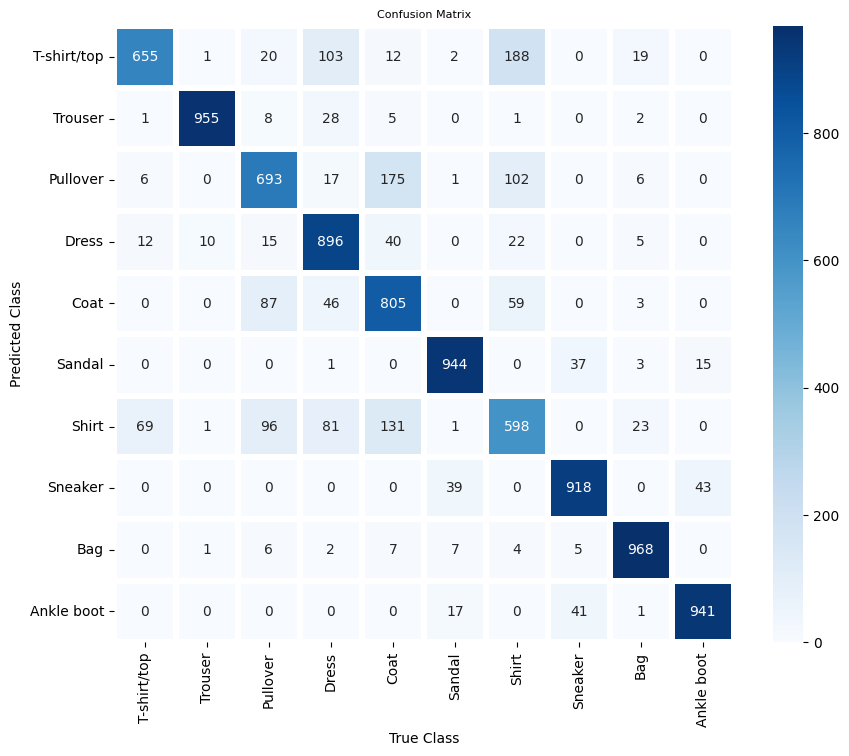

Epoch,▁
Training_Accuracy,▁
Training_Loss,▁
Validation_Accuracy,▁
Validation_Loss,▁
Epoch,1
Training_Accuracy,85.57
Training_Loss,0.56
Validation_Accuracy,85.52
Validation_Loss,0.57


In [54]:
# Run Neural Network class before plotting confusion matrix
y2 = np.eye(10)[y2]
mat = pd.DataFrame(confusion_matrix(np.argmax(y2,1) , np.argmax(np.array(y_preds).squeeze(),1)))
plt.figure(figsize=(10, 8))

axis = seaborn.heatmap(mat, annot=True,cmap='Blues',fmt='d',linewidths=3,linecolor='white')
axis.set_xticklabels(true_label,rotation=90)
axis.set_yticklabels(true_label,rotation=0)

plt.title('Confusion Matrix', fontsize=8)
plt.ylabel("Predicted Class")
plt.xlabel("True Class")

wandb.log({"Confusion_Matrix": wandb.Image(plt)})

plt.show()
wandb.finish()

## Ques 8

In [15]:
sweep_config = {
            'name': 'sweep 2 : crossEntropy vs meanSquaredError',
            'method': 'grid',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters':
                {
                    # 'dataset' : {'values': ['fashion_mnist']}, # 'fashion_mnist', 'mnist'
                    'iter': {'values': [10]},
                    'batch': {'values': [64]},
                    'lossFunc': {'values': ['crossEntropy', 'meanSquaredError']}, # 'meanSquaredError', 'crossEntropy'
                    'optimizer': {'values': ['Momentum']},
                    'n' : {'values': [1e-3, 1e-4]},
                    'Momentum' : {'values': [0.9]},
                    'beta' : {'values': [0.9]},
                    'beta1' : {'values': [0.999]},
                    'beta2' : {'values': [0.999]},
                    'e' : {'values': [1e-6]},
                    'alpha': {'values': [0]},
                    'initialization': {'values': ['Xavier']}, # 'Xavier'
                    'hiddenlayers': {'values': [5]},
                    'neuron': {'values': [128]},
                    'activation': {'values': ['tanh', 'ReLU']}, # 'tanh', 'ReLU'
                    'outAct': {'values': ['softmax']}
                }
            }



def train():
    #init-classinit , config - param_copy
    init = wandb.init(project='DL-Assignment-1-v3')
    config = init.config
    wandb.run.name = (
        'o:' + config.optimizer +
        '_a:' + config.activation +
        '_ep:' + str(config.iter) +
        '_l:' + config.lossFunc +
        '_i:' + config.initialization +
        '_hl:' + str(config.hiddenlayers) +
        '_hls:' + str(config.neuron)
    )
    obj=NeuralNetwork()
    obj.fit_model(x1,
                    y1,
                    x_val,
                    y_val,
                    hiddenlayers=config.hiddenlayers,
                    neuron=config.neuron,
                    input_neuron=784,
                    batch=config.batch,
                    initialization=config.initialization,
                    lossFunc=config.lossFunc,
                    activation=config.activation,
                    optimizer=config.optimizer,
                    n=config.n,
                    iter=config.iter,
                    beta=config.beta,
                    beta1=config.beta1,
                    beta2=config.beta2,
                    e=config.e,
                    alpha=config.alpha,
                    Momentum=config.Momentum)

    val_acc = obj.accuracy(x_val,y_val,config.activation)
    wandb.log({'Accuracy': val_acc})




sweep_id = wandb.sweep(sweep_config, project='DL-Assignment-1-v3')
wandb.agent(sweep_id, train, count = 10)
wandb.finish()





Create sweep with ID: oktiudre
Sweep URL: https://wandb.ai/cs24m019-iitm/DL-Assignment-1-v3/sweeps/oktiudre


wandb: Agent Starting Run: hcs27wcd with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.999
wandb: 	beta2: 0.999
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6755097858665347
Iteration Number: 1 Validation Loss : 0.6812237212798535
Iteration Number: 1 Train Accurcy : 83.3037037037037
Iteration Number: 1 Validaion Accuracy: 82.91666666666667
Iteration Number: 2 Train Loss : 0.58890900047635
Iteration Number: 2 Validation Loss : 0.6058701201478678
Iteration Number: 2 Train Accurcy : 85.55925925925926
Iteration Number: 2 Validaion Accuracy: 84.71666666666667
Iteration Number: 3 Train Loss : 0.5440802712509285
Iteration Number: 3 Validation Loss : 0.5696611657765758
Iteration Number: 3 Train Accurcy : 86.63703703703703
Iteration Number: 3 Validaion Accuracy: 85.5
Iteration Number: 4 Train Loss : 0.5142983734423187
Iteration Number: 4 Validation Loss : 0.5468122270507986
Iteration Number: 4 Train Accurcy : 87.2462962962963
Iteration Number: 4 Validaion Accuracy: 86.0
Iteration Number: 5 Train Loss : 0.4917210005565724
Iteration Number: 5 Validation Loss : 0.5302621084245452
Iteration Number: 5 Train Accurcy : 8

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇▇██
Training_Loss,█▆▄▃▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▅▆▇▇▇██
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,87.81667
Epoch,10
Training_Accuracy,89.33
Training_Loss,0.42
Validation_Accuracy,87.82


wandb: Agent Starting Run: nzafou8o with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.999
wandb: 	beta2: 0.999
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.1386994770330292
Iteration Number: 1 Validation Loss : 1.1432231739049055
Iteration Number: 1 Train Accurcy : 72.58333333333333
Iteration Number: 1 Validaion Accuracy: 72.83333333333334
Iteration Number: 2 Train Loss : 0.9464796440139129
Iteration Number: 2 Validation Loss : 0.951880945295457
Iteration Number: 2 Train Accurcy : 77.10000000000001
Iteration Number: 2 Validaion Accuracy: 77.0
Iteration Number: 3 Train Loss : 0.8580838099865441
Iteration Number: 3 Validation Loss : 0.8638501741952462
Iteration Number: 3 Train Accurcy : 79.15185185185184
Iteration Number: 3 Validaion Accuracy: 78.66666666666666
Iteration Number: 4 Train Loss : 0.8039376902268993
Iteration Number: 4 Validation Loss : 0.8102826770087252
Iteration Number: 4 Train Accurcy : 80.35185185185185
Iteration Number: 4 Validaion Accuracy: 79.83333333333333
Iteration Number: 5 Train Loss : 0.7659173491290993
Iteration Number: 5 Validation Loss : 0.7731878293817043
Iteration Number: 5 T

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇███
Training_Loss,█▅▄▃▃▂▂▁▁▁
Validation_Accuracy,▁▄▅▆▆▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,82.85
Epoch,10
Training_Accuracy,83.67
Training_Loss,0.66
Validation_Accuracy,82.85


wandb: Agent Starting Run: ftytwa57 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.999
wandb: 	beta2: 0.999
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.2720548379565917
Iteration Number: 1 Validation Loss : 0.2721867753497462
Iteration Number: 1 Train Accurcy : 81.01296296296296
Iteration Number: 1 Validaion Accuracy: 80.81666666666666
Iteration Number: 2 Train Loss : 0.23514146902724223
Iteration Number: 2 Validation Loss : 0.23897993504766427
Iteration Number: 2 Train Accurcy : 83.71851851851851
Iteration Number: 2 Validaion Accuracy: 83.41666666666666
Iteration Number: 3 Train Loss : 0.21686015517927
Iteration Number: 3 Validation Loss : 0.22405219564847925
Iteration Number: 3 Train Accurcy : 85.02962962962964
Iteration Number: 3 Validaion Accuracy: 84.55
Iteration Number: 4 Train Loss : 0.20517160321540645
Iteration Number: 4 Validation Loss : 0.2147683027352097
Iteration Number: 4 Train Accurcy : 85.99074074074075
Iteration Number: 4 Validaion Accuracy: 85.11666666666666
Iteration Number: 5 Train Loss : 0.19666174374719594
Iteration Number: 5 Validation Loss : 0.20812222618434384
Iteration Numbe

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇███
Training_Loss,█▆▄▄▃▂▂▂▂▁
Validation_Accuracy,▁▄▆▆▇▇▇███
Validation_Loss,█▅▄▃▃▂▂▂▁▁
Accuracy,86.56667
Epoch,10
Training_Accuracy,88.47
Training_Loss,0.17
Validation_Accuracy,86.57


wandb: Agent Starting Run: n3o6b0ly with config:
wandb: 	Momentum: 0.9
wandb: 	activation: tanh
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.999
wandb: 	beta2: 0.999
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.5312261678636196
Iteration Number: 1 Validation Loss : 0.5326762208052572
Iteration Number: 1 Train Accurcy : 62.52407407407408
Iteration Number: 1 Validaion Accuracy: 62.516666666666666
Iteration Number: 2 Train Loss : 0.41049825233170495
Iteration Number: 2 Validation Loss : 0.4125211182432945
Iteration Number: 2 Train Accurcy : 71.11481481481482
Iteration Number: 2 Validaion Accuracy: 71.06666666666666
Iteration Number: 3 Train Loss : 0.3608840148669133
Iteration Number: 3 Validation Loss : 0.36253553188055404
Iteration Number: 3 Train Accurcy : 74.6462962962963
Iteration Number: 3 Validaion Accuracy: 74.58333333333333
Iteration Number: 4 Train Loss : 0.3330520268050985
Iteration Number: 4 Validation Loss : 0.3345682282365242
Iteration Number: 4 Train Accurcy : 76.57407407407408
Iteration Number: 4 Validaion Accuracy: 76.53333333333333
Iteration Number: 5 Train Loss : 0.31449828809759506
Iteration Number: 5 Validation Loss : 0.31602007995670767
Ite

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▆▆▇▇▇███
Training_Loss,█▅▃▃▂▂▂▁▁▁
Validation_Accuracy,▁▄▆▆▇▇▇███
Validation_Loss,█▅▃▃▂▂▂▁▁▁
Accuracy,80.86667
Epoch,10
Training_Accuracy,81.38
Training_Loss,0.27
Validation_Accuracy,80.87


wandb: Agent Starting Run: y0mv7skq with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.999
wandb: 	beta2: 0.999
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.7209884820472193
Iteration Number: 1 Validation Loss : 0.7218958136447582
Iteration Number: 1 Train Accurcy : 81.90185185185184
Iteration Number: 1 Validaion Accuracy: 82.38333333333333
Iteration Number: 2 Train Loss : 0.6274623289913754
Iteration Number: 2 Validation Loss : 0.6322993750366928
Iteration Number: 2 Train Accurcy : 84.4074074074074
Iteration Number: 2 Validaion Accuracy: 84.48333333333333
Iteration Number: 3 Train Loss : 0.5830064905522705
Iteration Number: 3 Validation Loss : 0.5930885932832222
Iteration Number: 3 Train Accurcy : 85.4888888888889
Iteration Number: 3 Validaion Accuracy: 85.3
Iteration Number: 4 Train Loss : 0.5566277967668544
Iteration Number: 4 Validation Loss : 0.5713668429691818
Iteration Number: 4 Train Accurcy : 86.14814814814815
Iteration Number: 4 Validaion Accuracy: 85.96666666666667
Iteration Number: 5 Train Loss : 0.5363853607532157
Iteration Number: 5 Validation Loss : 0.5547746042734037
Iteration Number: 5 Tr

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▆▇▇███
Training_Loss,█▅▄▄▃▂▂▂▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▄▃▃▂▂▂▁▁
Accuracy,87.85
Epoch,10
Training_Accuracy,88.2
Training_Loss,0.47
Validation_Accuracy,87.85


wandb: Agent Starting Run: 5j4ke0s0 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.999
wandb: 	beta2: 0.999
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: crossEntropy
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 1.0957552239824815
Iteration Number: 1 Validation Loss : 1.105077428210155
Iteration Number: 1 Train Accurcy : 73.95925925925926
Iteration Number: 1 Validaion Accuracy: 73.23333333333333
Iteration Number: 2 Train Loss : 0.9077054945382027
Iteration Number: 2 Validation Loss : 0.9116150223432903
Iteration Number: 2 Train Accurcy : 77.93333333333334
Iteration Number: 2 Validaion Accuracy: 77.78333333333333
Iteration Number: 3 Train Loss : 0.8252260979890598
Iteration Number: 3 Validation Loss : 0.8281231527872246
Iteration Number: 3 Train Accurcy : 80.08518518518518
Iteration Number: 3 Validaion Accuracy: 79.83333333333333
Iteration Number: 4 Train Loss : 0.7736069009631852
Iteration Number: 4 Validation Loss : 0.7768264379238511
Iteration Number: 4 Train Accurcy : 81.2962962962963
Iteration Number: 4 Validaion Accuracy: 81.43333333333334
Iteration Number: 5 Train Loss : 0.7364331762336401
Iteration Number: 5 Validation Loss : 0.7401544855334949
Iteration

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▄▅▆▇▇▇███
Training_Loss,█▅▄▃▃▂▂▁▁▁
Validation_Accuracy,▁▄▅▆▇▇▇███
Validation_Loss,█▅▄▃▂▂▂▁▁▁
Accuracy,84.26667
Epoch,10
Training_Accuracy,84.28
Training_Loss,0.64
Validation_Accuracy,84.27


wandb: Agent Starting Run: h56htkem with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.999
wandb: 	beta2: 0.999
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.37834958658241014
Iteration Number: 1 Validation Loss : 0.37488825272698995
Iteration Number: 1 Train Accurcy : 72.10740740740741
Iteration Number: 1 Validaion Accuracy: 72.68333333333334
Iteration Number: 2 Train Loss : 0.24988651254982489
Iteration Number: 2 Validation Loss : 0.25275927001083753
Iteration Number: 2 Train Accurcy : 83.30925925925926
Iteration Number: 2 Validaion Accuracy: 83.25
Iteration Number: 3 Train Loss : 0.21389346565046594
Iteration Number: 3 Validation Loss : 0.21791525476100984
Iteration Number: 3 Train Accurcy : 85.3537037037037
Iteration Number: 3 Validaion Accuracy: 85.43333333333332
Iteration Number: 4 Train Loss : 0.20038933669474465
Iteration Number: 4 Validation Loss : 0.20648604461219944
Iteration Number: 4 Train Accurcy : 86.28518518518518
Iteration Number: 4 Validaion Accuracy: 86.0
Iteration Number: 5 Train Loss : 0.19252297235213905
Iteration Number: 5 Validation Loss : 0.20023067037021702
Iteration Number: 5 Tra

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▆▇▇▇▇████
Training_Loss,█▄▂▂▂▂▁▁▁▁
Validation_Accuracy,▁▆▇▇▇█████
Validation_Loss,█▄▂▂▂▂▁▁▁▁
Accuracy,87.41667
Epoch,10
Training_Accuracy,88.52
Training_Loss,0.17
Validation_Accuracy,87.42


wandb: Agent Starting Run: 6hk38n78 with config:
wandb: 	Momentum: 0.9
wandb: 	activation: ReLU
wandb: 	alpha: 0
wandb: 	batch: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.999
wandb: 	beta2: 0.999
wandb: 	e: 1e-06
wandb: 	hiddenlayers: 5
wandb: 	initialization: Xavier
wandb: 	iter: 10
wandb: 	lossFunc: meanSquaredError
wandb: 	n: 0.0001
wandb: 	neuron: 128
wandb: 	optimizer: Momentum
wandb: 	outAct: softmax


Iteration Number: 1 Train Loss : 0.6978709291326493
Iteration Number: 1 Validation Loss : 0.6950305032505506
Iteration Number: 1 Train Accurcy : 46.324074074074076
Iteration Number: 1 Validaion Accuracy: 46.516666666666666
Iteration Number: 2 Train Loss : 0.6412506572181856
Iteration Number: 2 Validation Loss : 0.6363638516603938
Iteration Number: 2 Train Accurcy : 50.68518518518519
Iteration Number: 2 Validaion Accuracy: 50.96666666666667
Iteration Number: 3 Train Loss : 0.5528252238611598
Iteration Number: 3 Validation Loss : 0.5483342987525368
Iteration Number: 3 Train Accurcy : 58.12037037037037
Iteration Number: 3 Validaion Accuracy: 58.599999999999994
Iteration Number: 4 Train Loss : 0.4581559640924368
Iteration Number: 4 Validation Loss : 0.4563398399540721
Iteration Number: 4 Train Accurcy : 67.70185185185184
Iteration Number: 4 Validaion Accuracy: 68.01666666666667
Iteration Number: 5 Train Loss : 0.42156077471410747
Iteration Number: 5 Validation Loss : 0.4197392425323836
Ite

Accuracy,▁
Epoch,▁▂▃▃▄▅▆▆▇█
Training_Accuracy,▁▂▄▇▇▇████
Training_Loss,█▇▅▃▂▂▁▁▁▁
Validation_Accuracy,▁▂▄▇▇▇████
Validation_Loss,█▇▅▃▂▂▁▁▁▁
Accuracy,73.31667
Epoch,10
Training_Accuracy,73
Training_Loss,0.37
Validation_Accuracy,73.32


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## Ques 10

In [16]:
(x1, y1), (x2, y2) = mnist.load_data()

x1=x1.reshape(x1.shape[0],-1) / 255
x2=x2.reshape(x2.shape[0],-1)/ 255

x1, x_val, y1, y_val = train_test_split(x1,y1, test_size=0.1, random_state=0)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Model :1

In [ ]:
obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=4,
                 neuron=128,
                 input_neuron=784,
                 batch=64,
                 initialization="Xavier",
                 lossFunc="crossEntropy",
                 activation="tanh", # tanh relu
                 optimizer="nADAM", # N,A,Rms
                 n=0.0001,
                 iter=10,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-6,
                 alpha=0,
                 Momentum=0.9)

## Model:2

In [ ]:
obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=4,
                 neuron=128,
                 input_neuron=784,
                 batch=32,
                 initialization="Xavier",
                 lossFunc="crossEntropy",
                 activation="ReLU",
                 optimizer="nADAM",
                 n=0.0001,
                 iter=10,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-6,
                 alpha=0,
                 Momentum=0.9)

## Model: 3

In [ ]:
obj=NeuralNetwork()
obj.fit_model(x1,
                 y1,
                 x_val,
                 y_val,
                 hiddenlayers=4,
                 neuron=128,
                 input_neuron=784,
                 batch=64,
                 initialization="Xavier",
                 lossFunc="crossEntropy",
                 activation="tanh", # tanh relu
                 optimizer="ADAM", # N,A,Rms
                 n=0.0001,
                 iter=10,
                 beta=0.9,
                 beta1=0.999,
                 beta2=0.999,
                 e=1e-6,
                 alpha=0,
                 Momentum=0.9)